In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import sys
import xlwt


def transfromData(trainRaw, testRaw,windosSize):  ##Train ratial, train, test
    sc = MinMaxScaler(feature_range = (0, 1))
    #npRaw = np.array(rawData)
    #scaledData = sc.fit_transform(npRaw.reshape(-1,1))  
    #trainData = np.array(scaledData[:trainCount]).reshape(-1,1)##train 
    #testData = np.array(scaledData[-testCount:]).reshape(-1,1)
    
    npTrain = sc.fit_transform(np.array(trainRaw).reshape(-1,1))
    npTest = sc.fit_transform(np.array(testRaw).reshape(-1,1))
    

    X_train, y_train = splitXy(npTrain,windosSize)
    X_test, y_test = splitXy(npTest,windosSize)
    return sc, X_train, y_train, X_test, y_test

def splitXy(data,windosSize):
    windows = []
    for i in range(windosSize, data.shape[0]):
        windows.append(data[i-windosSize:i, 0])
    np.random.shuffle(windows)
    X = []
    y = []
    for i in range(len(windows)):
        X.append(windows[i][:windosSize-1])
        y.append(windows[i][-1:])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,y
def buildModel():
    regressor = Sequential()
    #regressor.add(Bidirectional(LSTM(units=50,return_sequences=True),input_shape = (X_train.shape[1], 1)))
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    # Compiling
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor
def getStationList(cursor):
    stationList = []
    queryString = "SELECT distinct station from cleandata"
    cursor.execute(queryString)
    results = cursor.fetchall()
    for row in results :
        val = str(row).strip("',()")
        stationList.append(val)
    stationList.remove('富貴角')##only 106少數資料
    return stationList
def Visualize():
    predicted = sc.inverse_transform(regressor.predict(X_test))
    originY = sc.inverse_transform (y_test)
    print("MSE : ["+str(mean_squared_error(predicted, originY))+"]")
    # Visualising the results
    plt.plot(originY[:100], color = 'red', label = 'Real')  
    plt.plot(predicted[:100], color = 'blue', label = 'Predicted ') 
    plt.legend()
    plt.show()
def writeExcelHead(sheet1,epochs,station):
    sheet1.write(0,1,station)
    raw = 1
    for e in range(epochs):
        sheet1.write(raw,0,e+1)
        raw+=1
    

In [3]:

##get data##
import MySQLdb
import numpy as np
from sklearn.preprocessing import MinMaxScaler
def fetchData(cursor,station,windosSize):
    queryString = "SELECT * from cleandata where station='"+station+"' and item = 'PM2.5' and date NOT like '2017%'"
    cursor.execute(queryString)
    results = cursor.fetchall()

    trainRawData = []
    for row in results:
        for i in range(3,27):
            trainRawData.append(float(row[i]))
            
    queryString = "SELECT * from cleandata where station='"+station+"' and item = 'PM2.5' and date like '2017%'"
    cursor.execute(queryString)
    results = cursor.fetchall()

    testRawData = []
    for row in results:
        for i in range(3,27):
            testRawData.append(float(row[i]))

    sc, X_train, y_train, X_test, y_test = transfromData(trainRawData,testRawData,windosSize)
    return sc, X_train, y_train, X_test, y_test

In [4]:
def train(regressor,sc, X_train, y_train, X_test, y_test,epochs):
    patient = 50
    p_cnt = 0
    prev_mse = 0.0
    mseList = []
    for i in range(epochs):
        regressor.fit(X_train, y_train,validation_split=0.2, epochs = 1, batch_size = 32,verbose=2)
        predicted = sc.inverse_transform(regressor.predict(X_test))
        originY = sc.inverse_transform (y_test)
        mse = mean_squared_error(predicted, originY)
        mseList.append(mse)
        if prev_mse < mse:
            p_cnt += 1
        if prev_mse >mse :
            p_cnt -= 1
        print("Epoch : " +str(i)+", MSE : ["+str(mse)+"]")
        print('-------------------------------------------')
        prev_mse = mse
    
        if p_cnt > 50 :
            break
    plt.plot(mseList, color = 'blue', label = 'MSEs ') 
    plt.legend()
    plt.show()
    return mseList

training : 二林
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 9s - loss: 0.0027 - val_loss: 0.0015
Epoch : 0, MSE : [79.38029047637671]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0010
Epoch : 1, MSE : [50.400221864144754]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 5s - loss: 9.0738e-04 - val_loss: 8.5728e-04
Epoch : 2, MSE : [43.028808381197805]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 8.6200e-04 - val_loss: 8.5546e-04
Epoch : 3, MSE : [43.103045571501916]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 8.1426e-04 - val_loss: 8.2832e-04
Epoch : 4, MSE : [42.106263103952124]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1

 - 4s - loss: 7.4894e-04 - val_loss: 7.7620e-04
Epoch : 43, MSE : [39.24965643557091]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.4774e-04 - val_loss: 7.7233e-04
Epoch : 44, MSE : [39.41737457930152]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.5568e-04 - val_loss: 7.7912e-04
Epoch : 45, MSE : [39.70928535543535]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.4808e-04 - val_loss: 7.6684e-04
Epoch : 46, MSE : [38.93279421998443]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.4906e-04 - val_loss: 8.0977e-04
Epoch : 47, MSE : [41.520307925869176]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 5s - loss: 7.5792e-04 - val_loss: 7.9512e-04
Epoch 

 - 4s - loss: 7.2814e-04 - val_loss: 7.6590e-04
Epoch : 87, MSE : [38.86463249635715]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.3523e-04 - val_loss: 7.7584e-04
Epoch : 88, MSE : [39.598390904850326]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.3334e-04 - val_loss: 7.6903e-04
Epoch : 89, MSE : [39.10308735960219]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.3616e-04 - val_loss: 7.6607e-04
Epoch : 90, MSE : [39.0658718124025]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 5s - loss: 7.3766e-04 - val_loss: 7.7124e-04
Epoch : 91, MSE : [39.04002640544861]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.3704e-04 - val_loss: 7.6906e-04
Epoch :

Epoch : 130, MSE : [38.85993918124883]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.3210e-04 - val_loss: 7.6487e-04
Epoch : 131, MSE : [39.09406171282577]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 5s - loss: 7.3186e-04 - val_loss: 7.8099e-04
Epoch : 132, MSE : [39.75735027567154]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 5s - loss: 7.2070e-04 - val_loss: 7.7428e-04
Epoch : 133, MSE : [39.30553704266692]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 5s - loss: 7.4672e-04 - val_loss: 7.8045e-04
Epoch : 134, MSE : [39.922181414696155]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 5s - loss: 7.3173e-04 - val_loss: 7.6060e-04
Epoch : 135, MSE : [38.690896711485664]
---------

 - 4s - loss: 7.1517e-04 - val_loss: 7.5247e-04
Epoch : 174, MSE : [37.973763605868704]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.1766e-04 - val_loss: 7.9368e-04
Epoch : 175, MSE : [39.945483063773246]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.1913e-04 - val_loss: 7.5550e-04
Epoch : 176, MSE : [38.17477963781711]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.0940e-04 - val_loss: 7.5586e-04
Epoch : 177, MSE : [38.2796904377704]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.2562e-04 - val_loss: 7.5499e-04
Epoch : 178, MSE : [38.11563255421705]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 4s - loss: 7.1634e-04 - val_loss: 7.6022e-04
E

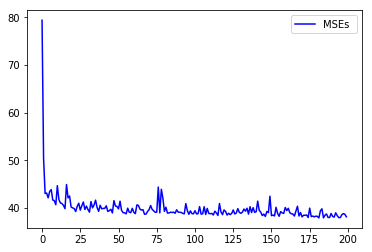

check point at 2019-04-25 10:57:40.910105
training : 南投
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 0.0031 - val_loss: 0.0014
Epoch : 0, MSE : [43.54975151793058]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 0.0013 - val_loss: 7.4039e-04
Epoch : 1, MSE : [23.51764392003459]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 9.0061e-04 - val_loss: 6.2397e-04
Epoch : 2, MSE : [19.893786192742954]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 6s - loss: 8.2248e-04 - val_loss: 6.4079e-04
Epoch : 3, MSE : [20.460259154335063]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 8.1796e-04 - val_loss: 6.7627e-04
Epoch : 4, MSE : [21.52334217955416]
-------------------------------------------
Train on 22036

 - 5s - loss: 7.4449e-04 - val_loss: 6.3263e-04
Epoch : 43, MSE : [20.147830475471356]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 7.4573e-04 - val_loss: 5.9284e-04
Epoch : 44, MSE : [19.027260515705063]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 7.3548e-04 - val_loss: 5.9227e-04
Epoch : 45, MSE : [18.927772799764707]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 7.2667e-04 - val_loss: 5.8876e-04
Epoch : 46, MSE : [18.986664275606937]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 7.3161e-04 - val_loss: 5.9303e-04
Epoch : 47, MSE : [18.982666850464874]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 7.3332e-04 - val_loss: 5.8731e-04
Ep

Epoch : 86, MSE : [17.895802697939132]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 7.0390e-04 - val_loss: 5.8010e-04
Epoch : 87, MSE : [18.538913960442994]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.9823e-04 - val_loss: 5.7133e-04
Epoch : 88, MSE : [18.16774851443851]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.8882e-04 - val_loss: 5.7390e-04
Epoch : 89, MSE : [18.20531627463551]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.9346e-04 - val_loss: 5.8159e-04
Epoch : 90, MSE : [18.403440236438676]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.8544e-04 - val_loss: 5.7057e-04
Epoch : 91, MSE : [18.17490202655924]
--------------

 - 5s - loss: 6.8789e-04 - val_loss: 5.6428e-04
Epoch : 130, MSE : [17.95729911068336]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.9224e-04 - val_loss: 5.8021e-04
Epoch : 131, MSE : [18.417052537820013]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.8689e-04 - val_loss: 5.7244e-04
Epoch : 132, MSE : [18.180518772276898]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.9009e-04 - val_loss: 5.6009e-04
Epoch : 133, MSE : [17.793187900523638]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.8493e-04 - val_loss: 5.6320e-04
Epoch : 134, MSE : [17.85935776132172]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.8564e-04 - val_loss: 5.7532e-04

 - 5s - loss: 6.7912e-04 - val_loss: 5.7854e-04
Epoch : 173, MSE : [18.299263360678463]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.8342e-04 - val_loss: 5.6958e-04
Epoch : 174, MSE : [18.039851697740797]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.7797e-04 - val_loss: 5.9595e-04
Epoch : 175, MSE : [18.988413159780805]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.7487e-04 - val_loss: 5.6922e-04
Epoch : 176, MSE : [17.909538813350235]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.7980e-04 - val_loss: 6.0076e-04
Epoch : 177, MSE : [18.856341510912152]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 5s - loss: 6.7604e-04 - val_loss: 5.5912e-

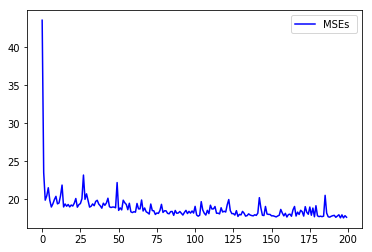

check point at 2019-04-25 11:20:00.986732
training : 埔里
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 8s - loss: 8.4912e-04 - val_loss: 4.9945e-04
Epoch : 0, MSE : [43.66746716059939]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 3.8365e-04 - val_loss: 3.5486e-04
Epoch : 1, MSE : [30.05375032871305]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.9629e-04 - val_loss: 2.7795e-04
Epoch : 2, MSE : [23.447526168809084]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.7775e-04 - val_loss: 2.7157e-04
Epoch : 3, MSE : [22.79461735989898]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.5878e-04 - val_loss: 2.6347e-04
Epoch : 4, MSE : [22.416709237547746]
-------------------------------------------
Tr

 - 5s - loss: 2.3104e-04 - val_loss: 2.7134e-04
Epoch : 43, MSE : [21.471513119312018]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.2933e-04 - val_loss: 2.7179e-04
Epoch : 44, MSE : [21.530370647607416]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.3043e-04 - val_loss: 2.9271e-04
Epoch : 45, MSE : [23.353484945961945]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.2862e-04 - val_loss: 2.6750e-04
Epoch : 46, MSE : [21.24273463985816]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.2631e-04 - val_loss: 2.7172e-04
Epoch : 47, MSE : [21.420080729375577]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.2686e-04 - val_loss: 2.6806e-04
Epo

Epoch : 86, MSE : [21.823660614254745]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.2320e-04 - val_loss: 2.8884e-04
Epoch : 87, MSE : [23.033178329272268]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.2292e-04 - val_loss: 2.7343e-04
Epoch : 88, MSE : [21.430870844609156]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.2177e-04 - val_loss: 2.8549e-04
Epoch : 89, MSE : [22.40004662142441]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1697e-04 - val_loss: 2.6824e-04
Epoch : 90, MSE : [20.981679181757038]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1954e-04 - val_loss: 2.7217e-04
Epoch : 91, MSE : [21.105860438090208]
------------

 - 5s - loss: 2.1288e-04 - val_loss: 2.7989e-04
Epoch : 130, MSE : [21.012562924031904]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1537e-04 - val_loss: 2.8290e-04
Epoch : 131, MSE : [20.743764822159076]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1655e-04 - val_loss: 2.9135e-04
Epoch : 132, MSE : [22.130657104554015]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1347e-04 - val_loss: 2.8306e-04
Epoch : 133, MSE : [21.184267162752718]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1436e-04 - val_loss: 2.9117e-04
Epoch : 134, MSE : [21.73430587638005]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1565e-04 - val_loss: 2.7961e-0

Epoch : 173, MSE : [20.47102442765833]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1090e-04 - val_loss: 2.8316e-04
Epoch : 174, MSE : [20.679363790494232]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1020e-04 - val_loss: 2.8298e-04
Epoch : 175, MSE : [20.476521304287868]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1015e-04 - val_loss: 2.9573e-04
Epoch : 176, MSE : [21.542251741209597]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.1194e-04 - val_loss: 2.8897e-04
Epoch : 177, MSE : [21.038842974090898]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 5s - loss: 2.0933e-04 - val_loss: 2.9137e-04
Epoch : 178, MSE : [21.333882530281297]
------

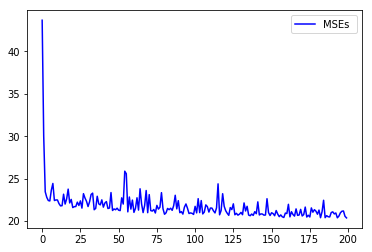

check point at 2019-04-25 11:41:38.655916
training : 大里
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 7s - loss: 0.0040 - val_loss: 0.0023
Epoch : 0, MSE : [74.51460035995099]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0020 - val_loss: 0.0015
Epoch : 1, MSE : [47.43503037268877]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0016 - val_loss: 0.0013
Epoch : 2, MSE : [42.907809179337946]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0015 - val_loss: 0.0013
Epoch : 3, MSE : [42.034002924658466]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0014 - val_loss: 0.0013
Epoch : 4, MSE : [43.21007426266333]
-------------------------------------------
Train on 16103 samples, validate on 4026 s

 - 4s - loss: 0.0013 - val_loss: 0.0012
Epoch : 45, MSE : [37.6003874180667]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0013 - val_loss: 0.0012
Epoch : 46, MSE : [37.082146247383506]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0013 - val_loss: 0.0012
Epoch : 47, MSE : [38.522777266462576]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0013 - val_loss: 0.0012
Epoch : 48, MSE : [38.11337048981225]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0013
Epoch : 49, MSE : [41.071772168426484]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0013 - val_loss: 0.0013
Epoch : 50, MSE : [39.19605363340519]
---------------

Epoch : 90, MSE : [37.124202771489735]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 91, MSE : [37.78320058154169]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 92, MSE : [37.2779158864339]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 93, MSE : [37.617027196673284]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 94, MSE : [37.27007297712562]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 95, MSE : [38.330871256349724]
-------------------------------------------
Train on 16

Epoch : 135, MSE : [36.292262646177385]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 136, MSE : [37.15050799192906]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 137, MSE : [36.34220402217595]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 138, MSE : [36.403931592859344]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 139, MSE : [36.88873812737407]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 140, MSE : [36.70723464500313]
-------------------------------------------
Train

Epoch : 180, MSE : [36.76252624926075]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 181, MSE : [36.472699105366615]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 182, MSE : [37.248659680046806]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 183, MSE : [35.96535625020614]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 184, MSE : [35.92928243005757]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0012
Epoch : 185, MSE : [35.90912237794019]
-------------------------------------------
Train

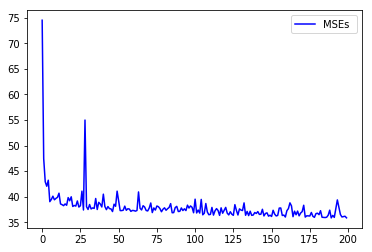

check point at 2019-04-25 11:58:02.170400
training : 彰化
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 9s - loss: 0.0029 - val_loss: 0.0016
Epoch : 0, MSE : [55.11974504840672]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 0.0013 - val_loss: 0.0010
Epoch : 1, MSE : [35.4523185410353]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 0.0011 - val_loss: 0.0010
Epoch : 2, MSE : [34.49605235554759]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 0.0011 - val_loss: 0.0010
Epoch : 3, MSE : [35.79500235076453]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 0.0010 - val_loss: 0.0010
Epoch : 4, MSE : [34.671028313179626]
-------------------------------------------
Train on 20384 samples, validate on 5097 sam

Epoch : 43, MSE : [33.862813837536144]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.5936e-04 - val_loss: 9.4161e-04
Epoch : 44, MSE : [32.127437841204504]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.3831e-04 - val_loss: 9.4546e-04
Epoch : 45, MSE : [32.16985889079046]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.3668e-04 - val_loss: 9.7480e-04
Epoch : 46, MSE : [33.23256456496839]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.5455e-04 - val_loss: 9.9201e-04
Epoch : 47, MSE : [34.169469972752665]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.4667e-04 - val_loss: 9.5775e-04
Epoch : 48, MSE : [32.75522786911175]
--------------

 - 5s - loss: 9.3690e-04 - val_loss: 9.3576e-04
Epoch : 87, MSE : [31.7471139565941]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.3105e-04 - val_loss: 9.2745e-04
Epoch : 88, MSE : [31.74398912345469]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.3315e-04 - val_loss: 9.4076e-04
Epoch : 89, MSE : [32.24092752588504]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.3834e-04 - val_loss: 9.4061e-04
Epoch : 90, MSE : [31.965239403387955]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.3047e-04 - val_loss: 9.3856e-04
Epoch : 91, MSE : [31.83188256335658]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.3964e-04 - val_loss: 9.3757e-04
Epoch :

Epoch : 130, MSE : [31.620272023061204]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.1519e-04 - val_loss: 9.4153e-04
Epoch : 131, MSE : [31.818015651169304]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.1885e-04 - val_loss: 9.3143e-04
Epoch : 132, MSE : [31.436472857273184]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.1589e-04 - val_loss: 9.4421e-04
Epoch : 133, MSE : [31.66513458539525]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.1157e-04 - val_loss: 9.2270e-04
Epoch : 134, MSE : [31.12340362970965]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.1823e-04 - val_loss: 9.2656e-04
Epoch : 135, MSE : [31.220207002734774]
-------

 - 5s - loss: 9.0611e-04 - val_loss: 9.3756e-04
Epoch : 174, MSE : [31.51042389396546]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.1310e-04 - val_loss: 9.4045e-04
Epoch : 175, MSE : [31.682677554941325]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.0749e-04 - val_loss: 9.3109e-04
Epoch : 176, MSE : [31.28297089408314]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.0785e-04 - val_loss: 9.4744e-04
Epoch : 177, MSE : [31.686565669816392]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.0872e-04 - val_loss: 9.3987e-04
Epoch : 178, MSE : [31.47671438936611]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 5s - loss: 9.0457e-04 - val_loss: 9.4125e-04


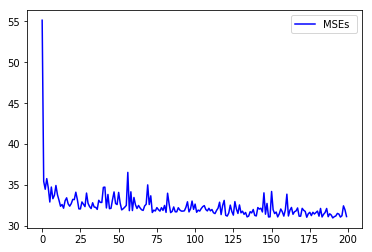

check point at 2019-04-25 12:18:56.389984
training : 忠明
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 8s - loss: 0.0037 - val_loss: 0.0019
Epoch : 0, MSE : [53.2817379672654]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0018 - val_loss: 0.0012
Epoch : 1, MSE : [33.6735453451584]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0014 - val_loss: 0.0011
Epoch : 2, MSE : [31.204809868660636]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0014 - val_loss: 0.0011
Epoch : 3, MSE : [30.48601696034729]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0013 - val_loss: 0.0011
Epoch : 4, MSE : [31.0566071659675]
-------------------------------------------
Train on 21076 samples, validate on 5269 sampl

 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 45, MSE : [29.384317821354365]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 46, MSE : [29.122682289258723]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 47, MSE : [29.335721366941897]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 48, MSE : [29.078739071484158]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 49, MSE : [29.710878639477762]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 50, MSE : [29.319622147840324]
-----------

 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 90, MSE : [29.456830127705288]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 91, MSE : [29.591522038629567]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 92, MSE : [28.980294802245435]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.9136e-04
Epoch : 93, MSE : [28.631380589311103]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.9206e-04
Epoch : 94, MSE : [28.730156901193485]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.9125e-04
Epoch : 95, MSE : [28.677123638310654]

 - 5s - loss: 0.0012 - val_loss: 9.9049e-04
Epoch : 135, MSE : [28.667127722675477]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.9173e-04
Epoch : 136, MSE : [28.667816723604993]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.8092e-04
Epoch : 137, MSE : [28.402133030350598]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.8640e-04
Epoch : 138, MSE : [28.820245546489396]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.7462e-04
Epoch : 139, MSE : [28.393329934657796]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.8088e-04
Epoch : 140, MSE : [2

Epoch : 179, MSE : [29.07896841391962]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.8011e-04
Epoch : 180, MSE : [28.28482421777588]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.7499e-04
Epoch : 181, MSE : [28.422850941293436]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0011 - val_loss: 0.0010
Epoch : 182, MSE : [28.83849608707808]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 0.0010
Epoch : 183, MSE : [29.053340147293753]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.8376e-04
Epoch : 184, MSE : [28.39887481614581]
-------------------------------------

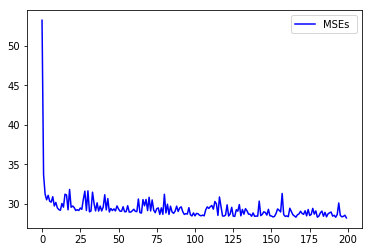

check point at 2019-04-25 12:40:13.296331
training : 沙鹿
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 9s - loss: 0.0016 - val_loss: 9.1885e-04
Epoch : 0, MSE : [52.57560435225016]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 7.6378e-04 - val_loss: 4.9197e-04
Epoch : 1, MSE : [28.069358496886444]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 5.7874e-04 - val_loss: 4.6398e-04
Epoch : 2, MSE : [25.976746863363214]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 5.4793e-04 - val_loss: 4.6824e-04
Epoch : 3, MSE : [26.24659625121716]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 5.4264e-04 - val_loss: 4.6962e-04
Epoch : 4, MSE : [26.23937537798418]
-------------------------------------------
Train 

 - 5s - loss: 5.1321e-04 - val_loss: 4.4723e-04
Epoch : 43, MSE : [24.9866227241368]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.9728e-04 - val_loss: 4.5372e-04
Epoch : 44, MSE : [25.573433529368117]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 5.0967e-04 - val_loss: 4.5499e-04
Epoch : 45, MSE : [25.428262229222337]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.9829e-04 - val_loss: 4.5459e-04
Epoch : 46, MSE : [25.31295872417337]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 6s - loss: 4.9307e-04 - val_loss: 4.5680e-04
Epoch : 47, MSE : [25.81802186897835]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.8677e-04 - val_loss: 4.5134e-04
Epoch 

Epoch : 86, MSE : [25.521783588876524]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.8171e-04 - val_loss: 4.3827e-04
Epoch : 87, MSE : [24.380889645208644]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.7462e-04 - val_loss: 4.5207e-04
Epoch : 88, MSE : [25.164626542431158]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.7585e-04 - val_loss: 4.5681e-04
Epoch : 89, MSE : [25.312521402076815]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.8900e-04 - val_loss: 4.3432e-04
Epoch : 90, MSE : [24.360846848326595]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.7568e-04 - val_loss: 4.4352e-04
Epoch : 91, MSE : [24.701974580633827]
-----------

 - 5s - loss: 4.6488e-04 - val_loss: 4.3387e-04
Epoch : 130, MSE : [24.608383671266477]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.6507e-04 - val_loss: 4.1852e-04
Epoch : 131, MSE : [23.48450985399866]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.6608e-04 - val_loss: 4.3312e-04
Epoch : 132, MSE : [24.457598319013893]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.6645e-04 - val_loss: 4.2695e-04
Epoch : 133, MSE : [23.90193545890034]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.7063e-04 - val_loss: 4.4726e-04
Epoch : 134, MSE : [25.089164470841524]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.6364e-04 - val_loss: 4.2182e-04

Epoch : 173, MSE : [23.364045078711246]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.6121e-04 - val_loss: 4.3697e-04
Epoch : 174, MSE : [23.841038908838005]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.5008e-04 - val_loss: 4.2307e-04
Epoch : 175, MSE : [23.455801590106937]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.5248e-04 - val_loss: 4.2689e-04
Epoch : 176, MSE : [23.497911105876607]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.5574e-04 - val_loss: 4.3253e-04
Epoch : 177, MSE : [23.841129224078013]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 5s - loss: 4.5782e-04 - val_loss: 4.2236e-04
Epoch : 178, MSE : [23.387374541789875]
-----

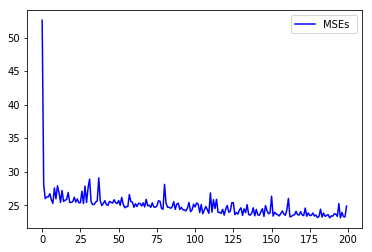

check point at 2019-04-25 13:03:08.336105
training : 竹山
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 9s - loss: 0.0041 - val_loss: 0.0019
Epoch : 0, MSE : [46.97333703509659]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0018 - val_loss: 0.0011
Epoch : 1, MSE : [26.551245500522562]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0013 - val_loss: 0.0010
Epoch : 2, MSE : [24.128156860746813]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0012 - val_loss: 9.7853e-04
Epoch : 3, MSE : [23.25144190010082]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0011 - val_loss: 9.9111e-04
Epoch : 4, MSE : [23.6481755851559]
-------------------------------------------
Train on 21805 samples, validate on

 - 6s - loss: 0.0010 - val_loss: 9.2363e-04
Epoch : 44, MSE : [21.630582962283462]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0010 - val_loss: 9.5046e-04
Epoch : 45, MSE : [22.192192288666778]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0011 - val_loss: 9.3251e-04
Epoch : 46, MSE : [21.872505564230742]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0010 - val_loss: 0.0012
Epoch : 47, MSE : [27.87339316113553]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0010 - val_loss: 0.0010
Epoch : 48, MSE : [23.729625963387747]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 0.0010 - val_loss: 9.4348e-04
Epoch : 49, MSE : [22.1217456973675

Epoch : 88, MSE : [22.15185702284774]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.8149e-04 - val_loss: 9.2281e-04
Epoch : 89, MSE : [21.414352412690413]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.9606e-04 - val_loss: 0.0010
Epoch : 90, MSE : [23.231619324811337]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.9867e-04 - val_loss: 9.8517e-04
Epoch : 91, MSE : [23.165578196603686]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.9160e-04 - val_loss: 9.5582e-04
Epoch : 92, MSE : [22.44919999321333]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.8155e-04 - val_loss: 0.0010
Epoch : 93, MSE : [23.342484150864124]
---------------------

 - 5s - loss: 9.8692e-04 - val_loss: 9.1104e-04
Epoch : 132, MSE : [21.166533894249742]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.8681e-04 - val_loss: 9.4386e-04
Epoch : 133, MSE : [21.926903965033137]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.8014e-04 - val_loss: 9.0591e-04
Epoch : 134, MSE : [21.151331485741533]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.9147e-04 - val_loss: 9.2545e-04
Epoch : 135, MSE : [21.536073688305517]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.7918e-04 - val_loss: 9.0562e-04
Epoch : 136, MSE : [20.967155124667244]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.8707e-04 - val_loss: 9.1029e-

 - 5s - loss: 9.6239e-04 - val_loss: 9.0790e-04
Epoch : 175, MSE : [21.068754979079397]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.7244e-04 - val_loss: 9.0633e-04
Epoch : 176, MSE : [21.10186062247273]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.6505e-04 - val_loss: 9.3443e-04
Epoch : 177, MSE : [21.61710435385199]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.7367e-04 - val_loss: 9.1924e-04
Epoch : 178, MSE : [21.223537223701612]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.7173e-04 - val_loss: 8.9887e-04
Epoch : 179, MSE : [20.828874873204278]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 5s - loss: 9.6712e-04 - val_loss: 9.3423e-04

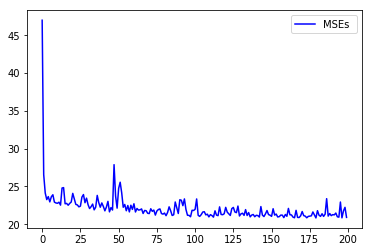

check point at 2019-04-25 13:25:40.643174
training : 線西
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 8.8190e-04 - val_loss: 4.5476e-04
Epoch : 0, MSE : [50.42598650549668]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 3.9019e-04 - val_loss: 3.2107e-04
Epoch : 1, MSE : [32.6169360132984]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 3.1636e-04 - val_loss: 2.3175e-04
Epoch : 2, MSE : [26.913423457219693]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 3.0690e-04 - val_loss: 2.3958e-04
Epoch : 3, MSE : [27.242735094858016]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 6s - loss: 2.9049e-04 - val_loss: 2.4705e-04
Epoch : 4, MSE : [27.180331167849186]
-------------------------------------------
Tr

 - 5s - loss: 2.6675e-04 - val_loss: 2.0107e-04
Epoch : 43, MSE : [24.52330358646114]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.6599e-04 - val_loss: 2.0667e-04
Epoch : 44, MSE : [25.285742221232844]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.7073e-04 - val_loss: 2.0994e-04
Epoch : 45, MSE : [25.44681107782131]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.6398e-04 - val_loss: 2.0473e-04
Epoch : 46, MSE : [25.19740995146068]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.6992e-04 - val_loss: 2.1293e-04
Epoch : 47, MSE : [26.289627127978708]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.6854e-04 - val_loss: 1.9999e-04
Epoch

Epoch : 86, MSE : [25.696617777264596]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5775e-04 - val_loss: 2.1029e-04
Epoch : 87, MSE : [25.632308589412432]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5867e-04 - val_loss: 1.9803e-04
Epoch : 88, MSE : [24.058807316954542]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.6071e-04 - val_loss: 2.0747e-04
Epoch : 89, MSE : [24.71141230113691]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.6107e-04 - val_loss: 2.0516e-04
Epoch : 90, MSE : [24.672761595346966]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5894e-04 - val_loss: 2.1243e-04
Epoch : 91, MSE : [26.046510788892842]
------------

 - 5s - loss: 2.5217e-04 - val_loss: 2.3408e-04
Epoch : 130, MSE : [26.98086241357109]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5033e-04 - val_loss: 2.0109e-04
Epoch : 131, MSE : [23.46498680865839]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5000e-04 - val_loss: 1.9992e-04
Epoch : 132, MSE : [23.45257680448319]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5516e-04 - val_loss: 2.0064e-04
Epoch : 133, MSE : [23.29759508048488]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5190e-04 - val_loss: 2.0415e-04
Epoch : 134, MSE : [23.697027602740828]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.5236e-04 - val_loss: 1.9924e-04
E

Epoch : 173, MSE : [23.409848572048773]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.4158e-04 - val_loss: 2.0345e-04
Epoch : 174, MSE : [22.76300093343588]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.4718e-04 - val_loss: 2.0221e-04
Epoch : 175, MSE : [22.805960358747623]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.4105e-04 - val_loss: 2.0045e-04
Epoch : 176, MSE : [22.81528236740575]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.3722e-04 - val_loss: 1.9914e-04
Epoch : 177, MSE : [22.506287480175555]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 5s - loss: 2.4225e-04 - val_loss: 1.9918e-04
Epoch : 178, MSE : [22.82817291432477]
--------

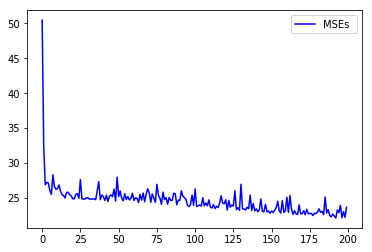

check point at 2019-04-25 13:48:43.635491
training : 西屯
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 10s - loss: 0.0026 - val_loss: 0.0014
Epoch : 0, MSE : [47.94783820617815]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 0.0012 - val_loss: 9.9383e-04
Epoch : 1, MSE : [32.27609790026475]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 0.0010 - val_loss: 9.1740e-04
Epoch : 2, MSE : [29.71175588402699]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 9.5731e-04 - val_loss: 9.0001e-04
Epoch : 3, MSE : [28.865263206419506]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 9.3268e-04 - val_loss: 9.5938e-04
Epoch : 4, MSE : [30.7672674157171]
-------------------------------------------
Train on 22074 samp

 - 6s - loss: 8.4923e-04 - val_loss: 8.7162e-04
Epoch : 43, MSE : [28.04050135867116]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.5045e-04 - val_loss: 8.4436e-04
Epoch : 44, MSE : [27.15596445265989]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.6073e-04 - val_loss: 8.5436e-04
Epoch : 45, MSE : [27.637991015842896]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.5279e-04 - val_loss: 8.4305e-04
Epoch : 46, MSE : [27.09668077928779]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.4593e-04 - val_loss: 8.3699e-04
Epoch : 47, MSE : [26.92579264599297]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.5236e-04 - val_loss: 8.6086e-04
Epoch 

Epoch : 86, MSE : [27.217943081466515]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.4821e-04 - val_loss: 8.5275e-04
Epoch : 87, MSE : [27.218859167782842]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.4306e-04 - val_loss: 8.4656e-04
Epoch : 88, MSE : [27.043171181482233]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.3608e-04 - val_loss: 8.5581e-04
Epoch : 89, MSE : [27.645803539885794]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.4113e-04 - val_loss: 8.5379e-04
Epoch : 90, MSE : [27.451088546620397]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.4194e-04 - val_loss: 8.8021e-04
Epoch : 91, MSE : [28.302026107255347]
-----------

 - 6s - loss: 8.3198e-04 - val_loss: 8.3791e-04
Epoch : 130, MSE : [26.82864936570921]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.2839e-04 - val_loss: 8.3820e-04
Epoch : 131, MSE : [26.952891172171835]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.2188e-04 - val_loss: 8.3103e-04
Epoch : 132, MSE : [26.61432434123516]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.2879e-04 - val_loss: 8.3498e-04
Epoch : 133, MSE : [26.76558786521535]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.3263e-04 - val_loss: 8.3413e-04
Epoch : 134, MSE : [26.663549563710443]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.2467e-04 - val_loss: 8.7033e-04


 - 6s - loss: 8.1559e-04 - val_loss: 8.2547e-04
Epoch : 173, MSE : [26.466553284535333]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.1518e-04 - val_loss: 8.2784e-04
Epoch : 174, MSE : [26.45232116417572]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.2085e-04 - val_loss: 8.2701e-04
Epoch : 175, MSE : [26.49022245711525]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.3029e-04 - val_loss: 8.6319e-04
Epoch : 176, MSE : [27.776650937948236]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.2204e-04 - val_loss: 8.3223e-04
Epoch : 177, MSE : [26.63555571317558]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 6s - loss: 8.2507e-04 - val_loss: 8.3111e-04


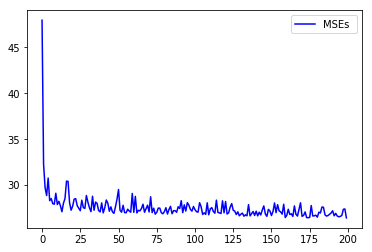

check point at 2019-04-25 14:12:27.484185
training : 豐原
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 8s - loss: 0.0024 - val_loss: 0.0014
Epoch : 0, MSE : [67.81775906147364]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 9.3785e-04
Epoch : 1, MSE : [46.468949816684486]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 9.7935e-04 - val_loss: 8.3628e-04
Epoch : 2, MSE : [41.51637040730035]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 9.5106e-04 - val_loss: 8.3584e-04
Epoch : 3, MSE : [41.64007536763224]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 9.3715e-04 - val_loss: 8.2203e-04
Epoch : 4, MSE : [41.07077748556068]
-------------------------------------------
Train on 14720 

 - 4s - loss: 8.1421e-04 - val_loss: 7.4711e-04
Epoch : 43, MSE : [36.981318109810054]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.3453e-04 - val_loss: 7.5917e-04
Epoch : 44, MSE : [37.486815520258155]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.2940e-04 - val_loss: 7.4501e-04
Epoch : 45, MSE : [37.02778807315161]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.2509e-04 - val_loss: 7.6234e-04
Epoch : 46, MSE : [37.72982739939225]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.1408e-04 - val_loss: 7.5188e-04
Epoch : 47, MSE : [37.14595930470513]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.3723e-04 - val_loss: 7.9459e-04
Epoch

 - 4s - loss: 8.1569e-04 - val_loss: 7.4488e-04
Epoch : 87, MSE : [36.56517899616102]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.0977e-04 - val_loss: 7.9750e-04
Epoch : 88, MSE : [39.07657656957481]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.1375e-04 - val_loss: 7.4040e-04
Epoch : 89, MSE : [36.50283792674087]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.2370e-04 - val_loss: 8.1273e-04
Epoch : 90, MSE : [39.85963572610798]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.0629e-04 - val_loss: 7.5132e-04
Epoch : 91, MSE : [37.06950698618476]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.1410e-04 - val_loss: 7.4965e-04
Epoch :

Epoch : 130, MSE : [36.86609073099812]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.1949e-04 - val_loss: 7.5216e-04
Epoch : 131, MSE : [36.772139396858776]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.1131e-04 - val_loss: 7.5920e-04
Epoch : 132, MSE : [37.277851232489496]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 7.9888e-04 - val_loss: 7.5350e-04
Epoch : 133, MSE : [36.78481178663522]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.0527e-04 - val_loss: 7.6853e-04
Epoch : 134, MSE : [37.420048227186214]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 8.0388e-04 - val_loss: 8.2168e-04
Epoch : 135, MSE : [39.88727471011358]
--------

 - 4s - loss: 8.0464e-04 - val_loss: 7.7686e-04
Epoch : 174, MSE : [37.96717081959995]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 7.9476e-04 - val_loss: 7.5849e-04
Epoch : 175, MSE : [36.999354730172314]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 7.9445e-04 - val_loss: 7.6772e-04
Epoch : 176, MSE : [37.38417621569768]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 7.9261e-04 - val_loss: 7.6614e-04
Epoch : 177, MSE : [37.16833034252564]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 7.9477e-04 - val_loss: 7.5442e-04
Epoch : 178, MSE : [36.79009537261435]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 4s - loss: 7.9367e-04 - val_loss: 7.4683e-04
E

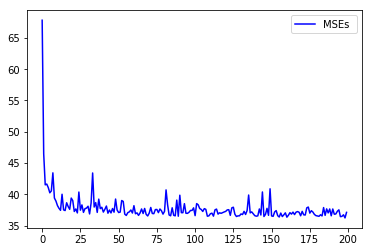

check point at 2019-04-25 14:28:32.460285
training : 三重
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 10s - loss: 0.0025 - val_loss: 0.0014
Epoch : 0, MSE : [36.50294122084978]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 0.0013 - val_loss: 0.0012
Epoch : 1, MSE : [30.573203770734604]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 0.0010
Epoch : 2, MSE : [26.48787692255288]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 0.0010
Epoch : 3, MSE : [26.053789322156995]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 0.0010 - val_loss: 0.0010
Epoch : 4, MSE : [26.666748683385414]
-------------------------------------------
Train on 22842 samples, validate on 5711

Epoch : 43, MSE : [25.321516119084283]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.6928e-04 - val_loss: 9.6631e-04
Epoch : 44, MSE : [24.66649401236587]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.6303e-04 - val_loss: 9.8322e-04
Epoch : 45, MSE : [25.261425395868475]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.6329e-04 - val_loss: 9.7705e-04
Epoch : 46, MSE : [25.012186626166496]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.5297e-04 - val_loss: 9.6135e-04
Epoch : 47, MSE : [24.518893368608893]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.5234e-04 - val_loss: 9.6813e-04
Epoch : 48, MSE : [24.815001065838644]
------------

 - 6s - loss: 9.5271e-04 - val_loss: 0.0010
Epoch : 87, MSE : [25.964251020444575]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4684e-04 - val_loss: 9.8125e-04
Epoch : 88, MSE : [24.95422390996957]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.6009e-04 - val_loss: 0.0010
Epoch : 89, MSE : [25.811015094272992]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4403e-04 - val_loss: 9.7803e-04
Epoch : 90, MSE : [25.086618713558728]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.5685e-04 - val_loss: 9.8550e-04
Epoch : 91, MSE : [25.197870813759877]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4884e-04 - val_loss: 9.6003e-04
Epoch : 92,

Epoch : 130, MSE : [24.61060944069947]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4662e-04 - val_loss: 9.6702e-04
Epoch : 131, MSE : [24.802856033131842]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.3735e-04 - val_loss: 9.8039e-04
Epoch : 132, MSE : [25.206314839460873]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.5407e-04 - val_loss: 9.7404e-04
Epoch : 133, MSE : [25.018107893087926]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4929e-04 - val_loss: 9.5744e-04
Epoch : 134, MSE : [24.465973457685365]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4569e-04 - val_loss: 9.6097e-04
Epoch : 135, MSE : [24.518800416897946]
------

 - 6s - loss: 9.4218e-04 - val_loss: 9.6538e-04
Epoch : 174, MSE : [24.745507286016274]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4404e-04 - val_loss: 9.6073e-04
Epoch : 175, MSE : [24.579298503624216]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.4660e-04 - val_loss: 9.5184e-04
Epoch : 176, MSE : [24.296954315133515]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.3311e-04 - val_loss: 9.6226e-04
Epoch : 177, MSE : [24.584941634819366]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.3839e-04 - val_loss: 9.6659e-04
Epoch : 178, MSE : [24.618774065516384]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 6s - loss: 9.3861e-04 - val_loss: 9.5203e-

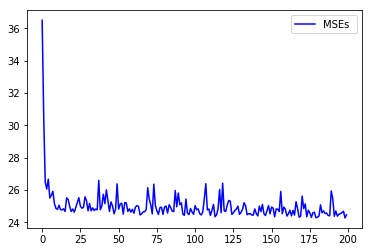

check point at 2019-04-25 14:53:03.649260
training : 中壢
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 11s - loss: 0.0023 - val_loss: 0.0012
Epoch : 0, MSE : [41.439223723934155]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 8.2522e-04
Epoch : 1, MSE : [28.186859993635554]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 9.5183e-04 - val_loss: 7.9757e-04
Epoch : 2, MSE : [27.027435749277224]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 8.9706e-04 - val_loss: 7.6777e-04
Epoch : 3, MSE : [26.114544473156442]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 8.5586e-04 - val_loss: 7.5487e-04
Epoch : 4, MSE : [25.563105828084083]
-------------------------------------------
Train on 2

 - 6s - loss: 7.9398e-04 - val_loss: 7.6689e-04
Epoch : 43, MSE : [26.246732970296556]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.8994e-04 - val_loss: 7.2756e-04
Epoch : 44, MSE : [24.694164680783864]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.8956e-04 - val_loss: 7.2022e-04
Epoch : 45, MSE : [24.586621713938708]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.9636e-04 - val_loss: 7.5592e-04
Epoch : 46, MSE : [25.727903679005024]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.9602e-04 - val_loss: 7.5226e-04
Epoch : 47, MSE : [25.748244823680224]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.8989e-04 - val_loss: 7.2820e-04
Ep

Epoch : 86, MSE : [24.937944927970992]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.8250e-04 - val_loss: 7.2398e-04
Epoch : 87, MSE : [24.574249824477565]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.7430e-04 - val_loss: 7.2864e-04
Epoch : 88, MSE : [24.872347483171726]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.8526e-04 - val_loss: 7.1330e-04
Epoch : 89, MSE : [24.21942846518417]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.8498e-04 - val_loss: 7.0934e-04
Epoch : 90, MSE : [24.069886073243158]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.7800e-04 - val_loss: 7.1353e-04
Epoch : 91, MSE : [24.177659030599113]
------------

 - 6s - loss: 7.6484e-04 - val_loss: 7.5000e-04
Epoch : 130, MSE : [25.49189899737799]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.7062e-04 - val_loss: 7.0746e-04
Epoch : 131, MSE : [23.99563096366183]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.6504e-04 - val_loss: 7.5351e-04
Epoch : 132, MSE : [25.59790187073176]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.6579e-04 - val_loss: 7.1840e-04
Epoch : 133, MSE : [24.300851079489185]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.7237e-04 - val_loss: 7.2000e-04
Epoch : 134, MSE : [24.39210728308579]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.6826e-04 - val_loss: 7.1221e-04
E

 - 6s - loss: 7.5716e-04 - val_loss: 7.1452e-04
Epoch : 173, MSE : [24.229468959686432]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.6246e-04 - val_loss: 7.1302e-04
Epoch : 174, MSE : [24.03553228459908]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.6326e-04 - val_loss: 7.2030e-04
Epoch : 175, MSE : [24.37717496414128]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.6100e-04 - val_loss: 7.1772e-04
Epoch : 176, MSE : [24.386642250453487]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.5858e-04 - val_loss: 7.2069e-04
Epoch : 177, MSE : [24.356550064341654]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 6s - loss: 7.6479e-04 - val_loss: 7.1927e-04

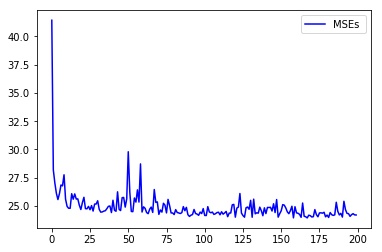

check point at 2019-04-25 15:17:52.946290
training : 中山
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 9s - loss: 0.0031 - val_loss: 0.0017
Epoch : 0, MSE : [44.04051171574182]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0016 - val_loss: 0.0012
Epoch : 1, MSE : [30.697821657340757]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0013 - val_loss: 0.0011
Epoch : 2, MSE : [28.018960923619886]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 0.0011
Epoch : 3, MSE : [28.55529937988726]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0012 - val_loss: 9.9779e-04
Epoch : 4, MSE : [25.967740987937955]
-------------------------------------------
Train on 15412 samples, validate on 3

 - 4s - loss: 0.0010 - val_loss: 9.4226e-04
Epoch : 44, MSE : [24.837522009557464]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 8.9749e-04
Epoch : 45, MSE : [23.717915526401285]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 9.2357e-04
Epoch : 46, MSE : [24.288450515819413]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 9.1864e-04
Epoch : 47, MSE : [24.387848392095087]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 9.3541e-04
Epoch : 48, MSE : [24.86272681879984]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 9.0122e-04
Epoch : 49, MSE : [23.90108

Epoch : 88, MSE : [23.887949291133065]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 8.9806e-04
Epoch : 89, MSE : [23.752254958091466]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 8.9568e-04
Epoch : 90, MSE : [23.626153996843083]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 9.1550e-04
Epoch : 91, MSE : [24.09590418026433]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 8.9558e-04
Epoch : 92, MSE : [23.74212084622544]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 0.0010 - val_loss: 9.7454e-04
Epoch : 93, MSE : [25.83799168171545]
----------------------------------

 - 4s - loss: 0.0010 - val_loss: 9.3624e-04
Epoch : 132, MSE : [24.656099391699605]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9923e-04 - val_loss: 9.1026e-04
Epoch : 133, MSE : [24.060216334052804]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9049e-04 - val_loss: 8.9691e-04
Epoch : 134, MSE : [23.70846364174739]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9451e-04 - val_loss: 9.0006e-04
Epoch : 135, MSE : [23.79406557728429]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9025e-04 - val_loss: 9.0806e-04
Epoch : 136, MSE : [23.85549410930765]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9359e-04 - val_loss: 8.9884e-04
Epoc

Epoch : 175, MSE : [23.638159173084897]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9254e-04 - val_loss: 9.0965e-04
Epoch : 176, MSE : [23.93421928251312]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.8067e-04 - val_loss: 8.9496e-04
Epoch : 177, MSE : [23.48883545608305]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9251e-04 - val_loss: 8.9905e-04
Epoch : 178, MSE : [23.670202517407077]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.9029e-04 - val_loss: 9.1386e-04
Epoch : 179, MSE : [23.90160540157959]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 4s - loss: 9.8568e-04 - val_loss: 8.9402e-04
Epoch : 180, MSE : [23.42499679801742]
---------

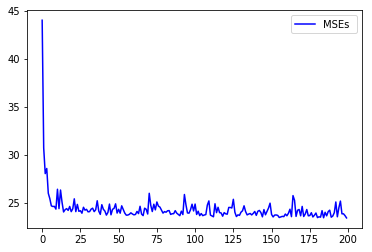

check point at 2019-04-25 15:35:13.885557
training : 古亭
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 11s - loss: 0.0024 - val_loss: 0.0012
Epoch : 0, MSE : [33.88735568487829]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 0.0012 - val_loss: 9.0179e-04
Epoch : 1, MSE : [26.21543345319224]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 8.4757e-04
Epoch : 2, MSE : [24.492461856746242]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 0.0010 - val_loss: 9.3075e-04
Epoch : 3, MSE : [26.282964250663344]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.9410e-04 - val_loss: 8.2832e-04
Epoch : 4, MSE : [23.910046017737095]
-------------------------------------------
Train on 22324 sampl

 - 6s - loss: 9.2522e-04 - val_loss: 8.0340e-04
Epoch : 43, MSE : [23.101602767100626]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.1977e-04 - val_loss: 7.9659e-04
Epoch : 44, MSE : [22.985534964817617]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.3050e-04 - val_loss: 7.9619e-04
Epoch : 45, MSE : [23.01480504703267]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.3833e-04 - val_loss: 8.1866e-04
Epoch : 46, MSE : [23.696236391717015]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.2435e-04 - val_loss: 7.9850e-04
Epoch : 47, MSE : [23.026622755476346]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.3424e-04 - val_loss: 8.7297e-04
Epo

Epoch : 86, MSE : [23.463349994439763]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.1435e-04 - val_loss: 7.9670e-04
Epoch : 87, MSE : [23.112781440959786]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.2027e-04 - val_loss: 8.1364e-04
Epoch : 88, MSE : [23.522307437791937]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0873e-04 - val_loss: 7.9524e-04
Epoch : 89, MSE : [23.027436185449645]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.1876e-04 - val_loss: 8.4212e-04
Epoch : 90, MSE : [24.115178185278705]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.1119e-04 - val_loss: 8.5065e-04
Epoch : 91, MSE : [24.3993608744328]
-------------

 - 6s - loss: 9.0897e-04 - val_loss: 8.1391e-04
Epoch : 130, MSE : [23.462210724367058]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0372e-04 - val_loss: 8.1204e-04
Epoch : 131, MSE : [23.31826695821303]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0084e-04 - val_loss: 7.9479e-04
Epoch : 132, MSE : [22.9125251405767]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.1791e-04 - val_loss: 8.2229e-04
Epoch : 133, MSE : [23.61428719715976]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0014e-04 - val_loss: 8.3065e-04
Epoch : 134, MSE : [23.83869138995533]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.1018e-04 - val_loss: 8.3011e-04
Ep

 - 6s - loss: 9.0678e-04 - val_loss: 7.8599e-04
Epoch : 173, MSE : [22.71917144417962]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.1176e-04 - val_loss: 8.0188e-04
Epoch : 174, MSE : [23.0925889179748]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0042e-04 - val_loss: 8.0915e-04
Epoch : 175, MSE : [23.247208432770364]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0805e-04 - val_loss: 8.0045e-04
Epoch : 176, MSE : [23.0490702385528]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0059e-04 - val_loss: 7.8585e-04
Epoch : 177, MSE : [22.697599704901418]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 6s - loss: 9.0138e-04 - val_loss: 7.8849e-04
Ep

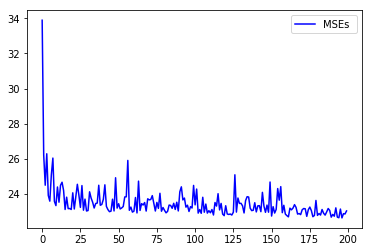

check point at 2019-04-25 16:00:40.211129
training : 土城
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 11s - loss: 0.0026 - val_loss: 0.0014
Epoch : 0, MSE : [31.062974133118793]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 0.0012 - val_loss: 7.7236e-04
Epoch : 1, MSE : [18.08456174271509]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 9.0456e-04 - val_loss: 7.4779e-04
Epoch : 2, MSE : [17.460121163338037]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 8.7253e-04 - val_loss: 7.2317e-04
Epoch : 3, MSE : [16.887926312714782]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 8.4200e-04 - val_loss: 7.1757e-04
Epoch : 4, MSE : [16.595370035731165]
-------------------------------------------
Train on 21

 - 6s - loss: 7.9132e-04 - val_loss: 7.2563e-04
Epoch : 43, MSE : [16.535453595231065]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.9970e-04 - val_loss: 7.0758e-04
Epoch : 44, MSE : [16.067096321862298]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.9865e-04 - val_loss: 7.1014e-04
Epoch : 45, MSE : [16.246434047580674]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.8604e-04 - val_loss: 7.4388e-04
Epoch : 46, MSE : [17.152220820781945]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.9895e-04 - val_loss: 7.0071e-04
Epoch : 47, MSE : [15.967467730912604]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.7772e-04 - val_loss: 7.0417e-04
Ep

Epoch : 86, MSE : [15.974526676523427]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.5946e-04 - val_loss: 6.7724e-04
Epoch : 87, MSE : [15.83062779701407]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.4904e-04 - val_loss: 6.5839e-04
Epoch : 88, MSE : [15.405747819568143]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.4479e-04 - val_loss: 6.6864e-04
Epoch : 89, MSE : [15.478334895881966]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.5878e-04 - val_loss: 6.9531e-04
Epoch : 90, MSE : [16.104200423716684]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.5323e-04 - val_loss: 6.6733e-04
Epoch : 91, MSE : [15.58804782695234]
-------------

Epoch : 129, MSE : [15.340232304778818]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.4062e-04 - val_loss: 6.5012e-04
Epoch : 130, MSE : [15.284012157095766]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.3085e-04 - val_loss: 6.5094e-04
Epoch : 131, MSE : [15.26608523848558]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.4757e-04 - val_loss: 6.5120e-04
Epoch : 132, MSE : [15.30763375783444]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.3438e-04 - val_loss: 6.7418e-04
Epoch : 133, MSE : [15.761772381625876]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.3898e-04 - val_loss: 6.6981e-04
Epoch : 134, MSE : [15.660016939575685]
-------

Epoch : 172, MSE : [15.48563984649971]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.3888e-04 - val_loss: 6.3475e-04
Epoch : 173, MSE : [15.016565872093068]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.3274e-04 - val_loss: 6.5859e-04
Epoch : 174, MSE : [15.467693661203782]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.2674e-04 - val_loss: 6.5481e-04
Epoch : 175, MSE : [15.500071350236988]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.3108e-04 - val_loss: 6.4816e-04
Epoch : 176, MSE : [15.188204161260089]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 6s - loss: 7.3071e-04 - val_loss: 6.3528e-04
Epoch : 177, MSE : [15.01236716694275]
-------

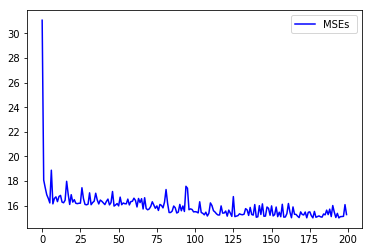

check point at 2019-04-25 16:25:46.178785
training : 基隆
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 11s - loss: 0.0015 - val_loss: 8.6169e-04
Epoch : 0, MSE : [27.01340494586211]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 8.6094e-04 - val_loss: 6.9896e-04
Epoch : 1, MSE : [22.006005656288085]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.8016e-04 - val_loss: 6.8188e-04
Epoch : 2, MSE : [21.439183481447152]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.7677e-04 - val_loss: 6.8964e-04
Epoch : 3, MSE : [21.607869552313993]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.7173e-04 - val_loss: 6.8466e-04
Epoch : 4, MSE : [21.489490666419538]
-------------------------------------------
Tra

 - 6s - loss: 7.3344e-04 - val_loss: 6.8860e-04
Epoch : 43, MSE : [21.55074510597805]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.3295e-04 - val_loss: 7.2005e-04
Epoch : 44, MSE : [22.546818996587877]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.3068e-04 - val_loss: 6.9795e-04
Epoch : 45, MSE : [21.739585995643555]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2811e-04 - val_loss: 6.8599e-04
Epoch : 46, MSE : [21.432888439835615]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.3073e-04 - val_loss: 6.8174e-04
Epoch : 47, MSE : [21.35731356599941]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2650e-04 - val_loss: 7.2368e-04
Epoc

Epoch : 86, MSE : [21.39495228038639]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2720e-04 - val_loss: 6.8597e-04
Epoch : 87, MSE : [21.37944884792127]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2397e-04 - val_loss: 7.0266e-04
Epoch : 88, MSE : [21.812805288182787]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2655e-04 - val_loss: 7.0641e-04
Epoch : 89, MSE : [22.05006936986559]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2152e-04 - val_loss: 6.9039e-04
Epoch : 90, MSE : [21.508154163795396]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2089e-04 - val_loss: 7.1085e-04
Epoch : 91, MSE : [22.11352230787583]
---------------

 - 6s - loss: 7.2402e-04 - val_loss: 6.8855e-04
Epoch : 130, MSE : [21.40383247039618]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2245e-04 - val_loss: 6.8935e-04
Epoch : 131, MSE : [21.438671766287793]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2856e-04 - val_loss: 6.8655e-04
Epoch : 132, MSE : [21.331221028343474]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.1320e-04 - val_loss: 7.1002e-04
Epoch : 133, MSE : [21.95092360585203]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.1326e-04 - val_loss: 6.9949e-04
Epoch : 134, MSE : [21.687623402312656]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2560e-04 - val_loss: 6.9736e-04

 - 6s - loss: 7.1422e-04 - val_loss: 6.9702e-04
Epoch : 173, MSE : [21.598900190714176]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.1919e-04 - val_loss: 7.0727e-04
Epoch : 174, MSE : [21.840721278957613]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.1891e-04 - val_loss: 6.9900e-04
Epoch : 175, MSE : [21.604905725664388]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.3050e-04 - val_loss: 6.9941e-04
Epoch : 176, MSE : [21.605180357834804]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.1759e-04 - val_loss: 6.9000e-04
Epoch : 177, MSE : [21.3695818467253]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 6s - loss: 7.2038e-04 - val_loss: 6.9241e-04

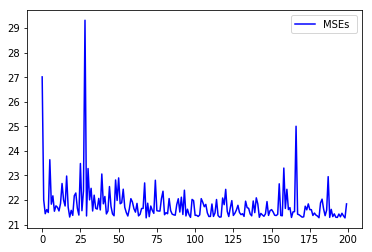

check point at 2019-04-25 16:50:32.788503
training : 士林
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 11s - loss: 0.0022 - val_loss: 0.0014
Epoch : 0, MSE : [38.563367870066685]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 0.0011 - val_loss: 8.6853e-04
Epoch : 1, MSE : [24.518477466292314]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 9.6348e-04 - val_loss: 8.4695e-04
Epoch : 2, MSE : [23.885701273182043]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 9.4298e-04 - val_loss: 8.4616e-04
Epoch : 3, MSE : [23.889899408758435]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 9.2505e-04 - val_loss: 8.1900e-04
Epoch : 4, MSE : [23.141831596539962]
-------------------------------------------
Train on 1

 - 5s - loss: 8.1057e-04 - val_loss: 7.4315e-04
Epoch : 43, MSE : [21.299976269722702]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.0778e-04 - val_loss: 7.4494e-04
Epoch : 44, MSE : [21.39870253453095]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.1395e-04 - val_loss: 7.5800e-04
Epoch : 45, MSE : [21.8983204693586]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.1146e-04 - val_loss: 7.5085e-04
Epoch : 46, MSE : [21.61758764222244]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.2552e-04 - val_loss: 8.2621e-04
Epoch : 47, MSE : [23.889192900504156]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.1290e-04 - val_loss: 7.7182e-04
Epoch 

Epoch : 86, MSE : [21.901354801115286]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.1039e-04 - val_loss: 7.6043e-04
Epoch : 87, MSE : [21.898591594767407]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.0309e-04 - val_loss: 7.4668e-04
Epoch : 88, MSE : [21.381174748728043]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.0631e-04 - val_loss: 7.3742e-04
Epoch : 89, MSE : [21.276295937774595]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.0426e-04 - val_loss: 7.5910e-04
Epoch : 90, MSE : [21.874984413595858]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 8.0558e-04 - val_loss: 7.4387e-04
Epoch : 91, MSE : [21.31427013494594]
------------

 - 5s - loss: 7.9768e-04 - val_loss: 7.3357e-04
Epoch : 130, MSE : [21.11244622204614]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.9698e-04 - val_loss: 7.6742e-04
Epoch : 131, MSE : [22.020399298328783]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.9242e-04 - val_loss: 7.4503e-04
Epoch : 132, MSE : [21.387331449331032]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.9743e-04 - val_loss: 7.3540e-04
Epoch : 133, MSE : [21.121859992980305]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.9983e-04 - val_loss: 7.5587e-04
Epoch : 134, MSE : [21.83306587352952]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.9620e-04 - val_loss: 7.3186e-04

 - 5s - loss: 7.8903e-04 - val_loss: 7.3373e-04
Epoch : 173, MSE : [21.049796758104186]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.8384e-04 - val_loss: 7.4134e-04
Epoch : 174, MSE : [21.235191018373403]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.8991e-04 - val_loss: 7.3316e-04
Epoch : 175, MSE : [20.99608878392436]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 6s - loss: 7.9498e-04 - val_loss: 7.3202e-04
Epoch : 176, MSE : [20.934927243968783]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.8294e-04 - val_loss: 7.5075e-04
Epoch : 177, MSE : [21.540409096808418]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 5s - loss: 7.8946e-04 - val_loss: 7.6260e-0

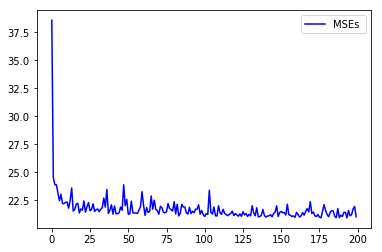

check point at 2019-04-25 17:12:07.677904
training : 大同
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 13s - loss: 0.0023 - val_loss: 0.0013
Epoch : 0, MSE : [38.88061931490734]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 0.0012 - val_loss: 9.7807e-04
Epoch : 1, MSE : [29.010605052085626]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 9.4413e-04
Epoch : 2, MSE : [27.969839458822417]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 0.0010 - val_loss: 0.0010
Epoch : 3, MSE : [29.39046092788342]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 0.0010 - val_loss: 9.5636e-04
Epoch : 4, MSE : [28.58202240036523]
-------------------------------------------
Train on 22708 samples, valid

 - 6s - loss: 9.3829e-04 - val_loss: 8.7424e-04
Epoch : 43, MSE : [25.84521170888627]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.4031e-04 - val_loss: 8.8187e-04
Epoch : 44, MSE : [25.77256571796816]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.2555e-04 - val_loss: 8.6850e-04
Epoch : 45, MSE : [25.658196798104317]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.4023e-04 - val_loss: 8.6152e-04
Epoch : 46, MSE : [25.2519730900904]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.4075e-04 - val_loss: 9.4236e-04
Epoch : 47, MSE : [27.12287336486835]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.4523e-04 - val_loss: 8.9729e-04
Epoch :

Epoch : 86, MSE : [25.244637780629976]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1830e-04 - val_loss: 8.5921e-04
Epoch : 87, MSE : [25.289006642993993]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.3246e-04 - val_loss: 8.8146e-04
Epoch : 88, MSE : [25.64310828552217]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.3075e-04 - val_loss: 8.6073e-04
Epoch : 89, MSE : [25.275959629779997]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1536e-04 - val_loss: 8.7780e-04
Epoch : 90, MSE : [25.63949425092573]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1873e-04 - val_loss: 8.5389e-04
Epoch : 91, MSE : [25.09200214425359]
--------------

 - 6s - loss: 9.1485e-04 - val_loss: 8.5609e-04
Epoch : 130, MSE : [25.074446401748247]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1296e-04 - val_loss: 8.5744e-04
Epoch : 131, MSE : [25.121882541820106]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1550e-04 - val_loss: 8.5794e-04
Epoch : 132, MSE : [25.248762633136245]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.2177e-04 - val_loss: 8.7667e-04
Epoch : 133, MSE : [25.78414133291445]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.2131e-04 - val_loss: 8.6974e-04
Epoch : 134, MSE : [25.38367464518308]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.2120e-04 - val_loss: 8.5729e-04

 - 6s - loss: 9.1207e-04 - val_loss: 8.6442e-04
Epoch : 173, MSE : [25.41894650906896]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.2467e-04 - val_loss: 8.6018e-04
Epoch : 174, MSE : [25.111549042389505]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1221e-04 - val_loss: 8.5752e-04
Epoch : 175, MSE : [25.050488202066234]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.0345e-04 - val_loss: 8.7537e-04
Epoch : 176, MSE : [25.636717619853346]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1469e-04 - val_loss: 8.5868e-04
Epoch : 177, MSE : [25.14481021533665]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 6s - loss: 9.1240e-04 - val_loss: 8.6767e-04

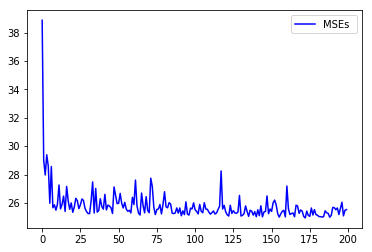

check point at 2019-04-25 17:38:41.389153
training : 大園
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 12s - loss: 0.0017 - val_loss: 9.5734e-04
Epoch : 0, MSE : [45.430024001971]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 8.8623e-04 - val_loss: 6.3034e-04
Epoch : 1, MSE : [30.621834885104345]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 7.5092e-04 - val_loss: 5.9958e-04
Epoch : 2, MSE : [29.10385029501875]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 7.2597e-04 - val_loss: 5.7691e-04
Epoch : 3, MSE : [27.910996923575272]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.9835e-04 - val_loss: 5.5367e-04
Epoch : 4, MSE : [27.028053866301757]
-------------------------------------------
Train 

 - 6s - loss: 6.2965e-04 - val_loss: 5.4779e-04
Epoch : 43, MSE : [26.134691642137895]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.2045e-04 - val_loss: 5.4250e-04
Epoch : 44, MSE : [25.821444780764317]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.2981e-04 - val_loss: 5.3719e-04
Epoch : 45, MSE : [25.638967409745614]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.2756e-04 - val_loss: 5.4003e-04
Epoch : 46, MSE : [25.64655653329792]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.2998e-04 - val_loss: 5.4447e-04
Epoch : 47, MSE : [26.109410006244072]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.2627e-04 - val_loss: 6.1509e-04
Epo

Epoch : 86, MSE : [25.69560674793049]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1369e-04 - val_loss: 5.3510e-04
Epoch : 87, MSE : [25.456189480812792]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1540e-04 - val_loss: 5.2988e-04
Epoch : 88, MSE : [25.47834053603135]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1904e-04 - val_loss: 5.4838e-04
Epoch : 89, MSE : [25.835800202559934]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1453e-04 - val_loss: 5.3653e-04
Epoch : 90, MSE : [25.51503598787383]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1884e-04 - val_loss: 5.5340e-04
Epoch : 91, MSE : [26.43810070964876]
---------------

 - 6s - loss: 6.1386e-04 - val_loss: 5.3817e-04
Epoch : 130, MSE : [25.679299312428206]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.0892e-04 - val_loss: 5.3997e-04
Epoch : 131, MSE : [25.69915783194714]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1052e-04 - val_loss: 5.2509e-04
Epoch : 132, MSE : [25.192503856016398]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.0568e-04 - val_loss: 5.2901e-04
Epoch : 133, MSE : [25.296581160092924]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1277e-04 - val_loss: 5.2408e-04
Epoch : 134, MSE : [25.333764552603395]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.0788e-04 - val_loss: 5.3783e-0

 - 6s - loss: 6.0500e-04 - val_loss: 5.3462e-04
Epoch : 173, MSE : [25.423216409934263]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.0307e-04 - val_loss: 5.3805e-04
Epoch : 174, MSE : [25.387351459350413]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.0268e-04 - val_loss: 5.2434e-04
Epoch : 175, MSE : [25.120197892360455]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.0579e-04 - val_loss: 5.3294e-04
Epoch : 176, MSE : [25.288816996959994]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.0880e-04 - val_loss: 5.3340e-04
Epoch : 177, MSE : [25.402768640697534]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 6s - loss: 6.1021e-04 - val_loss: 5.2459e-

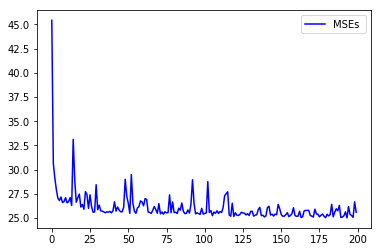

check point at 2019-04-25 18:04:49.215213
training : 平鎮
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 13s - loss: 0.0017 - val_loss: 9.0774e-04
Epoch : 0, MSE : [38.91262221401052]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 8.9266e-04 - val_loss: 6.8932e-04
Epoch : 1, MSE : [29.252452821007157]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 7.8787e-04 - val_loss: 6.6450e-04
Epoch : 2, MSE : [28.519812176050326]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 7.2059e-04 - val_loss: 6.7380e-04
Epoch : 3, MSE : [28.82146721910791]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 7.2023e-04 - val_loss: 6.1581e-04
Epoch : 4, MSE : [26.396155781271744]
-------------------------------------------
Trai

 - 7s - loss: 6.3745e-04 - val_loss: 5.8405e-04
Epoch : 43, MSE : [25.161266958067635]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.4595e-04 - val_loss: 5.8788e-04
Epoch : 44, MSE : [25.2640608971108]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.3780e-04 - val_loss: 5.7382e-04
Epoch : 45, MSE : [24.646199019469023]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.3643e-04 - val_loss: 5.7157e-04
Epoch : 46, MSE : [24.531404096368743]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.4061e-04 - val_loss: 5.8680e-04
Epoch : 47, MSE : [25.22452879532575]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.4851e-04 - val_loss: 5.8341e-04
Epoch

Epoch : 86, MSE : [24.564159862491344]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2887e-04 - val_loss: 5.6979e-04
Epoch : 87, MSE : [24.502851404851828]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2870e-04 - val_loss: 5.8794e-04
Epoch : 88, MSE : [25.541215509524864]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.3147e-04 - val_loss: 5.7859e-04
Epoch : 89, MSE : [24.774764597031307]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.3887e-04 - val_loss: 5.8382e-04
Epoch : 90, MSE : [24.74406395477893]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.4044e-04 - val_loss: 5.7516e-04
Epoch : 91, MSE : [24.68415818748843]
-------------

 - 7s - loss: 6.2264e-04 - val_loss: 5.6116e-04
Epoch : 130, MSE : [24.246332184427327]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2433e-04 - val_loss: 5.6613e-04
Epoch : 131, MSE : [24.310383239249973]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2128e-04 - val_loss: 5.5975e-04
Epoch : 132, MSE : [24.0696006545403]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2449e-04 - val_loss: 5.7270e-04
Epoch : 133, MSE : [24.45501765446405]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2237e-04 - val_loss: 5.5903e-04
Epoch : 134, MSE : [23.98292205801102]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.1736e-04 - val_loss: 5.7123e-04
E

Epoch : 173, MSE : [23.966312259187344]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.1924e-04 - val_loss: 5.6725e-04
Epoch : 174, MSE : [24.295351204359033]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2139e-04 - val_loss: 5.7373e-04
Epoch : 175, MSE : [24.460912020500075]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.1962e-04 - val_loss: 5.6281e-04
Epoch : 176, MSE : [24.080180999105796]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.1861e-04 - val_loss: 5.6607e-04
Epoch : 177, MSE : [24.272191028023197]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 7s - loss: 6.2153e-04 - val_loss: 5.6425e-04
Epoch : 178, MSE : [24.102616903125437]
-----

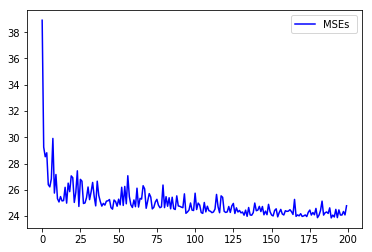

check point at 2019-04-25 18:32:54.076013
training : 新店
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 14s - loss: 0.0023 - val_loss: 0.0012
Epoch : 0, MSE : [24.098642354906023]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 9.9928e-04 - val_loss: 6.4950e-04
Epoch : 1, MSE : [13.822492190297098]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 7.7918e-04 - val_loss: 6.1773e-04
Epoch : 2, MSE : [13.40900363907097]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 7.2493e-04 - val_loss: 6.3067e-04
Epoch : 3, MSE : [13.61613586415607]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 7.1360e-04 - val_loss: 6.2638e-04
Epoch : 4, MSE : [13.521374180558784]
-------------------------------------------
Train on

 - 7s - loss: 6.7314e-04 - val_loss: 6.3504e-04
Epoch : 43, MSE : [13.43054957414693]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.6866e-04 - val_loss: 6.3751e-04
Epoch : 44, MSE : [13.509712976883225]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.6990e-04 - val_loss: 5.8803e-04
Epoch : 45, MSE : [12.592374738870335]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.6946e-04 - val_loss: 5.8790e-04
Epoch : 46, MSE : [12.59125556748581]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.6663e-04 - val_loss: 5.7248e-04
Epoch : 47, MSE : [12.220337978303451]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.5950e-04 - val_loss: 5.7807e-04
Epoc

Epoch : 86, MSE : [12.038535976593428]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.3333e-04 - val_loss: 5.8318e-04
Epoch : 87, MSE : [11.998919938062711]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.4060e-04 - val_loss: 5.7270e-04
Epoch : 88, MSE : [12.01985051430629]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.3347e-04 - val_loss: 5.6576e-04
Epoch : 89, MSE : [11.828190635224077]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.3126e-04 - val_loss: 5.7267e-04
Epoch : 90, MSE : [11.955353365125891]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.3069e-04 - val_loss: 5.7847e-04
Epoch : 91, MSE : [11.902457022462904]
------------

 - 7s - loss: 6.2575e-04 - val_loss: 6.1676e-04
Epoch : 130, MSE : [12.50085919692206]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.1700e-04 - val_loss: 5.8460e-04
Epoch : 131, MSE : [11.890370590243311]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.2399e-04 - val_loss: 5.9052e-04
Epoch : 132, MSE : [11.913831408572177]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.2688e-04 - val_loss: 5.8022e-04
Epoch : 133, MSE : [11.838676699385347]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.1665e-04 - val_loss: 6.2736e-04
Epoch : 134, MSE : [12.621874336369176]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.2665e-04 - val_loss: 5.8188e-0

 - 7s - loss: 6.2422e-04 - val_loss: 6.4974e-04
Epoch : 173, MSE : [13.077723910185792]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.1968e-04 - val_loss: 5.9090e-04
Epoch : 174, MSE : [11.972212242459355]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.1874e-04 - val_loss: 5.7920e-04
Epoch : 175, MSE : [11.749178265264685]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.1239e-04 - val_loss: 6.1686e-04
Epoch : 176, MSE : [12.433314082496363]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.2524e-04 - val_loss: 6.4448e-04
Epoch : 177, MSE : [12.893837691991099]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 7s - loss: 6.1652e-04 - val_loss: 6.0435e-

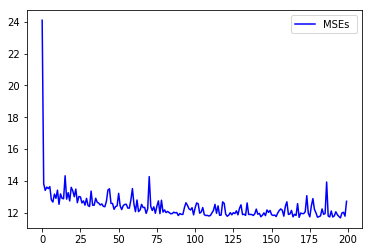

check point at 2019-04-25 19:01:51.952388
training : 新莊
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 13s - loss: 0.0028 - val_loss: 0.0013
Epoch : 0, MSE : [33.68561166366914]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 0.0012 - val_loss: 7.8070e-04
Epoch : 1, MSE : [19.63637949360401]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 9.3663e-04 - val_loss: 7.1689e-04
Epoch : 2, MSE : [18.343195598125387]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 8.7754e-04 - val_loss: 7.0984e-04
Epoch : 3, MSE : [18.11016876008245]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 8.4966e-04 - val_loss: 7.3310e-04
Epoch : 4, MSE : [18.463184564590243]
-------------------------------------------
Train on 1990

 - 6s - loss: 7.9192e-04 - val_loss: 7.3018e-04
Epoch : 43, MSE : [18.880785974504416]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 8.0277e-04 - val_loss: 6.9574e-04
Epoch : 44, MSE : [17.566508495496226]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.9424e-04 - val_loss: 7.1408e-04
Epoch : 45, MSE : [17.843157727908764]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.9241e-04 - val_loss: 7.1709e-04
Epoch : 46, MSE : [17.927149166865266]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 8.0472e-04 - val_loss: 6.9249e-04
Epoch : 47, MSE : [17.5866032355831]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 8.0006e-04 - val_loss: 6.9569e-04
Epoc

Epoch : 86, MSE : [16.759938613731578]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.7139e-04 - val_loss: 6.7327e-04
Epoch : 87, MSE : [16.83308983458513]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.5576e-04 - val_loss: 7.1744e-04
Epoch : 88, MSE : [17.71270158160453]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.5359e-04 - val_loss: 6.7300e-04
Epoch : 89, MSE : [16.913151934472985]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.5960e-04 - val_loss: 6.6552e-04
Epoch : 90, MSE : [16.673801660854902]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.5465e-04 - val_loss: 6.8110e-04
Epoch : 91, MSE : [16.947852723075506]
-------------

 - 6s - loss: 7.4131e-04 - val_loss: 7.3003e-04
Epoch : 130, MSE : [17.799412224646943]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.3709e-04 - val_loss: 6.6539e-04
Epoch : 131, MSE : [16.655254838540063]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.4187e-04 - val_loss: 6.6249e-04
Epoch : 132, MSE : [16.481495731433476]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.4005e-04 - val_loss: 6.6850e-04
Epoch : 133, MSE : [16.664974831746314]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.4241e-04 - val_loss: 6.6878e-04
Epoch : 134, MSE : [16.748477461373426]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.3519e-04 - val_loss: 7.0468e-

 - 6s - loss: 7.3846e-04 - val_loss: 6.8770e-04
Epoch : 173, MSE : [16.83049624517604]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.4693e-04 - val_loss: 6.5989e-04
Epoch : 174, MSE : [16.418596843109217]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.2853e-04 - val_loss: 6.6645e-04
Epoch : 175, MSE : [16.411497394516193]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.3953e-04 - val_loss: 6.6608e-04
Epoch : 176, MSE : [16.621730776086128]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.4134e-04 - val_loss: 6.5880e-04
Epoch : 177, MSE : [16.454425105633486]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 6s - loss: 7.4436e-04 - val_loss: 6.7167e-0

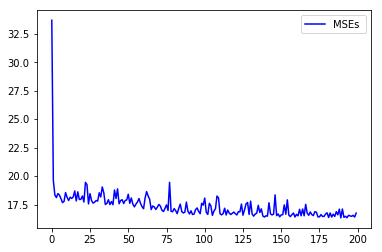

check point at 2019-04-25 19:27:13.668903
training : 松山
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 13s - loss: 0.0027 - val_loss: 0.0015
Epoch : 0, MSE : [40.06959821595484]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 0.0014 - val_loss: 0.0012
Epoch : 1, MSE : [29.596399922227327]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 0.0012 - val_loss: 0.0011
Epoch : 2, MSE : [26.98538140011922]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 0.0011
Epoch : 3, MSE : [26.600216674745845]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 0.0012
Epoch : 4, MSE : [28.244352997837915]
-------------------------------------------
Train on 18311 samples, validate on 4578

 - 6s - loss: 9.7573e-04 - val_loss: 9.8401e-04
Epoch : 44, MSE : [24.093673478345185]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 9.6604e-04 - val_loss: 0.0010
Epoch : 45, MSE : [24.716336465342437]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 9.6756e-04 - val_loss: 9.8995e-04
Epoch : 46, MSE : [24.27551853984465]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 9.6938e-04 - val_loss: 9.8866e-04
Epoch : 47, MSE : [24.28233375685833]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 9.7822e-04 - val_loss: 9.9154e-04
Epoch : 48, MSE : [24.358895005369934]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 6s - loss: 9.7188e-04 - val_loss: 9.9374e-04
Epoch : 

 - 5s - loss: 9.5279e-04 - val_loss: 0.0010
Epoch : 88, MSE : [24.231930300059297]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.5493e-04 - val_loss: 0.0010
Epoch : 89, MSE : [24.982010269363514]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.5437e-04 - val_loss: 0.0010
Epoch : 90, MSE : [24.434090790408483]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.5559e-04 - val_loss: 0.0010
Epoch : 91, MSE : [24.42598008341297]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.7052e-04 - val_loss: 0.0011
Epoch : 92, MSE : [26.57799262347522]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.5400e-04 - val_loss: 0.0010
Epoch : 93, MSE : [24.498285

 - 5s - loss: 9.3928e-04 - val_loss: 0.0010
Epoch : 132, MSE : [24.058537672165745]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.4219e-04 - val_loss: 0.0010
Epoch : 133, MSE : [25.617098705905466]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.4346e-04 - val_loss: 9.9995e-04
Epoch : 134, MSE : [23.95873553690697]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.4634e-04 - val_loss: 9.8056e-04
Epoch : 135, MSE : [23.741821179542033]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.4312e-04 - val_loss: 9.9161e-04
Epoch : 136, MSE : [23.8563047893977]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.4134e-04 - val_loss: 0.0010
Epoch : 137,

 - 5s - loss: 9.4085e-04 - val_loss: 0.0010
Epoch : 176, MSE : [23.973038395978726]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.3051e-04 - val_loss: 9.9205e-04
Epoch : 177, MSE : [23.804773597189094]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.3845e-04 - val_loss: 0.0010
Epoch : 178, MSE : [25.43265499576806]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.3853e-04 - val_loss: 9.7858e-04
Epoch : 179, MSE : [23.92905108290639]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.3308e-04 - val_loss: 0.0010
Epoch : 180, MSE : [24.55479020420934]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 5s - loss: 9.3969e-04 - val_loss: 0.0010
Epoch : 181, MSE

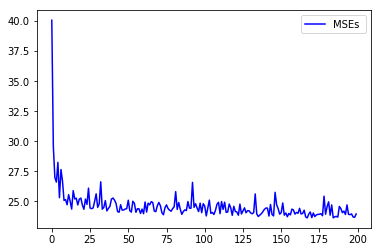

check point at 2019-04-25 19:49:29.862433
training : 板橋
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 12s - loss: 0.0025 - val_loss: 0.0012
Epoch : 0, MSE : [33.30452789391915]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 0.0011 - val_loss: 6.8893e-04
Epoch : 1, MSE : [18.520894668896457]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 8.2129e-04 - val_loss: 6.5117e-04
Epoch : 2, MSE : [17.6004532372301]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 8.1611e-04 - val_loss: 6.6001e-04
Epoch : 3, MSE : [17.93989250906204]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 7.8461e-04 - val_loss: 6.5307e-04
Epoch : 4, MSE : [17.695067908981805]
-------------------------------------------
Train on 21882

 - 6s - loss: 7.1742e-04 - val_loss: 6.3801e-04
Epoch : 43, MSE : [17.251180172984583]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 7.2042e-04 - val_loss: 6.2191e-04
Epoch : 44, MSE : [16.852961005560992]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 7.1845e-04 - val_loss: 6.5060e-04
Epoch : 45, MSE : [17.527335981046054]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 7.2102e-04 - val_loss: 6.2352e-04
Epoch : 46, MSE : [16.808096161574532]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 7.2135e-04 - val_loss: 6.8606e-04
Epoch : 47, MSE : [18.434939359676235]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 7.1809e-04 - val_loss: 6.2800e-04
Ep

Epoch : 86, MSE : [16.06401501210858]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.7867e-04 - val_loss: 6.2429e-04
Epoch : 87, MSE : [16.487450714255207]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.7972e-04 - val_loss: 6.2341e-04
Epoch : 88, MSE : [16.586101447160893]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.8580e-04 - val_loss: 5.9954e-04
Epoch : 89, MSE : [15.906142677352081]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.8966e-04 - val_loss: 6.3616e-04
Epoch : 90, MSE : [17.02887214966386]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.8964e-04 - val_loss: 6.0703e-04
Epoch : 91, MSE : [16.13947188886837]
--------------

 - 6s - loss: 6.6733e-04 - val_loss: 6.0119e-04
Epoch : 130, MSE : [15.783647879607885]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6223e-04 - val_loss: 6.0256e-04
Epoch : 131, MSE : [15.832639253229418]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6861e-04 - val_loss: 6.2294e-04
Epoch : 132, MSE : [16.34252304052822]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6539e-04 - val_loss: 6.0023e-04
Epoch : 133, MSE : [15.792539060656775]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6368e-04 - val_loss: 6.3681e-04
Epoch : 134, MSE : [16.69879563337341]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6490e-04 - val_loss: 6.5543e-04

 - 6s - loss: 6.6447e-04 - val_loss: 6.3793e-04
Epoch : 173, MSE : [16.752301712234704]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6483e-04 - val_loss: 6.0845e-04
Epoch : 174, MSE : [15.86580933228755]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.7085e-04 - val_loss: 6.0410e-04
Epoch : 175, MSE : [15.742539339504043]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6675e-04 - val_loss: 6.1116e-04
Epoch : 176, MSE : [16.01177375663162]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.5580e-04 - val_loss: 6.1007e-04
Epoch : 177, MSE : [15.930491782551224]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 6s - loss: 6.6060e-04 - val_loss: 6.0371e-04

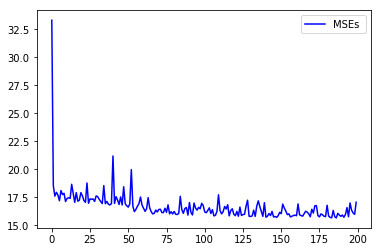

check point at 2019-04-25 20:15:06.967102
training : 林口
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 13s - loss: 0.0019 - val_loss: 9.4993e-04
Epoch : 0, MSE : [29.05467564639395]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 8.1812e-04 - val_loss: 5.9334e-04
Epoch : 1, MSE : [17.778565888157498]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 6.5508e-04 - val_loss: 5.5266e-04
Epoch : 2, MSE : [16.596644180999835]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 6.2580e-04 - val_loss: 5.5895e-04
Epoch : 3, MSE : [17.032813585273317]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 6.1372e-04 - val_loss: 5.4318e-04
Epoch : 4, MSE : [16.656378880700604]
-------------------------------------------
Tra

 - 6s - loss: 5.8370e-04 - val_loss: 5.4526e-04
Epoch : 43, MSE : [16.275379453785625]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 5.8140e-04 - val_loss: 5.4248e-04
Epoch : 44, MSE : [16.185887931367336]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 5.8038e-04 - val_loss: 5.3692e-04
Epoch : 45, MSE : [16.09714918833166]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 5.8322e-04 - val_loss: 5.3896e-04
Epoch : 46, MSE : [16.12916135183195]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 5.8069e-04 - val_loss: 5.5126e-04
Epoch : 47, MSE : [16.594206908132822]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 5.7181e-04 - val_loss: 5.4160e-04
Epoc

Epoch : 86, MSE : [16.93971463819393]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.6517e-04 - val_loss: 5.3422e-04
Epoch : 87, MSE : [15.836573452456118]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4999e-04 - val_loss: 5.3067e-04
Epoch : 88, MSE : [16.004494416173024]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.6081e-04 - val_loss: 5.6430e-04
Epoch : 89, MSE : [16.97240481688004]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.6440e-04 - val_loss: 5.3740e-04
Epoch : 90, MSE : [16.19740868773825]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 5.6080e-04 - val_loss: 5.8190e-04
Epoch : 91, MSE : [16.992721666759802]
--------------

 - 7s - loss: 5.5595e-04 - val_loss: 5.3080e-04
Epoch : 130, MSE : [15.738431937891113]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4869e-04 - val_loss: 5.3475e-04
Epoch : 131, MSE : [16.145798586793266]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4988e-04 - val_loss: 5.4283e-04
Epoch : 132, MSE : [15.964769670274793]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4880e-04 - val_loss: 5.2803e-04
Epoch : 133, MSE : [15.675616356062294]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4983e-04 - val_loss: 5.6355e-04
Epoch : 134, MSE : [16.412049455196982]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4916e-04 - val_loss: 5.5862e-

 - 7s - loss: 5.4080e-04 - val_loss: 5.2838e-04
Epoch : 173, MSE : [15.68395541686801]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4191e-04 - val_loss: 5.3533e-04
Epoch : 174, MSE : [16.00645727914747]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.5158e-04 - val_loss: 5.3181e-04
Epoch : 175, MSE : [15.625832629965114]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4733e-04 - val_loss: 5.4011e-04
Epoch : 176, MSE : [15.758354722689862]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 5.4319e-04 - val_loss: 5.4148e-04
Epoch : 177, MSE : [16.077158497325456]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 6s - loss: 5.5094e-04 - val_loss: 5.3477e-04

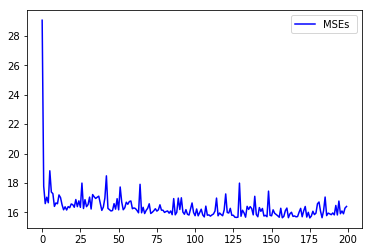

check point at 2019-04-25 20:42:49.541390
training : 桃園
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 14s - loss: 0.0025 - val_loss: 0.0013
Epoch : 0, MSE : [37.2312468899287]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 0.0012 - val_loss: 0.0010
Epoch : 1, MSE : [29.272475738619057]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 0.0011 - val_loss: 9.7932e-04
Epoch : 2, MSE : [28.16067484836485]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 0.0011 - val_loss: 0.0010
Epoch : 3, MSE : [30.17661692034833]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 8.9082e-04
Epoch : 4, MSE : [25.921047003461076]
-------------------------------------------
Train on 21767 samples, validate o

 - 9s - loss: 9.3072e-04 - val_loss: 8.4527e-04
Epoch : 43, MSE : [24.64777843805897]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.3225e-04 - val_loss: 8.3262e-04
Epoch : 44, MSE : [24.37993114574793]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.1863e-04 - val_loss: 8.5259e-04
Epoch : 45, MSE : [25.020641243479236]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.1660e-04 - val_loss: 8.5266e-04
Epoch : 46, MSE : [24.935622759389087]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.2759e-04 - val_loss: 8.4473e-04
Epoch : 47, MSE : [24.628584861705587]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.2167e-04 - val_loss: 8.7106e-04
Epoc

Epoch : 86, MSE : [24.901449020538966]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.0570e-04 - val_loss: 8.4260e-04
Epoch : 87, MSE : [24.58932841516719]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.0588e-04 - val_loss: 8.5255e-04
Epoch : 88, MSE : [24.99698026020364]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.1064e-04 - val_loss: 8.6049e-04
Epoch : 89, MSE : [25.15354198019553]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.1890e-04 - val_loss: 8.5361e-04
Epoch : 90, MSE : [24.944313800054815]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.1118e-04 - val_loss: 8.5512e-04
Epoch : 91, MSE : [24.968352528448033]
--------------

 - 8s - loss: 9.0084e-04 - val_loss: 8.3877e-04
Epoch : 130, MSE : [24.45494245046086]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.0230e-04 - val_loss: 8.3113e-04
Epoch : 131, MSE : [24.185278313069148]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 9.0518e-04 - val_loss: 8.7695e-04
Epoch : 132, MSE : [25.58318592811122]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.0102e-04 - val_loss: 8.3431e-04
Epoch : 133, MSE : [24.352748728446212]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 8.9639e-04 - val_loss: 8.3509e-04
Epoch : 134, MSE : [24.38789152649298]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 8s - loss: 9.1077e-04 - val_loss: 8.4501e-04


 - 7s - loss: 8.9653e-04 - val_loss: 8.4269e-04
Epoch : 173, MSE : [24.545893220218186]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 8.9514e-04 - val_loss: 8.3919e-04
Epoch : 174, MSE : [24.280672897812746]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 8.9220e-04 - val_loss: 8.2923e-04
Epoch : 175, MSE : [24.052280470296125]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 9.0384e-04 - val_loss: 8.2800e-04
Epoch : 176, MSE : [24.04176129671468]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 8.8893e-04 - val_loss: 8.4408e-04
Epoch : 177, MSE : [24.59927040137777]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 7s - loss: 8.9548e-04 - val_loss: 8.4083e-04

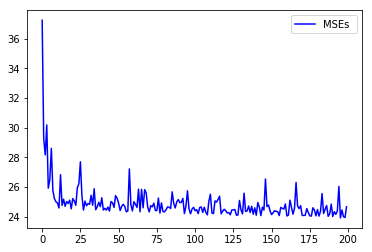

check point at 2019-04-25 21:14:39.515100
training : 永和
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 16s - loss: 0.0020 - val_loss: 8.6978e-04
Epoch : 0, MSE : [25.799492444024875]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 10s - loss: 8.7865e-04 - val_loss: 5.3572e-04
Epoch : 1, MSE : [15.964232757184268]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 6.8009e-04 - val_loss: 4.8412e-04
Epoch : 2, MSE : [14.576694148350239]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 10s - loss: 6.6622e-04 - val_loss: 4.9271e-04
Epoch : 3, MSE : [14.833022861960401]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 6.5072e-04 - val_loss: 4.9612e-04
Epoch : 4, MSE : [14.915916513791748]
-------------------------------------------


 - 8s - loss: 6.1790e-04 - val_loss: 4.7706e-04
Epoch : 43, MSE : [14.325264890300174]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 6.1731e-04 - val_loss: 5.1338e-04
Epoch : 44, MSE : [15.258496338930044]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 6.2675e-04 - val_loss: 5.1553e-04
Epoch : 45, MSE : [15.344563452020619]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 6.1533e-04 - val_loss: 4.9183e-04
Epoch : 46, MSE : [14.707331265169232]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 6.1258e-04 - val_loss: 4.9276e-04
Epoch : 47, MSE : [14.78851122538734]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 6.1874e-04 - val_loss: 4.8902e-04
Epo

Epoch : 86, MSE : [13.762172664736104]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.8786e-04 - val_loss: 4.6335e-04
Epoch : 87, MSE : [13.820559347728823]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.8028e-04 - val_loss: 4.6557e-04
Epoch : 88, MSE : [13.781567769536224]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.7944e-04 - val_loss: 4.6416e-04
Epoch : 89, MSE : [13.758484082716697]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.8096e-04 - val_loss: 4.5476e-04
Epoch : 90, MSE : [13.57470289651284]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.8817e-04 - val_loss: 4.6443e-04
Epoch : 91, MSE : [13.715144513696671]
------------

 - 8s - loss: 5.7722e-04 - val_loss: 4.5799e-04
Epoch : 130, MSE : [13.529386368861797]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.7885e-04 - val_loss: 4.6283e-04
Epoch : 131, MSE : [13.671853998513745]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.7487e-04 - val_loss: 4.8729e-04
Epoch : 132, MSE : [14.305892854564034]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.6548e-04 - val_loss: 4.6999e-04
Epoch : 133, MSE : [13.861513518695372]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.7276e-04 - val_loss: 4.5556e-04
Epoch : 134, MSE : [13.493139965497901]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.7122e-04 - val_loss: 4.5509e-

 - 8s - loss: 5.7841e-04 - val_loss: 4.5621e-04
Epoch : 173, MSE : [13.446655621839255]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.6059e-04 - val_loss: 4.5330e-04
Epoch : 174, MSE : [13.279660105211816]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.6284e-04 - val_loss: 4.7870e-04
Epoch : 175, MSE : [13.930914824861432]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.6536e-04 - val_loss: 4.5322e-04
Epoch : 176, MSE : [13.327623836029733]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 8s - loss: 5.6754e-04 - val_loss: 4.5434e-04
Epoch : 177, MSE : [13.381040404265656]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 9s - loss: 5.6818e-04 - val_loss: 4.9129e-

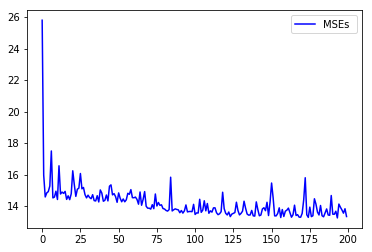

check point at 2019-04-25 21:49:19.423611
training : 汐止
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 15s - loss: 0.0018 - val_loss: 0.0011
Epoch : 0, MSE : [25.45861077289097]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 8.0903e-04 - val_loss: 7.0652e-04
Epoch : 1, MSE : [15.789849343087628]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.8946e-04 - val_loss: 6.2226e-04
Epoch : 2, MSE : [14.521966154129402]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 8s - loss: 5.5613e-04 - val_loss: 5.8383e-04
Epoch : 3, MSE : [13.437441141347149]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.5074e-04 - val_loss: 5.9459e-04
Epoch : 4, MSE : [13.69221383777796]
-------------------------------------------
Train on

 - 7s - loss: 5.1267e-04 - val_loss: 5.6088e-04
Epoch : 43, MSE : [12.916385457563923]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.1035e-04 - val_loss: 5.7338e-04
Epoch : 44, MSE : [13.208718027767485]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.1794e-04 - val_loss: 5.7130e-04
Epoch : 45, MSE : [13.13449502055248]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.0797e-04 - val_loss: 5.6485e-04
Epoch : 46, MSE : [13.026595484078847]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.0784e-04 - val_loss: 6.4313e-04
Epoch : 47, MSE : [15.103326007790837]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.1814e-04 - val_loss: 5.5806e-04
Epo

Epoch : 86, MSE : [12.793253829115745]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.9878e-04 - val_loss: 5.5877e-04
Epoch : 87, MSE : [12.763719670146248]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 5.0085e-04 - val_loss: 5.6156e-04
Epoch : 88, MSE : [12.69810786814683]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.9642e-04 - val_loss: 5.6394e-04
Epoch : 89, MSE : [12.755176566200637]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.8852e-04 - val_loss: 5.7684e-04
Epoch : 90, MSE : [13.223058850652205]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.9773e-04 - val_loss: 5.7929e-04
Epoch : 91, MSE : [13.051304960968551]
------------

Epoch : 129, MSE : [13.719413324882236]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 8s - loss: 4.7941e-04 - val_loss: 5.7873e-04
Epoch : 130, MSE : [12.80525731575607]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.7884e-04 - val_loss: 5.7621e-04
Epoch : 131, MSE : [12.708720187454249]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.7893e-04 - val_loss: 5.6771e-04
Epoch : 132, MSE : [12.562468192281896]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 8s - loss: 4.7674e-04 - val_loss: 5.7424e-04
Epoch : 133, MSE : [12.764331366054257]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 8s - loss: 4.8264e-04 - val_loss: 5.6921e-04
Epoch : 134, MSE : [12.641890605623898]
------

Epoch : 172, MSE : [12.697715182916761]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.7344e-04 - val_loss: 5.7447e-04
Epoch : 173, MSE : [12.378354081959854]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.6865e-04 - val_loss: 5.7625e-04
Epoch : 174, MSE : [12.419714336982098]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.7419e-04 - val_loss: 5.9267e-04
Epoch : 175, MSE : [12.88552975381629]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 7s - loss: 4.7191e-04 - val_loss: 5.9689e-04
Epoch : 176, MSE : [12.938733141036652]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 8s - loss: 4.7362e-04 - val_loss: 5.7655e-04
Epoch : 177, MSE : [12.442789822573456]
------

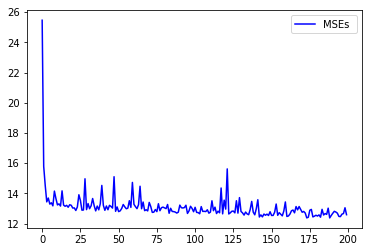

check point at 2019-04-25 22:20:17.693569
training : 淡水
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 17s - loss: 0.0016 - val_loss: 9.2248e-04
Epoch : 0, MSE : [25.24401992197716]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 7.3790e-04 - val_loss: 5.6657e-04
Epoch : 1, MSE : [14.994921103371007]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 5.6615e-04 - val_loss: 5.3067e-04
Epoch : 2, MSE : [13.974435678148742]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 5.5026e-04 - val_loss: 5.3761e-04
Epoch : 3, MSE : [14.24373809711197]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 5.3958e-04 - val_loss: 5.6021e-04
Epoch : 4, MSE : [14.797713421822701]
-------------------------------------------
Trai

 - 7s - loss: 5.0002e-04 - val_loss: 5.1354e-04
Epoch : 43, MSE : [13.442758917083266]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 5.0980e-04 - val_loss: 5.4139e-04
Epoch : 44, MSE : [14.019951661468033]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 5.1322e-04 - val_loss: 5.1615e-04
Epoch : 45, MSE : [13.4497719697496]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 5.0384e-04 - val_loss: 5.4428e-04
Epoch : 46, MSE : [14.245007246677782]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 5.0316e-04 - val_loss: 5.2671e-04
Epoch : 47, MSE : [13.78362257310622]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.9027e-04 - val_loss: 5.1445e-04
Epoch

Epoch : 86, MSE : [13.488086055886265]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.8506e-04 - val_loss: 5.1517e-04
Epoch : 87, MSE : [13.1558983805777]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 4.7656e-04 - val_loss: 5.1935e-04
Epoch : 88, MSE : [13.280654644757137]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.9551e-04 - val_loss: 5.0913e-04
Epoch : 89, MSE : [13.02096547485034]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 4.8083e-04 - val_loss: 5.0925e-04
Epoch : 90, MSE : [12.902894763136691]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.7932e-04 - val_loss: 5.1602e-04
Epoch : 91, MSE : [13.122272796872409]
--------------

 - 7s - loss: 4.6883e-04 - val_loss: 5.3530e-04
Epoch : 130, MSE : [13.718283750441161]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.7296e-04 - val_loss: 5.0575e-04
Epoch : 131, MSE : [12.808082485333857]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 4.6790e-04 - val_loss: 5.1316e-04
Epoch : 132, MSE : [12.911248346566254]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.6794e-04 - val_loss: 4.9970e-04
Epoch : 133, MSE : [12.696615854151833]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.6759e-04 - val_loss: 5.0185e-04
Epoch : 134, MSE : [12.732239301653992]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.6255e-04 - val_loss: 5.2384e-

 - 7s - loss: 4.6919e-04 - val_loss: 5.0386e-04
Epoch : 173, MSE : [12.762450743842738]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.6690e-04 - val_loss: 5.0825e-04
Epoch : 174, MSE : [12.91220430050005]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.6415e-04 - val_loss: 5.0157e-04
Epoch : 175, MSE : [12.694846941835728]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.6436e-04 - val_loss: 5.2423e-04
Epoch : 176, MSE : [13.217204165409946]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.6378e-04 - val_loss: 5.1688e-04
Epoch : 177, MSE : [13.01774903719947]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 7s - loss: 4.7045e-04 - val_loss: 5.0627e-04

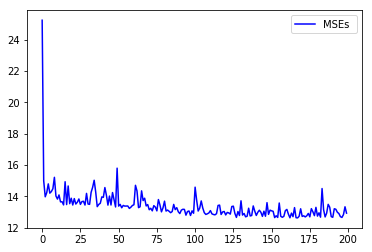

check point at 2019-04-25 22:52:05.272419
training : 菜寮
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 16s - loss: 0.0020 - val_loss: 9.5429e-04
Epoch : 0, MSE : [27.853273426409245]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 9.7089e-04 - val_loss: 5.8954e-04
Epoch : 1, MSE : [18.003799591274248]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 7.1967e-04 - val_loss: 4.6728e-04
Epoch : 2, MSE : [14.44485884129109]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 6.8088e-04 - val_loss: 5.4239e-04
Epoch : 3, MSE : [16.639574317522463]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 6.8778e-04 - val_loss: 4.7746e-04
Epoch : 4, MSE : [14.54890130241547]
-------------------------------------------
Trai

 - 8s - loss: 6.1175e-04 - val_loss: 4.4605e-04
Epoch : 43, MSE : [13.535285404188068]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 6.1388e-04 - val_loss: 4.4843e-04
Epoch : 44, MSE : [13.617861304455676]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 6.1732e-04 - val_loss: 4.5139e-04
Epoch : 45, MSE : [13.621536645344838]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 6.1506e-04 - val_loss: 4.5530e-04
Epoch : 46, MSE : [13.71980706300757]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 6.1350e-04 - val_loss: 4.4890e-04
Epoch : 47, MSE : [13.618219966801442]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 6.0693e-04 - val_loss: 4.5288e-04
Epo

Epoch : 86, MSE : [15.24776642438581]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.9585e-04 - val_loss: 5.3859e-04
Epoch : 87, MSE : [15.786896633697024]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.9525e-04 - val_loss: 4.3605e-04
Epoch : 88, MSE : [13.32093745771729]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.9312e-04 - val_loss: 4.3319e-04
Epoch : 89, MSE : [13.251380780133816]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.9244e-04 - val_loss: 4.3945e-04
Epoch : 90, MSE : [13.351618587997136]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.9266e-04 - val_loss: 4.3406e-04
Epoch : 91, MSE : [13.221947495293497]
-------------

 - 8s - loss: 5.7420e-04 - val_loss: 4.2885e-04
Epoch : 130, MSE : [13.196659745841202]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.7594e-04 - val_loss: 4.2326e-04
Epoch : 131, MSE : [13.075027582900004]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.7942e-04 - val_loss: 4.8681e-04
Epoch : 132, MSE : [14.412053936699579]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.8322e-04 - val_loss: 4.5316e-04
Epoch : 133, MSE : [14.083763036138379]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.7440e-04 - val_loss: 4.2516e-04
Epoch : 134, MSE : [12.955698689592536]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.7348e-04 - val_loss: 4.1661e-

 - 8s - loss: 5.7746e-04 - val_loss: 4.3041e-04
Epoch : 173, MSE : [13.125730251966875]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.6941e-04 - val_loss: 4.2062e-04
Epoch : 174, MSE : [13.045366740770527]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.7108e-04 - val_loss: 4.2425e-04
Epoch : 175, MSE : [12.959778676147138]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.6917e-04 - val_loss: 4.1616e-04
Epoch : 176, MSE : [12.827160988699948]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.7274e-04 - val_loss: 4.1991e-04
Epoch : 177, MSE : [12.8877490545637]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 8s - loss: 5.6779e-04 - val_loss: 4.1816e-04

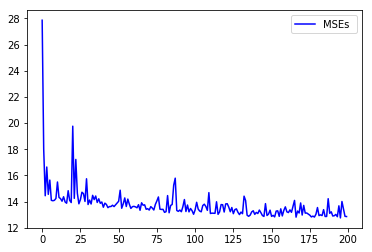

check point at 2019-04-25 23:26:24.342466
training : 萬華
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 16s - loss: 0.0025 - val_loss: 0.0013
Epoch : 0, MSE : [34.34912317145668]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0013 - val_loss: 0.0010
Epoch : 1, MSE : [27.952299273061616]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0012 - val_loss: 0.0010
Epoch : 2, MSE : [27.020171020950716]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0011 - val_loss: 9.6154e-04
Epoch : 3, MSE : [26.22328863722022]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0011 - val_loss: 9.3881e-04
Epoch : 4, MSE : [25.286320744309705]
-------------------------------------------
Train on 21882 samples, validate

 - 8s - loss: 0.0010 - val_loss: 9.1865e-04
Epoch : 44, MSE : [24.829122560613417]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.4315e-04
Epoch : 45, MSE : [25.598448756344943]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.0959e-04
Epoch : 46, MSE : [24.528848344233257]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.1829e-04
Epoch : 47, MSE : [24.718077360971062]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.5005e-04
Epoch : 48, MSE : [25.35312166760967]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.0895e-04
Epoch : 49, MSE : [24.44077

Epoch : 88, MSE : [24.126604525910242]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 0.0010
Epoch : 89, MSE : [27.0331962409488]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.2022e-04
Epoch : 90, MSE : [24.639083843127462]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 8.9246e-04
Epoch : 91, MSE : [24.076394560393478]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.9852e-04 - val_loss: 8.8738e-04
Epoch : 92, MSE : [23.972244692005777]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.2973e-04
Epoch : 93, MSE : [24.990844357729628]
---------------------------------

 - 8s - loss: 9.8957e-04 - val_loss: 9.1233e-04
Epoch : 132, MSE : [24.431020605948817]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.9107e-04 - val_loss: 8.8017e-04
Epoch : 133, MSE : [23.708234882024627]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.9605e-04 - val_loss: 9.0217e-04
Epoch : 134, MSE : [24.614754468876107]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.7750e-04 - val_loss: 9.0189e-04
Epoch : 135, MSE : [24.15482220934017]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.9191e-04 - val_loss: 9.0284e-04
Epoch : 136, MSE : [24.11932939780166]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.9576e-04 - val_loss: 8.8163e-04

 - 8s - loss: 9.8536e-04 - val_loss: 8.8576e-04
Epoch : 175, MSE : [23.708945484198757]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.8611e-04 - val_loss: 9.0937e-04
Epoch : 176, MSE : [24.348557000357243]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.8289e-04 - val_loss: 8.9172e-04
Epoch : 177, MSE : [23.787347184541524]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.8524e-04 - val_loss: 9.0693e-04
Epoch : 178, MSE : [24.223790705540967]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.8109e-04 - val_loss: 8.9596e-04
Epoch : 179, MSE : [23.912573623949026]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 8s - loss: 9.8072e-04 - val_loss: 8.8566e-

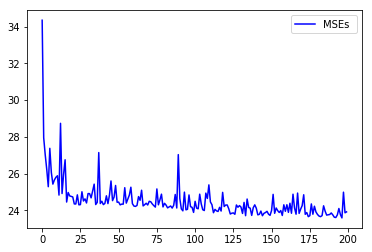

check point at 2019-04-25 23:59:37.102561
training : 萬里
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 5.9040e-04
Epoch : 0, MSE : [20.887479784183505]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 5.3109e-04 - val_loss: 3.8998e-04
Epoch : 1, MSE : [13.70878553237975]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 9s - loss: 3.8650e-04 - val_loss: 3.2087e-04
Epoch : 2, MSE : [11.296366736149942]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.7180e-04 - val_loss: 3.2961e-04
Epoch : 3, MSE : [11.704048735026253]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.7095e-04 - val_loss: 3.1025e-04
Epoch : 4, MSE : [10.992869475168169]
-------------------------------------------
Tra

 - 8s - loss: 3.3840e-04 - val_loss: 3.1597e-04
Epoch : 43, MSE : [11.154688055276486]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3986e-04 - val_loss: 3.1537e-04
Epoch : 44, MSE : [11.16523773439201]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.5185e-04 - val_loss: 3.1429e-04
Epoch : 45, MSE : [11.11053391446408]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.4388e-04 - val_loss: 3.1108e-04
Epoch : 46, MSE : [11.06869462386342]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3820e-04 - val_loss: 3.0831e-04
Epoch : 47, MSE : [10.900004388265856]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3837e-04 - val_loss: 3.1645e-04
Epoch

Epoch : 86, MSE : [11.195318784737125]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3398e-04 - val_loss: 3.1387e-04
Epoch : 87, MSE : [11.156863744233611]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.4231e-04 - val_loss: 3.0974e-04
Epoch : 88, MSE : [10.984029244765106]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3556e-04 - val_loss: 3.0959e-04
Epoch : 89, MSE : [11.022878932655072]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 9s - loss: 3.3412e-04 - val_loss: 3.1067e-04
Epoch : 90, MSE : [11.036036568437954]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3589e-04 - val_loss: 3.1131e-04
Epoch : 91, MSE : [11.002128519352832]
-----------

Epoch : 129, MSE : [11.012747371557994]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.2811e-04 - val_loss: 3.1000e-04
Epoch : 130, MSE : [10.959158353069942]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.2890e-04 - val_loss: 3.1399e-04
Epoch : 131, MSE : [11.17856925031317]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 9s - loss: 3.3022e-04 - val_loss: 3.3055e-04
Epoch : 132, MSE : [11.723703572134529]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3517e-04 - val_loss: 3.0646e-04
Epoch : 133, MSE : [10.80547337609485]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.3517e-04 - val_loss: 3.0481e-04
Epoch : 134, MSE : [10.846185794305978]
-------

Epoch : 172, MSE : [10.765376315625414]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.2202e-04 - val_loss: 3.0638e-04
Epoch : 173, MSE : [10.945309599529004]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.1838e-04 - val_loss: 2.9944e-04
Epoch : 174, MSE : [10.678108753090964]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.2756e-04 - val_loss: 3.0723e-04
Epoch : 175, MSE : [10.976388077590263]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.2061e-04 - val_loss: 3.0834e-04
Epoch : 176, MSE : [11.049014325431665]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 8s - loss: 3.2585e-04 - val_loss: 2.9774e-04
Epoch : 177, MSE : [10.610696136324833]
-----

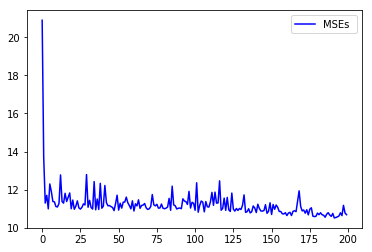

check point at 2019-04-26 00:34:33.105083
training : 觀音
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 17s - loss: 0.0023 - val_loss: 0.0013
Epoch : 0, MSE : [34.78533630438771]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 0.0011 - val_loss: 9.1308e-04
Epoch : 1, MSE : [24.016477775904153]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 9.2952e-04 - val_loss: 8.6000e-04
Epoch : 2, MSE : [22.750136500358263]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 8.8714e-04 - val_loss: 8.2706e-04
Epoch : 3, MSE : [21.891635201395243]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 8.7868e-04 - val_loss: 7.9912e-04
Epoch : 4, MSE : [21.033224901745314]
-------------------------------------------
Train on 22

 - 8s - loss: 7.9269e-04 - val_loss: 7.8431e-04
Epoch : 43, MSE : [20.48159956599265]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.9081e-04 - val_loss: 7.8209e-04
Epoch : 44, MSE : [20.21802488982376]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.8414e-04 - val_loss: 7.8573e-04
Epoch : 45, MSE : [20.481220547603762]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.9484e-04 - val_loss: 8.0268e-04
Epoch : 46, MSE : [20.833554204714076]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.8774e-04 - val_loss: 8.1702e-04
Epoch : 47, MSE : [21.119265593756705]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.9112e-04 - val_loss: 7.7845e-04
Epoc

Epoch : 86, MSE : [20.086472418823696]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.7186e-04 - val_loss: 7.7817e-04
Epoch : 87, MSE : [20.125743398674135]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.7839e-04 - val_loss: 7.7974e-04
Epoch : 88, MSE : [20.23127502324505]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.7241e-04 - val_loss: 7.8621e-04
Epoch : 89, MSE : [20.34003260450581]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.7350e-04 - val_loss: 7.6964e-04
Epoch : 90, MSE : [19.980352093478928]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.7250e-04 - val_loss: 7.6412e-04
Epoch : 91, MSE : [19.883523084918554]
-------------

 - 9s - loss: 7.6872e-04 - val_loss: 7.9533e-04
Epoch : 130, MSE : [20.70175226755549]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.6899e-04 - val_loss: 7.6139e-04
Epoch : 131, MSE : [19.772716686980992]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.6175e-04 - val_loss: 7.5798e-04
Epoch : 132, MSE : [19.714728968831984]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.6230e-04 - val_loss: 7.6577e-04
Epoch : 133, MSE : [19.93548367328019]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.7359e-04 - val_loss: 7.5894e-04
Epoch : 134, MSE : [19.85456403597909]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 8s - loss: 7.6461e-04 - val_loss: 7.6961e-04


 - 8s - loss: 7.5310e-04 - val_loss: 7.5195e-04
Epoch : 173, MSE : [19.606454397679936]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.6181e-04 - val_loss: 7.7998e-04
Epoch : 174, MSE : [20.408076329214946]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.6965e-04 - val_loss: 7.7429e-04
Epoch : 175, MSE : [20.251210338826052]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.5367e-04 - val_loss: 7.5609e-04
Epoch : 176, MSE : [19.6823734390543]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.6304e-04 - val_loss: 7.6159e-04
Epoch : 177, MSE : [19.723598756773328]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 9s - loss: 7.6041e-04 - val_loss: 7.5186e-04

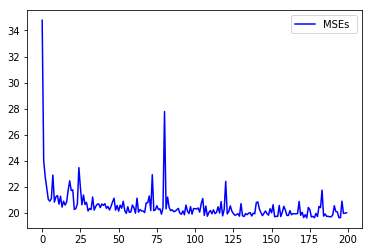

check point at 2019-04-26 01:10:32.431088
training : 陽明
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 17s - loss: 0.0021 - val_loss: 0.0012
Epoch : 0, MSE : [25.722627039959068]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0012 - val_loss: 9.8219e-04
Epoch : 1, MSE : [19.85376024967595]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0011 - val_loss: 9.9426e-04
Epoch : 2, MSE : [19.763186370988723]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0011 - val_loss: 9.6559e-04
Epoch : 3, MSE : [19.393410985612427]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0011 - val_loss: 9.7780e-04
Epoch : 4, MSE : [19.529818015246896]
-------------------------------------------
Train on 19175 samples,

 - 7s - loss: 0.0010 - val_loss: 9.8505e-04
Epoch : 44, MSE : [19.368665982454793]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 45, MSE : [20.1160633277721]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.9191e-04
Epoch : 46, MSE : [19.404932241582774]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 0.0010
Epoch : 47, MSE : [19.93331056680337]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.8729e-04
Epoch : 48, MSE : [19.492242929962377]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.7421e-04
Epoch : 49, MSE : [19.227789563467116

 - 8s - loss: 0.0010 - val_loss: 0.0010
Epoch : 89, MSE : [19.953692446751234]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.9600e-04
Epoch : 90, MSE : [19.495086889039758]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 91, MSE : [19.67160943352951]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.9843e-04
Epoch : 92, MSE : [19.467714877938395]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 93, MSE : [19.74212809430795]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 94, MSE : [19.58715365369791]
------

 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 134, MSE : [19.786314172032682]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 135, MSE : [19.666301596657174]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.8923e-04
Epoch : 136, MSE : [19.2899620925057]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.9924e-04
Epoch : 137, MSE : [19.502950564935144]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.8477e-04
Epoch : 138, MSE : [19.293557471669654]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 139, MSE : [20.537404382207

 - 8s - loss: 0.0010 - val_loss: 9.9750e-04
Epoch : 179, MSE : [19.381322719635136]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.9738e-04
Epoch : 180, MSE : [19.761360545362805]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.8219e-04
Epoch : 181, MSE : [19.253928133285203]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 9.8667e-04
Epoch : 182, MSE : [19.288113465351234]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 7s - loss: 0.0010 - val_loss: 0.0010
Epoch : 183, MSE : [20.429688845095516]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.9754e-04
Epoch : 184, MSE : [19.31

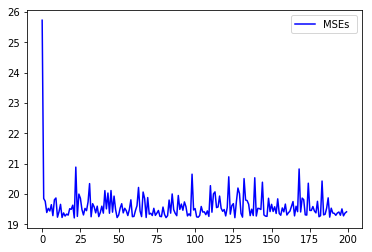

check point at 2019-04-26 01:42:07.776452
training : 龍潭
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 20s - loss: 0.0022 - val_loss: 0.0011
Epoch : 0, MSE : [33.924192577523286]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 0.0011 - val_loss: 9.1284e-04
Epoch : 1, MSE : [28.339516480080963]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 0.0010 - val_loss: 9.0507e-04
Epoch : 2, MSE : [28.208969619316267]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 9.4535e-04 - val_loss: 9.5019e-04
Epoch : 3, MSE : [29.131962243626138]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 11s - loss: 9.1171e-04 - val_loss: 8.1785e-04
Epoch : 4, MSE : [25.2938507493297]
-------------------------------------------
Train on 240

 - 10s - loss: 8.2388e-04 - val_loss: 7.9561e-04
Epoch : 43, MSE : [24.312799682426924]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 9s - loss: 8.1528e-04 - val_loss: 7.9171e-04
Epoch : 44, MSE : [24.23948980413723]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 9s - loss: 8.2959e-04 - val_loss: 8.0955e-04
Epoch : 45, MSE : [24.800897682605342]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 9s - loss: 8.3364e-04 - val_loss: 7.9881e-04
Epoch : 46, MSE : [24.623340887976198]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.1934e-04 - val_loss: 7.8572e-04
Epoch : 47, MSE : [24.121735212345556]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.2561e-04 - val_loss: 7.7743e-04


Epoch : 86, MSE : [24.832847968346357]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.1603e-04 - val_loss: 7.7147e-04
Epoch : 87, MSE : [23.72515174348511]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 9s - loss: 8.0985e-04 - val_loss: 7.8055e-04
Epoch : 88, MSE : [24.0733708047085]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.1598e-04 - val_loss: 7.7433e-04
Epoch : 89, MSE : [23.86820535829927]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 9s - loss: 8.2090e-04 - val_loss: 7.7216e-04
Epoch : 90, MSE : [23.741721124871358]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.2148e-04 - val_loss: 7.7190e-04
Epoch : 91, MSE : [23.68845535131864]
-------------

Epoch : 129, MSE : [24.211523950671324]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 9s - loss: 8.1281e-04 - val_loss: 7.6931e-04
Epoch : 130, MSE : [23.770170491073877]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 9s - loss: 8.0454e-04 - val_loss: 7.7586e-04
Epoch : 131, MSE : [23.93343477983146]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.1130e-04 - val_loss: 8.0377e-04
Epoch : 132, MSE : [24.501263284461892]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.0798e-04 - val_loss: 7.8402e-04
Epoch : 133, MSE : [24.020270988564203]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.0837e-04 - val_loss: 7.7334e-04
Epoch : 134, MSE : [23.945867358283483]
---

Epoch : 172, MSE : [23.921617157025512]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 7.9560e-04 - val_loss: 7.7063e-04
Epoch : 173, MSE : [23.841914703533742]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.0338e-04 - val_loss: 7.9999e-04
Epoch : 174, MSE : [24.786223234594747]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.0407e-04 - val_loss: 7.7743e-04
Epoch : 175, MSE : [23.87549315226371]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 7.9531e-04 - val_loss: 7.6530e-04
Epoch : 176, MSE : [23.5389616835757]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 10s - loss: 8.0318e-04 - val_loss: 7.6955e-04
Epoch : 177, MSE : [23.869124607664173]
---

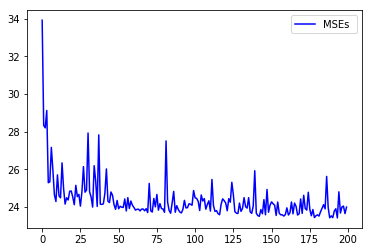

check point at 2019-04-26 02:23:00.911131
training : 冬山
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 20s - loss: 0.0024 - val_loss: 0.0014
Epoch : 0, MSE : [25.739754746107593]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 0.0013 - val_loss: 9.2613e-04
Epoch : 1, MSE : [16.673981982337587]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 9.2675e-04 - val_loss: 8.0623e-04
Epoch : 2, MSE : [14.183400703822127]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 8.5848e-04 - val_loss: 8.3482e-04
Epoch : 3, MSE : [14.572347785890978]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 8.4175e-04 - val_loss: 7.9811e-04
Epoch : 4, MSE : [14.238933448588696]
-------------------------------------------
Train on 2

 - 8s - loss: 8.0006e-04 - val_loss: 8.0514e-04
Epoch : 43, MSE : [14.526853162992976]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 7.9668e-04 - val_loss: 7.8884e-04
Epoch : 44, MSE : [14.065218443792311]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 8.0188e-04 - val_loss: 7.7838e-04
Epoch : 45, MSE : [13.89944481397488]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 7.9487e-04 - val_loss: 8.2974e-04
Epoch : 46, MSE : [15.013401919513694]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.8561e-04 - val_loss: 7.7195e-04
Epoch : 47, MSE : [13.873746251679243]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 7.9269e-04 - val_loss: 7.8841e-04
Epo

Epoch : 86, MSE : [13.973097789388106]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.7587e-04 - val_loss: 7.8155e-04
Epoch : 87, MSE : [13.795754919358403]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.7889e-04 - val_loss: 7.6425e-04
Epoch : 88, MSE : [13.616613078870685]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.7556e-04 - val_loss: 7.8668e-04
Epoch : 89, MSE : [14.056220877058689]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.8016e-04 - val_loss: 7.7595e-04
Epoch : 90, MSE : [13.833243426509569]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.6950e-04 - val_loss: 7.9522e-04
Epoch : 91, MSE : [14.098305433943414]
-----------

 - 8s - loss: 7.6872e-04 - val_loss: 7.8247e-04
Epoch : 130, MSE : [13.904676975176102]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.6485e-04 - val_loss: 7.5608e-04
Epoch : 131, MSE : [13.513280672310726]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.5855e-04 - val_loss: 7.7465e-04
Epoch : 132, MSE : [13.734104189367288]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.7042e-04 - val_loss: 7.9329e-04
Epoch : 133, MSE : [14.237805534524245]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.7417e-04 - val_loss: 7.5835e-04
Epoch : 134, MSE : [13.613711529859714]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 7.6620e-04 - val_loss: 7.5235e-

 - 9s - loss: 7.6092e-04 - val_loss: 7.5876e-04
Epoch : 173, MSE : [13.561729761333995]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.5707e-04 - val_loss: 7.5236e-04
Epoch : 174, MSE : [13.409669808174888]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 7.5463e-04 - val_loss: 7.5285e-04
Epoch : 175, MSE : [13.37217305058406]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.6063e-04 - val_loss: 7.6573e-04
Epoch : 176, MSE : [13.560459658289172]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 9s - loss: 7.5678e-04 - val_loss: 7.6888e-04
Epoch : 177, MSE : [13.57140037366781]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 8s - loss: 7.5218e-04 - val_loss: 7.5841e-04

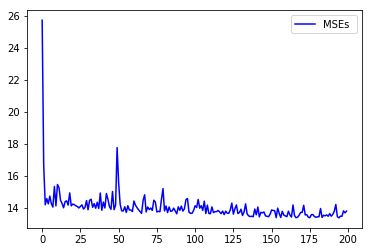

check point at 2019-04-26 02:58:58.456014
training : 宜蘭
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 8.7163e-04
Epoch : 0, MSE : [19.360659330410968]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 7.7754e-04 - val_loss: 5.2655e-04
Epoch : 1, MSE : [11.493043006753267]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 5.5501e-04 - val_loss: 4.3235e-04
Epoch : 2, MSE : [9.41660790458667]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 5.1357e-04 - val_loss: 4.3476e-04
Epoch : 3, MSE : [9.442327693240872]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 5.0494e-04 - val_loss: 4.2340e-04
Epoch : 4, MSE : [9.220978292794186]
-------------------------------------------
Tr

 - 10s - loss: 4.6483e-04 - val_loss: 4.0896e-04
Epoch : 43, MSE : [8.829098860117227]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 4.7144e-04 - val_loss: 4.0953e-04
Epoch : 44, MSE : [8.912116464632188]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 4.7596e-04 - val_loss: 4.1964e-04
Epoch : 45, MSE : [9.105128481339593]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 4.6508e-04 - val_loss: 4.7861e-04
Epoch : 46, MSE : [10.402030821849472]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 4.7539e-04 - val_loss: 4.2986e-04
Epoch : 47, MSE : [9.368090216353101]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 10s - loss: 4.7008e-04 - val_loss: 4.1089e-04


 - 9s - loss: 4.5261e-04 - val_loss: 4.1488e-04
Epoch : 87, MSE : [8.954765735787326]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.7100e-04 - val_loss: 4.3634e-04
Epoch : 88, MSE : [9.357356147055496]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.5706e-04 - val_loss: 4.0195e-04
Epoch : 89, MSE : [8.7120594349067]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.6346e-04 - val_loss: 4.0848e-04
Epoch : 90, MSE : [8.816843347892773]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.5809e-04 - val_loss: 4.1245e-04
Epoch : 91, MSE : [8.896555016103207]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.5808e-04 - val_loss: 4.2732e-04
Epoch : 9

Epoch : 130, MSE : [9.53406735737907]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.5328e-04 - val_loss: 3.9657e-04
Epoch : 131, MSE : [8.656045591765858]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.5848e-04 - val_loss: 4.0585e-04
Epoch : 132, MSE : [8.722310345392938]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.4815e-04 - val_loss: 4.3781e-04
Epoch : 133, MSE : [9.42550563817804]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.4914e-04 - val_loss: 4.5429e-04
Epoch : 134, MSE : [9.85673947204686]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.4842e-04 - val_loss: 4.0535e-04
Epoch : 135, MSE : [8.815252643134507]
--------------

 - 9s - loss: 4.4855e-04 - val_loss: 4.1123e-04
Epoch : 174, MSE : [8.869080832457215]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.4314e-04 - val_loss: 3.9943e-04
Epoch : 175, MSE : [8.535035864948357]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.4374e-04 - val_loss: 3.9611e-04
Epoch : 176, MSE : [8.568963145020787]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.4558e-04 - val_loss: 3.9696e-04
Epoch : 177, MSE : [8.62771990721413]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.4778e-04 - val_loss: 3.9359e-04
Epoch : 178, MSE : [8.573225860712501]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 9s - loss: 4.3820e-04 - val_loss: 4.0354e-04
Epo

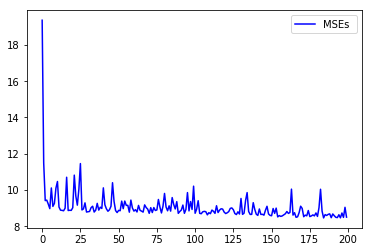

check point at 2019-04-26 03:35:44.885579
training : 三義
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 18s - loss: 0.0022 - val_loss: 0.0011
Epoch : 0, MSE : [45.732768024991685]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 9.7812e-04 - val_loss: 7.6679e-04
Epoch : 1, MSE : [30.24709557282985]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 7.2502e-04 - val_loss: 5.8523e-04
Epoch : 2, MSE : [23.5806110601295]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 6.6730e-04 - val_loss: 5.6567e-04
Epoch : 3, MSE : [22.945366267117194]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 6.4508e-04 - val_loss: 5.6278e-04
Epoch : 4, MSE : [22.707332563576696]
-------------------------------------------
Train on 

 - 8s - loss: 6.0445e-04 - val_loss: 5.5078e-04
Epoch : 43, MSE : [22.31077167677927]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 6.0861e-04 - val_loss: 5.4554e-04
Epoch : 44, MSE : [22.16883037796296]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 6.0214e-04 - val_loss: 5.2945e-04
Epoch : 45, MSE : [21.547131630266094]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 6.0290e-04 - val_loss: 5.4553e-04
Epoch : 46, MSE : [22.135157269487323]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 6.1359e-04 - val_loss: 5.5573e-04
Epoch : 47, MSE : [22.533961195880043]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 6.0450e-04 - val_loss: 5.2847e-04
Epoc

Epoch : 86, MSE : [24.673581522972118]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.8174e-04 - val_loss: 5.1130e-04
Epoch : 87, MSE : [20.747104014032427]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.7801e-04 - val_loss: 5.2573e-04
Epoch : 88, MSE : [21.40111255695467]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.7194e-04 - val_loss: 5.1220e-04
Epoch : 89, MSE : [20.82313894023857]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.6907e-04 - val_loss: 5.1043e-04
Epoch : 90, MSE : [20.690688172984157]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.7684e-04 - val_loss: 5.2198e-04
Epoch : 91, MSE : [21.106677951776938]
-------------

 - 8s - loss: 5.6288e-04 - val_loss: 5.0949e-04
Epoch : 130, MSE : [20.488433255278995]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.6799e-04 - val_loss: 5.1081e-04
Epoch : 131, MSE : [20.563623609373202]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.6320e-04 - val_loss: 5.1068e-04
Epoch : 132, MSE : [20.60105319907341]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.5610e-04 - val_loss: 5.4190e-04
Epoch : 133, MSE : [21.8832963028561]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.6438e-04 - val_loss: 5.0965e-04
Epoch : 134, MSE : [20.577269236777028]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.5616e-04 - val_loss: 5.0761e-04


 - 8s - loss: 5.4946e-04 - val_loss: 5.1768e-04
Epoch : 173, MSE : [20.680933424798795]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.4796e-04 - val_loss: 5.3885e-04
Epoch : 174, MSE : [21.509623524006727]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.5745e-04 - val_loss: 5.3970e-04
Epoch : 175, MSE : [21.48239435103265]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.5614e-04 - val_loss: 5.3181e-04
Epoch : 176, MSE : [21.231468218679233]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.5122e-04 - val_loss: 5.0566e-04
Epoch : 177, MSE : [20.190627716566205]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 8s - loss: 5.5117e-04 - val_loss: 5.2262e-0

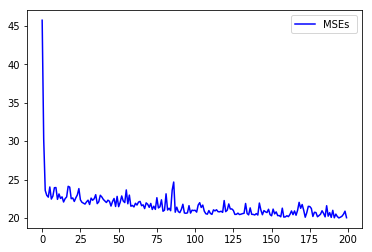

check point at 2019-04-26 04:08:48.911940
training : 新竹
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 18s - loss: 0.0020 - val_loss: 0.0011
Epoch : 0, MSE : [30.79595694488479]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 8.9758e-04 - val_loss: 6.2969e-04
Epoch : 1, MSE : [18.38366576283811]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 6.5639e-04 - val_loss: 5.2552e-04
Epoch : 2, MSE : [15.686402552178103]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 6.1701e-04 - val_loss: 5.2919e-04
Epoch : 3, MSE : [15.736204443695819]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 6.1513e-04 - val_loss: 5.3774e-04
Epoch : 4, MSE : [16.02159237279426]
-------------------------------------------
Train on 

 - 9s - loss: 5.5785e-04 - val_loss: 5.1806e-04
Epoch : 43, MSE : [15.289819970017875]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.5394e-04 - val_loss: 5.4178e-04
Epoch : 44, MSE : [15.719931955379925]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.5715e-04 - val_loss: 5.1081e-04
Epoch : 45, MSE : [15.06031613357428]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.5744e-04 - val_loss: 5.1149e-04
Epoch : 46, MSE : [15.135848829757226]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.5226e-04 - val_loss: 5.2374e-04
Epoch : 47, MSE : [15.37819499068404]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.5240e-04 - val_loss: 5.1498e-04
Epoc

Epoch : 86, MSE : [14.83255465511903]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.2769e-04 - val_loss: 4.8961e-04
Epoch : 87, MSE : [14.4698956400468]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.2063e-04 - val_loss: 5.2295e-04
Epoch : 88, MSE : [15.39418774294197]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.1825e-04 - val_loss: 4.8218e-04
Epoch : 89, MSE : [14.315712329949779]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.2383e-04 - val_loss: 5.0733e-04
Epoch : 90, MSE : [15.207546606639617]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.2552e-04 - val_loss: 4.8708e-04
Epoch : 91, MSE : [14.411979215594334]
---------------

 - 9s - loss: 5.1705e-04 - val_loss: 4.8369e-04
Epoch : 130, MSE : [14.207972024362077]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.0890e-04 - val_loss: 4.9623e-04
Epoch : 131, MSE : [14.474494455297181]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.1738e-04 - val_loss: 4.7760e-04
Epoch : 132, MSE : [14.131400568376824]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.0704e-04 - val_loss: 4.9043e-04
Epoch : 133, MSE : [14.512043062722924]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.0992e-04 - val_loss: 5.4497e-04
Epoch : 134, MSE : [16.076279245762738]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.1412e-04 - val_loss: 4.8033e-

 - 9s - loss: 5.0649e-04 - val_loss: 4.9359e-04
Epoch : 173, MSE : [14.49880213502906]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.1807e-04 - val_loss: 5.1600e-04
Epoch : 174, MSE : [15.020240737093525]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.0100e-04 - val_loss: 4.8803e-04
Epoch : 175, MSE : [14.29798874902686]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.0651e-04 - val_loss: 4.9270e-04
Epoch : 176, MSE : [14.392156089119135]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.0810e-04 - val_loss: 4.8997e-04
Epoch : 177, MSE : [14.324916942638795]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 9s - loss: 5.1454e-04 - val_loss: 4.8297e-04

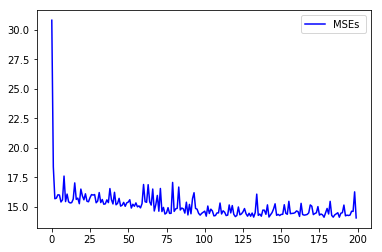

check point at 2019-04-26 04:44:16.311873
training : 湖口
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 18s - loss: 0.0023 - val_loss: 0.0012
Epoch : 0, MSE : [37.569188881388804]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 0.0011 - val_loss: 7.2858e-04
Epoch : 1, MSE : [23.516125708403735]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 8.7815e-04 - val_loss: 6.5676e-04
Epoch : 2, MSE : [21.285263430138443]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 8.5435e-04 - val_loss: 6.9103e-04
Epoch : 3, MSE : [22.40616148699419]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 8.4634e-04 - val_loss: 6.8590e-04
Epoch : 4, MSE : [22.248226268415582]
-------------------------------------------
Train on 20

 - 8s - loss: 7.7469e-04 - val_loss: 6.7310e-04
Epoch : 43, MSE : [21.603649543619238]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.7509e-04 - val_loss: 6.5830e-04
Epoch : 44, MSE : [20.813169906636432]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.8099e-04 - val_loss: 6.6560e-04
Epoch : 45, MSE : [20.87089988895476]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.6958e-04 - val_loss: 6.8354e-04
Epoch : 46, MSE : [21.5545672122255]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.7287e-04 - val_loss: 6.5164e-04
Epoch : 47, MSE : [20.77377573855018]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.8103e-04 - val_loss: 6.7223e-04
Epoch 

Epoch : 86, MSE : [20.006606387461282]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.5067e-04 - val_loss: 6.3629e-04
Epoch : 87, MSE : [20.047715916142838]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.6457e-04 - val_loss: 6.4272e-04
Epoch : 88, MSE : [20.120151338428443]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.5351e-04 - val_loss: 6.5410e-04
Epoch : 89, MSE : [20.577596351599215]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.4555e-04 - val_loss: 6.3773e-04
Epoch : 90, MSE : [20.03833287339699]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.4124e-04 - val_loss: 6.3415e-04
Epoch : 91, MSE : [19.978117275890664]
------------

 - 8s - loss: 7.3142e-04 - val_loss: 6.4316e-04
Epoch : 130, MSE : [20.040275353422473]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.3891e-04 - val_loss: 6.3973e-04
Epoch : 131, MSE : [19.701071193564346]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.4063e-04 - val_loss: 6.5865e-04
Epoch : 132, MSE : [20.42623706086125]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.2586e-04 - val_loss: 6.4038e-04
Epoch : 133, MSE : [19.690141673355015]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.2949e-04 - val_loss: 6.4612e-04
Epoch : 134, MSE : [19.769380001862245]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.2376e-04 - val_loss: 6.7282e-0

Epoch : 173, MSE : [19.809164423891065]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.2465e-04 - val_loss: 6.6828e-04
Epoch : 174, MSE : [20.51058683901795]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.1189e-04 - val_loss: 7.1461e-04
Epoch : 175, MSE : [21.952536419045472]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.3193e-04 - val_loss: 6.4481e-04
Epoch : 176, MSE : [19.615510545934647]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.1695e-04 - val_loss: 6.3805e-04
Epoch : 177, MSE : [19.447630429621103]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 8s - loss: 7.2559e-04 - val_loss: 6.4136e-04
Epoch : 178, MSE : [19.52439946373122]
-------

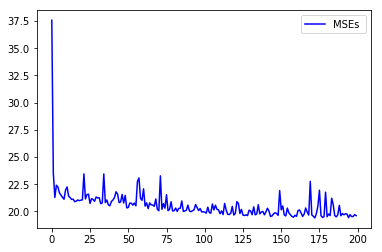

check point at 2019-04-26 05:18:13.779734
training : 竹東
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 19s - loss: 0.0027 - val_loss: 0.0015
Epoch : 0, MSE : [37.88907908020744]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 9s - loss: 0.0013 - val_loss: 9.5810e-04
Epoch : 1, MSE : [24.84687891634578]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 0.0011 - val_loss: 9.9350e-04
Epoch : 2, MSE : [25.406565623993053]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.3583e-04
Epoch : 3, MSE : [24.09434317074147]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 0.0010 - val_loss: 9.3887e-04
Epoch : 4, MSE : [24.18317439494071]
-------------------------------------------
Train on 20749 samples, va

Epoch : 43, MSE : [24.02420669655098]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.6696e-04 - val_loss: 9.2644e-04
Epoch : 44, MSE : [23.59478711780826]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.6414e-04 - val_loss: 9.4741e-04
Epoch : 45, MSE : [24.198580915431005]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.5428e-04 - val_loss: 9.2943e-04
Epoch : 46, MSE : [23.60327675734398]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 9s - loss: 9.7155e-04 - val_loss: 9.5360e-04
Epoch : 47, MSE : [24.12965762421536]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.5751e-04 - val_loss: 9.4103e-04
Epoch : 48, MSE : [24.091678195348862]
---------------

 - 8s - loss: 9.2674e-04 - val_loss: 9.5413e-04
Epoch : 87, MSE : [24.11035813370231]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.5571e-04 - val_loss: 9.2386e-04
Epoch : 88, MSE : [23.039909562129758]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.3806e-04 - val_loss: 9.1868e-04
Epoch : 89, MSE : [22.8536632835822]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.4596e-04 - val_loss: 9.1732e-04
Epoch : 90, MSE : [22.907515613149783]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.3409e-04 - val_loss: 9.3334e-04
Epoch : 91, MSE : [23.432200983712043]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.2847e-04 - val_loss: 9.4255e-04
Epoch

Epoch : 130, MSE : [22.871133656221385]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.2624e-04 - val_loss: 9.2221e-04
Epoch : 131, MSE : [22.874920954911346]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.2192e-04 - val_loss: 9.1674e-04
Epoch : 132, MSE : [22.780914089558497]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.2867e-04 - val_loss: 9.3127e-04
Epoch : 133, MSE : [23.365351474629378]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.1726e-04 - val_loss: 9.2850e-04
Epoch : 134, MSE : [22.941022224543122]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.2255e-04 - val_loss: 9.1362e-04
Epoch : 135, MSE : [22.744387950274213]
-----

 - 8s - loss: 9.2160e-04 - val_loss: 9.3488e-04
Epoch : 174, MSE : [22.887400814992986]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.1624e-04 - val_loss: 9.5428e-04
Epoch : 175, MSE : [23.230771008164787]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.1862e-04 - val_loss: 9.2994e-04
Epoch : 176, MSE : [22.836237122779398]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.0904e-04 - val_loss: 9.2373e-04
Epoch : 177, MSE : [22.64231037786816]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.1919e-04 - val_loss: 9.3005e-04
Epoch : 178, MSE : [22.825385718602476]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 8s - loss: 9.1128e-04 - val_loss: 9.2748e-0

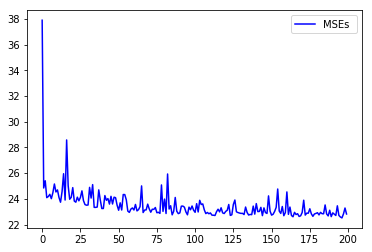

check point at 2019-04-26 05:52:08.116635
training : 苗栗
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 19s - loss: 0.0041 - val_loss: 0.0026
Epoch : 0, MSE : [56.90559687601523]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0021 - val_loss: 0.0016
Epoch : 1, MSE : [35.092657286159074]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0017 - val_loss: 0.0016
Epoch : 2, MSE : [34.57778104638649]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0017 - val_loss: 0.0016
Epoch : 3, MSE : [35.38280137858103]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0017 - val_loss: 0.0016
Epoch : 4, MSE : [34.612333104889025]
-------------------------------------------
Train on 20096 samples, validate on 5025 

 - 8s - loss: 0.0016 - val_loss: 0.0016
Epoch : 45, MSE : [34.044792192394]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0016 - val_loss: 0.0016
Epoch : 46, MSE : [34.48749501847295]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0016 - val_loss: 0.0016
Epoch : 47, MSE : [33.94831859948919]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0016 - val_loss: 0.0016
Epoch : 48, MSE : [34.746967834711704]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0016 - val_loss: 0.0015
Epoch : 49, MSE : [33.93593332129129]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0016 - val_loss: 0.0016
Epoch : 50, MSE : [34.759679865272965]
-----------------

 - 9s - loss: 0.0016 - val_loss: 0.0016
Epoch : 91, MSE : [34.140238112193025]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0016 - val_loss: 0.0015
Epoch : 92, MSE : [33.58963768196537]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0016 - val_loss: 0.0015
Epoch : 93, MSE : [33.62375008414524]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0015 - val_loss: 0.0015
Epoch : 94, MSE : [33.34097590398304]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0016 - val_loss: 0.0015
Epoch : 95, MSE : [33.94261002668664]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0016 - val_loss: 0.0015
Epoch : 96, MSE : [33.1658169034107]
-----------------

Epoch : 136, MSE : [32.50692958182402]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0015 - val_loss: 0.0015
Epoch : 137, MSE : [33.262493996984524]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0015 - val_loss: 0.0015
Epoch : 138, MSE : [32.94657023888493]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0015 - val_loss: 0.0015
Epoch : 139, MSE : [33.432694340437926]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0015 - val_loss: 0.0016
Epoch : 140, MSE : [34.55646083673136]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0015 - val_loss: 0.0015
Epoch : 141, MSE : [32.84248343340864]
-------------------------------------------
Train

Epoch : 181, MSE : [32.45076944224984]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 8s - loss: 0.0015 - val_loss: 0.0015
Epoch : 182, MSE : [32.49301581798627]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0015 - val_loss: 0.0015
Epoch : 183, MSE : [31.944707255972784]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0015 - val_loss: 0.0015
Epoch : 184, MSE : [32.20733837179912]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0015 - val_loss: 0.0015
Epoch : 185, MSE : [32.79743518755123]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 9s - loss: 0.0015 - val_loss: 0.0015
Epoch : 186, MSE : [31.921924616752136]
-------------------------------------------
Train

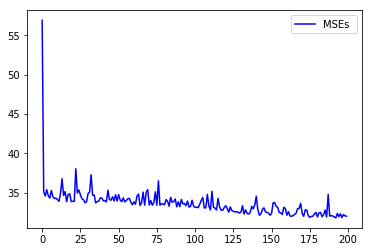

check point at 2019-04-26 06:26:52.001629
training : 頭份
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 21s - loss: 0.0025 - val_loss: 0.0012
Epoch : 0, MSE : [33.84261149021772]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 0.0011 - val_loss: 6.5207e-04
Epoch : 1, MSE : [19.145184040966086]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 8.8946e-04 - val_loss: 6.4308e-04
Epoch : 2, MSE : [18.633070089624418]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 8.4607e-04 - val_loss: 6.1797e-04
Epoch : 3, MSE : [18.15167789822036]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 8.3839e-04 - val_loss: 6.2497e-04
Epoch : 4, MSE : [18.287642584743004]
-------------------------------------------
Train on

 - 10s - loss: 7.7623e-04 - val_loss: 6.0494e-04
Epoch : 43, MSE : [17.657879915631025]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.7867e-04 - val_loss: 5.9970e-04
Epoch : 44, MSE : [17.716533839444402]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.8538e-04 - val_loss: 5.9858e-04
Epoch : 45, MSE : [17.597520858518465]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.7355e-04 - val_loss: 5.8963e-04
Epoch : 46, MSE : [17.319000945687733]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.7060e-04 - val_loss: 6.0003e-04
Epoch : 47, MSE : [17.505636084949273]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.7822e-04 - val_loss: 5.8549e

 - 10s - loss: 7.4361e-04 - val_loss: 6.0740e-04
Epoch : 86, MSE : [17.667751323329718]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.3683e-04 - val_loss: 5.9007e-04
Epoch : 87, MSE : [17.133701194024077]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.2744e-04 - val_loss: 6.0030e-04
Epoch : 88, MSE : [17.76430984904831]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.4002e-04 - val_loss: 5.9124e-04
Epoch : 89, MSE : [17.405727893201906]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.3297e-04 - val_loss: 5.9748e-04
Epoch : 90, MSE : [17.279204172319904]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.2813e-04 - val_loss: 5.6519e-

 - 10s - loss: 7.2957e-04 - val_loss: 5.8562e-04
Epoch : 129, MSE : [16.784661143023687]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.1280e-04 - val_loss: 6.1399e-04
Epoch : 130, MSE : [17.41889239194694]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.1490e-04 - val_loss: 6.0678e-04
Epoch : 131, MSE : [17.780454296386598]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.2892e-04 - val_loss: 5.9836e-04
Epoch : 132, MSE : [17.30670064312331]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.1923e-04 - val_loss: 5.7573e-04
Epoch : 133, MSE : [16.564539826534762]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.1557e-04 - val_loss: 5.80

 - 10s - loss: 7.0371e-04 - val_loss: 5.7885e-04
Epoch : 172, MSE : [16.478200772640644]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.0229e-04 - val_loss: 5.8971e-04
Epoch : 173, MSE : [16.580027994010628]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.1263e-04 - val_loss: 6.0672e-04
Epoch : 174, MSE : [17.192447906384555]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.1226e-04 - val_loss: 5.9265e-04
Epoch : 175, MSE : [16.846964906382187]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.2128e-04 - val_loss: 5.7785e-04
Epoch : 176, MSE : [16.364949177263373]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 10s - loss: 7.0793e-04 - val_loss: 5.

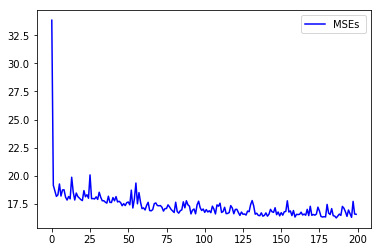

check point at 2019-04-26 07:06:20.609561
training : 臺東
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 22s - loss: 0.0032 - val_loss: 0.0018
Epoch : 0, MSE : [11.196427775082567]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0018 - val_loss: 0.0012
Epoch : 1, MSE : [7.7576357827688005]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0015 - val_loss: 0.0011
Epoch : 2, MSE : [6.850317136796535]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0014 - val_loss: 0.0011
Epoch : 3, MSE : [6.654332356074167]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0014 - val_loss: 0.0011
Epoch : 4, MSE : [6.719227783352236]
-------------------------------------------
Train on 23495 samples, validate on 5

 - 11s - loss: 0.0013 - val_loss: 0.0011
Epoch : 45, MSE : [6.532918580848834]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 46, MSE : [6.442278137539943]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0013 - val_loss: 0.0010
Epoch : 47, MSE : [6.424066942926019]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0013 - val_loss: 0.0011
Epoch : 48, MSE : [6.724473965233999]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 49, MSE : [6.519512176189023]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 50, MSE : [6.612955655498434]
-----------

Epoch : 90, MSE : [6.423236074104461]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 91, MSE : [6.386679822412766]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 92, MSE : [6.4592995085895915]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 93, MSE : [6.343161259057583]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 94, MSE : [6.515545741383855]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 95, MSE : [6.4056157987081415]
-------------------------------------------
Train 

Epoch : 135, MSE : [6.433838545344353]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 136, MSE : [6.401528781924372]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 137, MSE : [6.386865765217187]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 138, MSE : [6.363889692403388]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 139, MSE : [6.37615987926061]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 140, MSE : [6.560413450530098]
-------------------------------------------
Tra

 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 180, MSE : [6.407241370277155]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0011
Epoch : 181, MSE : [6.392258356878534]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 12s - loss: 0.0012 - val_loss: 0.0011
Epoch : 182, MSE : [6.758161774429376]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 183, MSE : [6.402194265979088]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 184, MSE : [6.380392334810635]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 11s - loss: 0.0012 - val_loss: 0.0010
Epoch : 185, MSE : [6.345150061514022]
-----

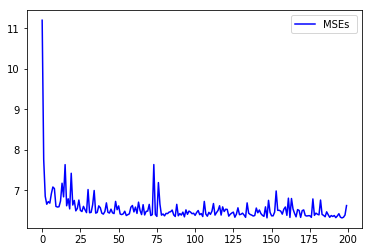

check point at 2019-04-26 07:51:19.048249
training : 花蓮
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 21s - loss: 0.0022 - val_loss: 0.0013
Epoch : 0, MSE : [17.232630449453218]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 0.0012 - val_loss: 8.6658e-04
Epoch : 1, MSE : [11.903307464362072]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 9.6619e-04 - val_loss: 8.3621e-04
Epoch : 2, MSE : [11.312527413261451]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 9.1684e-04 - val_loss: 7.7399e-04
Epoch : 3, MSE : [10.617701747506228]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.9873e-04 - val_loss: 7.5258e-04
Epoch : 4, MSE : [10.369818123654666]
-------------------------------------------
Train 

 - 10s - loss: 8.5083e-04 - val_loss: 7.5169e-04
Epoch : 43, MSE : [10.277685643487072]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.5376e-04 - val_loss: 7.7580e-04
Epoch : 44, MSE : [10.69145402003778]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.4926e-04 - val_loss: 7.7516e-04
Epoch : 45, MSE : [10.596199425817012]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.4341e-04 - val_loss: 7.5856e-04
Epoch : 46, MSE : [10.371715109334525]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.5548e-04 - val_loss: 7.4647e-04
Epoch : 47, MSE : [10.241731885840569]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.4465e-04 - val_loss: 7.3793e-

Epoch : 86, MSE : [10.175771801218472]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.2978e-04 - val_loss: 7.3430e-04
Epoch : 87, MSE : [9.990171219626193]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.2500e-04 - val_loss: 7.4430e-04
Epoch : 88, MSE : [10.153678490071421]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.3857e-04 - val_loss: 7.3433e-04
Epoch : 89, MSE : [9.978130827555697]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 11s - loss: 8.2070e-04 - val_loss: 7.3350e-04
Epoch : 90, MSE : [10.01438267190808]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.2760e-04 - val_loss: 7.2294e-04
Epoch : 91, MSE : [9.848188710890785]
----------

Epoch : 129, MSE : [9.72079387404471]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.1416e-04 - val_loss: 7.3090e-04
Epoch : 130, MSE : [9.899604615979984]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.1430e-04 - val_loss: 7.2940e-04
Epoch : 131, MSE : [9.932053957072155]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.2090e-04 - val_loss: 7.3894e-04
Epoch : 132, MSE : [10.082578833229427]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.1293e-04 - val_loss: 7.3452e-04
Epoch : 133, MSE : [9.930551215004321]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.1530e-04 - val_loss: 7.3818e-04
Epoch : 134, MSE : [10.015597268671986]
-----

Epoch : 172, MSE : [9.86025625826517]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.1100e-04 - val_loss: 7.2938e-04
Epoch : 173, MSE : [9.854809265046878]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.1556e-04 - val_loss: 7.2169e-04
Epoch : 174, MSE : [9.783270924067464]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.0437e-04 - val_loss: 7.5310e-04
Epoch : 175, MSE : [10.17515934563942]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.1169e-04 - val_loss: 7.1842e-04
Epoch : 176, MSE : [9.753125175249568]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 10s - loss: 8.0870e-04 - val_loss: 7.3935e-04
Epoch : 177, MSE : [10.033076856907892]
------

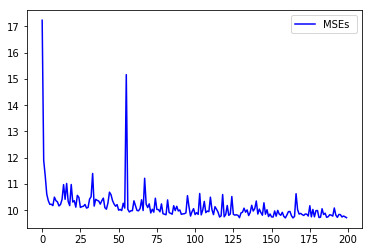

check point at 2019-04-26 08:31:09.790068
training : 關山
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 23s - loss: 0.0024 - val_loss: 0.0014
Epoch : 0, MSE : [9.127320412391628]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 0.0014 - val_loss: 9.0157e-04
Epoch : 1, MSE : [6.034430549224994]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 0.0011 - val_loss: 8.2031e-04
Epoch : 2, MSE : [5.439553571756258]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 0.0010 - val_loss: 8.2177e-04
Epoch : 3, MSE : [5.434622542837643]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.8989e-04 - val_loss: 8.5221e-04
Epoch : 4, MSE : [5.626636562259797]
-------------------------------------------
Train on 23188 samp

 - 11s - loss: 9.1912e-04 - val_loss: 8.1594e-04
Epoch : 43, MSE : [5.252479365466307]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.2724e-04 - val_loss: 8.3528e-04
Epoch : 44, MSE : [5.263212353422363]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.1423e-04 - val_loss: 8.1713e-04
Epoch : 45, MSE : [5.227391982918658]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.2318e-04 - val_loss: 8.6395e-04
Epoch : 46, MSE : [5.473784133198945]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.2527e-04 - val_loss: 8.3153e-04
Epoch : 47, MSE : [5.27921830042672]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.2403e-04 - val_loss: 8.7149e-04
Ep

Epoch : 86, MSE : [5.48648508073222]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.0752e-04 - val_loss: 8.1607e-04
Epoch : 87, MSE : [5.241221056977492]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 9.0467e-04 - val_loss: 8.1551e-04
Epoch : 88, MSE : [5.222189081714998]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 8.9573e-04 - val_loss: 7.9961e-04
Epoch : 89, MSE : [5.146884692203751]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 8.9833e-04 - val_loss: 8.3558e-04
Epoch : 90, MSE : [5.375208474625363]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 12s - loss: 8.9993e-04 - val_loss: 8.0042e-04
Epoch : 91, MSE : [5.17153672502429]
--------------

Epoch : 129, MSE : [5.095433434802357]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 8.9309e-04 - val_loss: 7.9748e-04
Epoch : 130, MSE : [5.10913603432764]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 8.9016e-04 - val_loss: 7.8977e-04
Epoch : 131, MSE : [5.0748441737151735]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 12s - loss: 8.9901e-04 - val_loss: 7.9544e-04
Epoch : 132, MSE : [5.112576391452565]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 8.9051e-04 - val_loss: 7.8843e-04
Epoch : 133, MSE : [5.088739517966357]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 8.8877e-04 - val_loss: 7.9914e-04
Epoch : 134, MSE : [5.144265532666]
---------

Epoch : 172, MSE : [5.121037354302881]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 11s - loss: 8.7494e-04 - val_loss: 8.1342e-04
Epoch : 173, MSE : [5.19645484858464]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 12s - loss: 8.7860e-04 - val_loss: 8.2063e-04
Epoch : 174, MSE : [5.153824293882235]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 12s - loss: 8.8407e-04 - val_loss: 8.1242e-04
Epoch : 175, MSE : [5.1522797441638355]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 12s - loss: 8.8639e-04 - val_loss: 7.9857e-04
Epoch : 176, MSE : [5.077829340045429]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 12s - loss: 8.7966e-04 - val_loss: 8.1528e-04
Epoch : 177, MSE : [5.223608242421807]
------

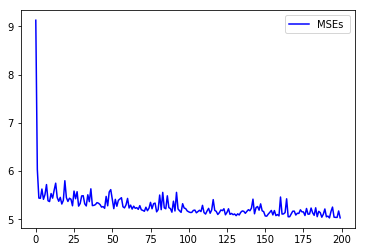

check point at 2019-04-26 09:17:02.818149
training : 金門
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 25s - loss: 6.4257e-04 - val_loss: 3.2278e-04
Epoch : 0, MSE : [60.4111844411814]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 2.7229e-04 - val_loss: 1.7445e-04
Epoch : 1, MSE : [33.06789001782974]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.8908e-04 - val_loss: 1.4882e-04
Epoch : 2, MSE : [27.720428670851636]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.7715e-04 - val_loss: 1.4896e-04
Epoch : 3, MSE : [27.424766422480968]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.7207e-04 - val_loss: 1.4797e-04
Epoch : 4, MSE : [26.737745169691017]
-----------------------------------------

 - 13s - loss: 1.5302e-04 - val_loss: 1.3590e-04
Epoch : 43, MSE : [25.31133477484363]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.5395e-04 - val_loss: 1.3344e-04
Epoch : 44, MSE : [27.145266263882316]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.5836e-04 - val_loss: 1.3975e-04
Epoch : 45, MSE : [27.83913425467458]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.5521e-04 - val_loss: 1.5528e-04
Epoch : 46, MSE : [26.83747244117733]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.5452e-04 - val_loss: 1.3018e-04
Epoch : 47, MSE : [24.887641643016035]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 14s - loss: 1.5666e-04 - val_loss: 1.2759e-04

Epoch : 86, MSE : [24.783133977837704]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.4822e-04 - val_loss: 1.3513e-04
Epoch : 87, MSE : [24.927674431676465]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.4926e-04 - val_loss: 1.2998e-04
Epoch : 88, MSE : [24.784876954102547]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.5381e-04 - val_loss: 1.2543e-04
Epoch : 89, MSE : [24.54472977701401]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.5473e-04 - val_loss: 1.2610e-04
Epoch : 90, MSE : [24.531020299685935]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.5098e-04 - val_loss: 1.5132e-04
Epoch : 91, MSE : [29.60171252314202]
--------

Epoch : 129, MSE : [24.63030815264379]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.4831e-04 - val_loss: 1.2674e-04
Epoch : 130, MSE : [24.46268232073521]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.4755e-04 - val_loss: 1.5045e-04
Epoch : 131, MSE : [26.577683548149007]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.4872e-04 - val_loss: 1.3940e-04
Epoch : 132, MSE : [26.245114941121386]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.4904e-04 - val_loss: 1.2975e-04
Epoch : 133, MSE : [25.297675197456876]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.4765e-04 - val_loss: 1.4333e-04
Epoch : 134, MSE : [26.458273829984243]
--

Epoch : 172, MSE : [24.927911024718256]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.4787e-04 - val_loss: 1.4579e-04
Epoch : 173, MSE : [26.30882845289153]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.4539e-04 - val_loss: 1.3593e-04
Epoch : 174, MSE : [25.21081738134075]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.4706e-04 - val_loss: 1.4164e-04
Epoch : 175, MSE : [26.216542798564962]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 12s - loss: 1.4654e-04 - val_loss: 1.3886e-04
Epoch : 176, MSE : [25.531434118600085]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 13s - loss: 1.5893e-04 - val_loss: 1.2682e-04
Epoch : 177, MSE : [24.6192189992191]
----

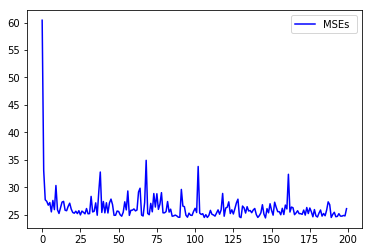

check point at 2019-04-26 10:06:52.479329
training : 馬公
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 24s - loss: 6.0302e-04 - val_loss: 4.3015e-04
Epoch : 0, MSE : [37.77631375057963]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 3.8907e-04 - val_loss: 3.5052e-04
Epoch : 1, MSE : [27.332829842175077]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 2.8058e-04 - val_loss: 3.0295e-04
Epoch : 2, MSE : [21.589604241351754]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 2.4664e-04 - val_loss: 4.1838e-04
Epoch : 3, MSE : [33.36067879074172]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 2.2565e-04 - val_loss: 2.4432e-04
Epoch : 4, MSE : [17.347278071890965]
----------------------------------------

 - 11s - loss: 1.9017e-04 - val_loss: 2.2476e-04
Epoch : 43, MSE : [15.823156937444573]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.8984e-04 - val_loss: 2.3312e-04
Epoch : 44, MSE : [16.549633786931118]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.8889e-04 - val_loss: 2.2201e-04
Epoch : 45, MSE : [15.756752564029203]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.8688e-04 - val_loss: 2.2593e-04
Epoch : 46, MSE : [15.891799067325927]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.8709e-04 - val_loss: 2.1688e-04
Epoch : 47, MSE : [15.506568632605328]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.8511e-04 - val_loss: 2.4151e

 - 11s - loss: 1.5002e-04 - val_loss: 2.8679e-04
Epoch : 86, MSE : [14.677222175320432]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.7530e-04 - val_loss: 3.0043e-04
Epoch : 87, MSE : [14.687236931435828]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.5322e-04 - val_loss: 3.5460e-04
Epoch : 88, MSE : [15.656725986861007]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.5211e-04 - val_loss: 2.4524e-04
Epoch : 89, MSE : [14.291497649229788]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.7360e-04 - val_loss: 3.3058e-04
Epoch : 90, MSE : [15.205652211151975]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4445e-04 - val_loss: 2.7428e

 - 11s - loss: 1.4712e-04 - val_loss: 4.3870e-04
Epoch : 129, MSE : [16.865370201566474]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4198e-04 - val_loss: 4.7194e-04
Epoch : 130, MSE : [17.33431086088062]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4360e-04 - val_loss: 3.9964e-04
Epoch : 131, MSE : [15.965808158040177]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4477e-04 - val_loss: 4.5895e-04
Epoch : 132, MSE : [17.297778909765796]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4596e-04 - val_loss: 3.3717e-04
Epoch : 133, MSE : [15.353898034947433]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.5647e-04 - val_loss: 4.0

 - 11s - loss: 1.4490e-04 - val_loss: 3.8780e-04
Epoch : 172, MSE : [15.642247341459036]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4164e-04 - val_loss: 4.8944e-04
Epoch : 173, MSE : [17.903020791569997]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4538e-04 - val_loss: 3.9593e-04
Epoch : 174, MSE : [16.463186853666958]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.4153e-04 - val_loss: 4.6460e-04
Epoch : 175, MSE : [17.622995567154025]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.5055e-04 - val_loss: 2.7843e-04
Epoch : 176, MSE : [15.137456709103622]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 11s - loss: 1.5050e-04 - val_loss: 3.

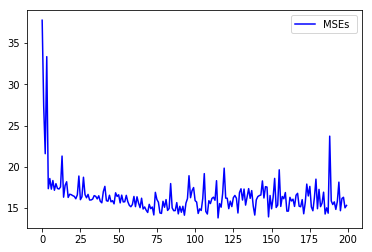

check point at 2019-04-26 10:50:51.104562
training : 馬祖
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 25s - loss: 0.0011 - val_loss: 4.7877e-04
Epoch : 0, MSE : [40.545711942045855]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 4.6405e-04 - val_loss: 2.9074e-04
Epoch : 1, MSE : [24.94258056495886]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 3.3394e-04 - val_loss: 2.3440e-04
Epoch : 2, MSE : [20.347291966650836]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 3.0473e-04 - val_loss: 2.4004e-04
Epoch : 3, MSE : [20.932800738008407]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 3.0293e-04 - val_loss: 2.9820e-04
Epoch : 4, MSE : [25.057224601276378]
-------------------------------------------

 - 13s - loss: 2.7468e-04 - val_loss: 2.0388e-04
Epoch : 43, MSE : [17.6631300180084]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.7310e-04 - val_loss: 2.3611e-04
Epoch : 44, MSE : [20.232581663786352]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.7357e-04 - val_loss: 2.0063e-04
Epoch : 45, MSE : [17.334266775027892]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.6554e-04 - val_loss: 1.9749e-04
Epoch : 46, MSE : [17.12604248734514]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 12s - loss: 2.7169e-04 - val_loss: 1.9598e-04
Epoch : 47, MSE : [17.049385329489663]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.6863e-04 - val_loss: 2.0605e-04

 - 13s - loss: 2.5655e-04 - val_loss: 1.9598e-04
Epoch : 86, MSE : [16.908070548719827]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.6054e-04 - val_loss: 2.1302e-04
Epoch : 87, MSE : [18.23547436747607]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.6223e-04 - val_loss: 2.0457e-04
Epoch : 88, MSE : [17.69806993154973]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.6558e-04 - val_loss: 2.4428e-04
Epoch : 89, MSE : [20.926837931566567]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5629e-04 - val_loss: 2.0332e-04
Epoch : 90, MSE : [17.598148145231434]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5624e-04 - val_loss: 1.9849e-0

 - 13s - loss: 2.4594e-04 - val_loss: 2.0196e-04
Epoch : 129, MSE : [17.361300492210503]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5412e-04 - val_loss: 2.0083e-04
Epoch : 130, MSE : [17.315233264199524]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5051e-04 - val_loss: 2.0500e-04
Epoch : 131, MSE : [17.715813200047386]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5333e-04 - val_loss: 1.9698e-04
Epoch : 132, MSE : [16.989095522587185]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.4985e-04 - val_loss: 2.0120e-04
Epoch : 133, MSE : [17.27671179314954]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5693e-04 - val_loss: 2.1

 - 13s - loss: 2.5036e-04 - val_loss: 1.9437e-04
Epoch : 172, MSE : [16.79085529616262]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5376e-04 - val_loss: 2.2034e-04
Epoch : 173, MSE : [18.807266390373883]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.4904e-04 - val_loss: 1.9926e-04
Epoch : 174, MSE : [17.11824996068713]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.4480e-04 - val_loss: 2.0204e-04
Epoch : 175, MSE : [17.397816829725627]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.5891e-04 - val_loss: 1.9494e-04
Epoch : 176, MSE : [16.7684224304484]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 13s - loss: 2.4615e-04 - val_loss: 1.9822

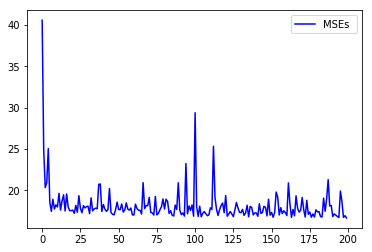

check point at 2019-04-26 11:41:25.699597
training : 臺南
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 25s - loss: 0.0032 - val_loss: 0.0017
Epoch : 0, MSE : [63.77809188011067]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 0.0014 - val_loss: 9.3439e-04
Epoch : 1, MSE : [34.47180912845001]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 0.0011 - val_loss: 8.9980e-04
Epoch : 2, MSE : [32.84635655294476]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 0.0011 - val_loss: 9.2603e-04
Epoch : 3, MSE : [33.71305508200719]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 0.0011 - val_loss: 8.6714e-04
Epoch : 4, MSE : [31.447868968979932]
-------------------------------------------
Train on 20749 samples

 - 12s - loss: 9.3288e-04 - val_loss: 8.1556e-04
Epoch : 43, MSE : [29.709951163571787]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.2007e-04 - val_loss: 8.4411e-04
Epoch : 44, MSE : [30.754046187650086]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.3899e-04 - val_loss: 8.3862e-04
Epoch : 45, MSE : [30.677390336262906]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.3232e-04 - val_loss: 8.2742e-04
Epoch : 46, MSE : [30.0478500841683]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.0682e-04 - val_loss: 8.3308e-04
Epoch : 47, MSE : [30.424931251680796]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.1606e-04 - val_loss: 8.7308e-0

 - 12s - loss: 9.0683e-04 - val_loss: 8.0672e-04
Epoch : 86, MSE : [29.247824821300707]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.9320e-04 - val_loss: 8.1453e-04
Epoch : 87, MSE : [29.536189288314375]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.9672e-04 - val_loss: 8.1592e-04
Epoch : 88, MSE : [29.521114485543944]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.0804e-04 - val_loss: 8.2279e-04
Epoch : 89, MSE : [29.848992952431757]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.0493e-04 - val_loss: 8.0063e-04
Epoch : 90, MSE : [29.09190347247644]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 9.0047e-04 - val_loss: 8.1572e-

 - 12s - loss: 8.7819e-04 - val_loss: 8.0773e-04
Epoch : 129, MSE : [29.4801042459598]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.7492e-04 - val_loss: 7.9186e-04
Epoch : 130, MSE : [28.668971610163396]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.7623e-04 - val_loss: 8.2173e-04
Epoch : 131, MSE : [29.976598997756415]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.7999e-04 - val_loss: 8.0104e-04
Epoch : 132, MSE : [29.150170461327697]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.8464e-04 - val_loss: 8.3007e-04
Epoch : 133, MSE : [30.238247034539214]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.8396e-04 - val_loss: 7.93

 - 12s - loss: 8.6530e-04 - val_loss: 7.8482e-04
Epoch : 172, MSE : [28.406422983989348]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.6737e-04 - val_loss: 7.9362e-04
Epoch : 173, MSE : [28.771004293150998]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.6360e-04 - val_loss: 7.8986e-04
Epoch : 174, MSE : [28.70350396435281]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.7423e-04 - val_loss: 7.8453e-04
Epoch : 175, MSE : [28.49836727076354]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.6496e-04 - val_loss: 8.0083e-04
Epoch : 176, MSE : [29.122036183212153]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 12s - loss: 8.7469e-04 - val_loss: 7.88

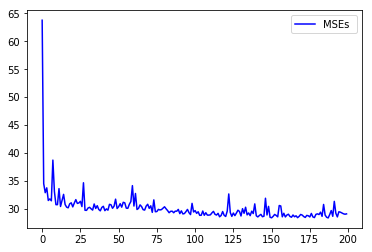

check point at 2019-04-26 12:28:35.553873
training : 臺西
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 26s - loss: 0.0027 - val_loss: 0.0012
Epoch : 0, MSE : [52.29481521687849]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 0.0012 - val_loss: 6.8280e-04
Epoch : 1, MSE : [30.182705116366908]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 8.6911e-04 - val_loss: 6.0558e-04
Epoch : 2, MSE : [26.085691693549535]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 8.2215e-04 - val_loss: 6.2796e-04
Epoch : 3, MSE : [26.814166593987323]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 8.0661e-04 - val_loss: 6.3699e-04
Epoch : 4, MSE : [26.91615077969303]
-------------------------------------------
Train on

 - 13s - loss: 7.2707e-04 - val_loss: 6.3427e-04
Epoch : 43, MSE : [25.84265853862311]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 7.3698e-04 - val_loss: 6.1637e-04
Epoch : 44, MSE : [25.346839796537083]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 7.2413e-04 - val_loss: 6.5837e-04
Epoch : 45, MSE : [25.971960379464612]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 7.2370e-04 - val_loss: 6.4146e-04
Epoch : 46, MSE : [25.62127978938624]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 7.2724e-04 - val_loss: 6.7320e-04
Epoch : 47, MSE : [26.76267360273641]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 7.1627e-04 - val_loss: 6.3196e-04

 - 13s - loss: 6.9227e-04 - val_loss: 5.6833e-04
Epoch : 86, MSE : [24.978279770928772]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.9074e-04 - val_loss: 6.2009e-04
Epoch : 87, MSE : [26.739585084052475]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.9379e-04 - val_loss: 5.5672e-04
Epoch : 88, MSE : [24.046919937909937]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.9672e-04 - val_loss: 5.6928e-04
Epoch : 89, MSE : [24.483259261018397]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.8325e-04 - val_loss: 5.7448e-04
Epoch : 90, MSE : [25.19760971936386]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.9411e-04 - val_loss: 5.7697e-

 - 13s - loss: 6.8135e-04 - val_loss: 5.2804e-04
Epoch : 129, MSE : [23.210153614167275]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.6568e-04 - val_loss: 5.6432e-04
Epoch : 130, MSE : [24.185815325999542]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.7382e-04 - val_loss: 5.4191e-04
Epoch : 131, MSE : [23.58904871481694]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.6672e-04 - val_loss: 5.3493e-04
Epoch : 132, MSE : [23.29758576828775]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.6984e-04 - val_loss: 5.4115e-04
Epoch : 133, MSE : [23.720314801336166]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.7754e-04 - val_loss: 5.74

 - 13s - loss: 6.6373e-04 - val_loss: 5.6494e-04
Epoch : 172, MSE : [24.527796395424588]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.6768e-04 - val_loss: 5.7140e-04
Epoch : 173, MSE : [24.2449369444092]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.5423e-04 - val_loss: 5.4663e-04
Epoch : 174, MSE : [23.514753250580956]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.6086e-04 - val_loss: 5.4803e-04
Epoch : 175, MSE : [23.347611762324448]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.5777e-04 - val_loss: 5.2523e-04
Epoch : 176, MSE : [22.75986549852672]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 13s - loss: 6.6087e-04 - val_loss: 5.289

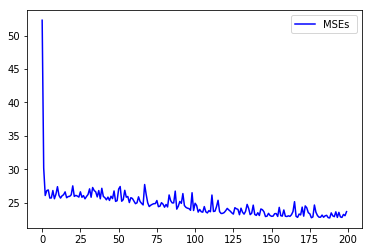

check point at 2019-04-26 13:19:44.445406
training : 善化
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 27s - loss: 0.0030 - val_loss: 0.0016
Epoch : 0, MSE : [54.285208049613]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0015 - val_loss: 0.0011
Epoch : 1, MSE : [39.32022364269388]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0013 - val_loss: 0.0012
Epoch : 2, MSE : [39.10705501735246]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0013 - val_loss: 0.0011
Epoch : 3, MSE : [38.554487230832535]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0012 - val_loss: 0.0011
Epoch : 4, MSE : [37.17863399973791]
-------------------------------------------
Train on 22324 samples, validate on 5581

 - 14s - loss: 0.0011 - val_loss: 0.0010
Epoch : 45, MSE : [35.123813664127695]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 46, MSE : [35.73503860899957]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 47, MSE : [35.44473097646301]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0011 - val_loss: 0.0010
Epoch : 48, MSE : [36.018963223866564]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0011
Epoch : 49, MSE : [37.82945089626351]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0011 - val_loss: 0.0011
Epoch : 50, MSE : [35.54844231337679]
---------

 - 14s - loss: 0.0011 - val_loss: 0.0011
Epoch : 90, MSE : [37.40369624085704]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0011
Epoch : 91, MSE : [35.603378022257615]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 92, MSE : [35.054173225991775]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 93, MSE : [35.19065544450519]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0011
Epoch : 94, MSE : [35.69330877732399]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 95, MSE : [35.08674377319155]
---------

 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 135, MSE : [34.52017682729575]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 136, MSE : [35.0028049704337]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 137, MSE : [34.52237540629667]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0011 - val_loss: 0.0010
Epoch : 138, MSE : [34.67903569190743]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 15s - loss: 0.0011 - val_loss: 0.0010
Epoch : 139, MSE : [34.407002016085045]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 14s - loss: 0.0011 - val_loss: 0.0011
Epoch : 140, MSE : [36.26570168839235]
-----

 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 180, MSE : [34.46135043378877]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 181, MSE : [34.938242637915124]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 182, MSE : [34.782645581615036]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 183, MSE : [34.15536681471023]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 184, MSE : [34.480011657367974]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 13s - loss: 0.0011 - val_loss: 0.0010
Epoch : 185, MSE : [34.71337503234928]
--

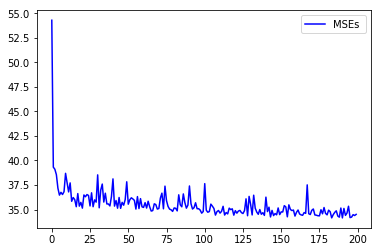

check point at 2019-04-26 14:13:18.620840
training : 嘉義
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 28s - loss: 0.0037 - val_loss: 0.0020
Epoch : 0, MSE : [79.32587262072656]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0018 - val_loss: 0.0012
Epoch : 1, MSE : [50.066383222422814]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0014 - val_loss: 0.0012
Epoch : 2, MSE : [47.73230377650631]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0014 - val_loss: 0.0012
Epoch : 3, MSE : [46.45186236002943]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0013 - val_loss: 0.0012
Epoch : 4, MSE : [46.91200152060245]
-------------------------------------------
Train on 20807 samples, validate on 52

 - 15s - loss: 0.0012 - val_loss: 0.0012
Epoch : 45, MSE : [45.520535905061784]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 46, MSE : [43.951220095172495]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 47, MSE : [44.805756528979146]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 48, MSE : [44.24861084791146]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 49, MSE : [43.63781493571004]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0012
Epoch : 50, MSE : [45.77031864141955]
--------

 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 90, MSE : [43.849723485369104]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 91, MSE : [44.47005597429551]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 92, MSE : [43.8954071163906]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 93, MSE : [44.01793447651783]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 94, MSE : [43.8741845535091]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 95, MSE : [43.66918390895271]
------------

 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 135, MSE : [43.15568222348151]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 136, MSE : [45.19855899146033]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 137, MSE : [43.634808795272804]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 138, MSE : [44.15909826112785]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0012
Epoch : 139, MSE : [47.61350310962924]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 140, MSE : [45.005005311207036]
---

 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 180, MSE : [43.14029882961131]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 181, MSE : [44.777641085448394]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 182, MSE : [43.04117976111396]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 183, MSE : [42.86078437866038]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 16s - loss: 0.0012 - val_loss: 0.0011
Epoch : 184, MSE : [43.58539071936513]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 16s - loss: 0.0012 - val_loss: 0.0011
Epoch : 185, MSE : [42.875430050784175]
---

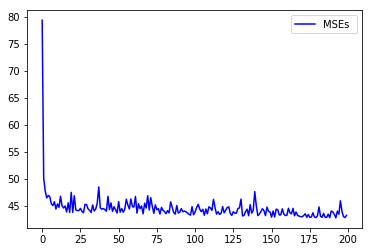

check point at 2019-04-26 15:12:04.093296
training : 安南
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 30s - loss: 0.0031 - val_loss: 0.0014
Epoch : 0, MSE : [48.62686224555207]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0014 - val_loss: 9.7948e-04
Epoch : 1, MSE : [35.06904915168859]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 9.6388e-04
Epoch : 2, MSE : [34.90802553995674]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0012 - val_loss: 0.0011
Epoch : 3, MSE : [40.01383525152904]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0011 - val_loss: 9.1803e-04
Epoch : 4, MSE : [32.812601155654214]
-------------------------------------------
Train on 22669 samples, va

 - 15s - loss: 0.0010 - val_loss: 8.6301e-04
Epoch : 44, MSE : [31.04021200580772]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0010 - val_loss: 8.8569e-04
Epoch : 45, MSE : [31.645136383355872]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0010 - val_loss: 8.6486e-04
Epoch : 46, MSE : [31.046050541450697]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0010 - val_loss: 8.8704e-04
Epoch : 47, MSE : [32.0929294498539]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0010 - val_loss: 8.6545e-04
Epoch : 48, MSE : [31.215576565526234]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0010 - val_loss: 8.7093e-04
Epoch : 49, MSE : [31.2

 - 15s - loss: 0.0010 - val_loss: 8.7012e-04
Epoch : 88, MSE : [31.001404777344295]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.9992e-04 - val_loss: 8.9386e-04
Epoch : 89, MSE : [31.59746807681473]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.8729e-04 - val_loss: 8.8141e-04
Epoch : 90, MSE : [31.808682482665265]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.9711e-04 - val_loss: 8.6007e-04
Epoch : 91, MSE : [30.931163007112865]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 0.0010 - val_loss: 8.6033e-04
Epoch : 92, MSE : [30.91547964802658]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.9894e-04 - val_loss: 8.6357e-04
Epoch 

 - 15s - loss: 9.7676e-04 - val_loss: 8.6980e-04
Epoch : 131, MSE : [30.74466299587482]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 14s - loss: 9.8294e-04 - val_loss: 8.5045e-04
Epoch : 132, MSE : [30.555319885332594]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.9201e-04 - val_loss: 8.6808e-04
Epoch : 133, MSE : [31.114548132928345]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.7967e-04 - val_loss: 8.7101e-04
Epoch : 134, MSE : [31.158765149842303]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.7919e-04 - val_loss: 8.6621e-04
Epoch : 135, MSE : [31.05039997098514]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.9114e-04 - val_loss: 8.77

 - 14s - loss: 9.6169e-04 - val_loss: 8.6196e-04
Epoch : 174, MSE : [30.576915666346814]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 14s - loss: 9.8069e-04 - val_loss: 8.6086e-04
Epoch : 175, MSE : [30.81961428924963]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.8397e-04 - val_loss: 9.2492e-04
Epoch : 176, MSE : [32.40226921832324]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.7675e-04 - val_loss: 8.5690e-04
Epoch : 177, MSE : [30.483673091658517]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.7646e-04 - val_loss: 8.5618e-04
Epoch : 178, MSE : [30.363353891703717]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 15s - loss: 9.6973e-04 - val_loss: 8.90

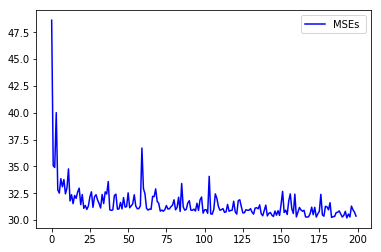

check point at 2019-04-26 16:10:30.731981
training : 崙背
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 36s - loss: 0.0029 - val_loss: 0.0015
Epoch : 0, MSE : [59.80674020705689]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 0.0013 - val_loss: 0.0010
Epoch : 1, MSE : [43.68053509974894]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 0.0011 - val_loss: 9.2489e-04
Epoch : 2, MSE : [38.91763513735506]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 0.0011 - val_loss: 9.2214e-04
Epoch : 3, MSE : [38.80549432243605]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 0.0011 - val_loss: 9.2919e-04
Epoch : 4, MSE : [39.12545537690497]
-------------------------------------------
Train on 22266 samples, val

 - 15s - loss: 9.7193e-04 - val_loss: 9.3279e-04
Epoch : 43, MSE : [39.35179278408202]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.8100e-04 - val_loss: 8.5860e-04
Epoch : 44, MSE : [35.79509383908599]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.7497e-04 - val_loss: 8.5454e-04
Epoch : 45, MSE : [35.87445679117047]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.8334e-04 - val_loss: 8.5636e-04
Epoch : 46, MSE : [35.732639178857056]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 9.7775e-04 - val_loss: 8.5961e-04
Epoch : 47, MSE : [35.991453079343934]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.6420e-04 - val_loss: 8.5536e-04

Epoch : 86, MSE : [35.66023406057211]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 9.5025e-04 - val_loss: 8.8513e-04
Epoch : 87, MSE : [36.71919873882711]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 9.4604e-04 - val_loss: 8.7158e-04
Epoch : 88, MSE : [36.14221303067814]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 9.5043e-04 - val_loss: 8.6684e-04
Epoch : 89, MSE : [35.819113150759286]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 9.4668e-04 - val_loss: 8.5030e-04
Epoch : 90, MSE : [35.55637947848911]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 9.3963e-04 - val_loss: 8.5515e-04
Epoch : 91, MSE : [35.595626895687275]
----------

Epoch : 129, MSE : [34.828678911625985]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.4764e-04 - val_loss: 8.3642e-04
Epoch : 130, MSE : [34.866682404260075]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.2524e-04 - val_loss: 8.4101e-04
Epoch : 131, MSE : [35.08188465374352]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 16s - loss: 9.4014e-04 - val_loss: 8.5492e-04
Epoch : 132, MSE : [35.261462878129976]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.3430e-04 - val_loss: 8.5656e-04
Epoch : 133, MSE : [35.700862690856056]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.3602e-04 - val_loss: 8.4127e-04
Epoch : 134, MSE : [34.9015461371116]
---

Epoch : 172, MSE : [34.929045813458174]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.1913e-04 - val_loss: 8.3514e-04
Epoch : 173, MSE : [34.67192136957556]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.3120e-04 - val_loss: 8.6622e-04
Epoch : 174, MSE : [35.69710159501083]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.2321e-04 - val_loss: 8.3427e-04
Epoch : 175, MSE : [34.58795678030229]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.1795e-04 - val_loss: 8.4029e-04
Epoch : 176, MSE : [34.77357754741734]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 15s - loss: 9.2421e-04 - val_loss: 8.4104e-04
Epoch : 177, MSE : [35.04843050364116]
-----

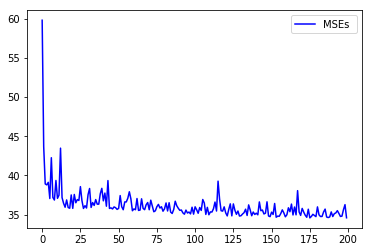

check point at 2019-04-26 17:11:29.106841
training : 斗六
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 36s - loss: 0.0033 - val_loss: 0.0016
Epoch : 0, MSE : [70.75813196790473]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 0.0014 - val_loss: 0.0010
Epoch : 1, MSE : [43.667877587833324]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.8465e-04
Epoch : 2, MSE : [41.48059094366871]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.4127e-04
Epoch : 3, MSE : [39.99919532483316]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 0.0010 - val_loss: 9.4113e-04
Epoch : 4, MSE : [40.09674672669808]
-------------------------------------------
Train on 21959 samples, va

 - 17s - loss: 9.4653e-04 - val_loss: 8.9610e-04
Epoch : 43, MSE : [37.79041950557391]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.3669e-04 - val_loss: 8.8653e-04
Epoch : 44, MSE : [37.06789232435025]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.4811e-04 - val_loss: 8.7245e-04
Epoch : 45, MSE : [36.56645295260887]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.3098e-04 - val_loss: 8.8514e-04
Epoch : 46, MSE : [37.15159837096822]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.4304e-04 - val_loss: 8.8531e-04
Epoch : 47, MSE : [37.07966822391322]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.3433e-04 - val_loss: 8.7696e-04
E

Epoch : 86, MSE : [36.315436563521644]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.1648e-04 - val_loss: 9.0601e-04
Epoch : 87, MSE : [37.95695634997279]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.2323e-04 - val_loss: 8.8430e-04
Epoch : 88, MSE : [36.895298796256995]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.2376e-04 - val_loss: 8.6893e-04
Epoch : 89, MSE : [36.30375695532075]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.2811e-04 - val_loss: 9.0726e-04
Epoch : 90, MSE : [37.75978976964105]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.2881e-04 - val_loss: 8.8885e-04
Epoch : 91, MSE : [37.19220539332428]
----------

Epoch : 129, MSE : [36.407321945376374]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.0721e-04 - val_loss: 8.9135e-04
Epoch : 130, MSE : [37.16286196487037]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.0834e-04 - val_loss: 8.8365e-04
Epoch : 131, MSE : [36.81628211913712]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.1071e-04 - val_loss: 8.7577e-04
Epoch : 132, MSE : [36.37125533742656]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.0486e-04 - val_loss: 8.7179e-04
Epoch : 133, MSE : [36.50411464949789]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.1110e-04 - val_loss: 8.7952e-04
Epoch : 134, MSE : [36.83435409687878]
-----

Epoch : 172, MSE : [36.09440614906383]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.0144e-04 - val_loss: 8.6624e-04
Epoch : 173, MSE : [35.983951118044345]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 18s - loss: 9.0582e-04 - val_loss: 8.8404e-04
Epoch : 174, MSE : [36.594775325910454]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.1446e-04 - val_loss: 8.9698e-04
Epoch : 175, MSE : [37.36865867227315]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.0797e-04 - val_loss: 8.6776e-04
Epoch : 176, MSE : [36.25533339889065]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 17s - loss: 9.0465e-04 - val_loss: 9.1589e-04
Epoch : 177, MSE : [38.2370525436249]
-----

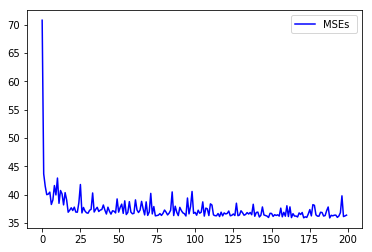

check point at 2019-04-26 18:18:08.606405
training : 新港
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 36s - loss: 0.0019 - val_loss: 9.9452e-04
Epoch : 0, MSE : [51.6441669550688]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 8.6644e-04 - val_loss: 6.7638e-04
Epoch : 1, MSE : [33.84549980397209]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 7.2179e-04 - val_loss: 6.5213e-04
Epoch : 2, MSE : [32.564709758878884]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 6.7348e-04 - val_loss: 6.2942e-04
Epoch : 3, MSE : [31.636563453743243]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 6.7792e-04 - val_loss: 6.7177e-04
Epoch : 4, MSE : [33.890380817100024]
-------------------------------------------
T

 - 17s - loss: 6.0223e-04 - val_loss: 6.2397e-04
Epoch : 43, MSE : [30.45903805975863]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 6.0241e-04 - val_loss: 6.2055e-04
Epoch : 44, MSE : [29.96358875151624]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 6.0464e-04 - val_loss: 6.2005e-04
Epoch : 45, MSE : [30.166474869106008]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 6.0541e-04 - val_loss: 6.1553e-04
Epoch : 46, MSE : [30.055420431024086]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.9839e-04 - val_loss: 6.3111e-04
Epoch : 47, MSE : [30.64459590863959]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 6.0527e-04 - val_loss: 6.4521e-04

 - 17s - loss: 5.9845e-04 - val_loss: 6.0551e-04
Epoch : 86, MSE : [29.83384597870821]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.9406e-04 - val_loss: 6.1540e-04
Epoch : 87, MSE : [30.00905037345871]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.9019e-04 - val_loss: 6.6644e-04
Epoch : 88, MSE : [32.88181779854827]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.8651e-04 - val_loss: 6.0727e-04
Epoch : 89, MSE : [29.423006307346302]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.9943e-04 - val_loss: 6.4622e-04
Epoch : 90, MSE : [31.67256782694922]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.9889e-04 - val_loss: 6.2524e-04


 - 17s - loss: 5.8212e-04 - val_loss: 6.0625e-04
Epoch : 129, MSE : [29.68386341196137]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.8234e-04 - val_loss: 6.0774e-04
Epoch : 130, MSE : [29.38591633764926]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.7675e-04 - val_loss: 6.0806e-04
Epoch : 131, MSE : [29.27964720584546]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.8231e-04 - val_loss: 6.0824e-04
Epoch : 132, MSE : [29.471378211745503]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.8584e-04 - val_loss: 6.0808e-04
Epoch : 133, MSE : [29.492448067696515]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 16s - loss: 5.8355e-04 - val_loss: 6.141

 - 17s - loss: 5.7109e-04 - val_loss: 6.0818e-04
Epoch : 172, MSE : [29.3654489933644]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.7316e-04 - val_loss: 6.0836e-04
Epoch : 173, MSE : [29.300551786554287]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.7339e-04 - val_loss: 6.0441e-04
Epoch : 174, MSE : [29.115492060886154]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.9120e-04 - val_loss: 6.1433e-04
Epoch : 175, MSE : [29.75710018530755]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.7301e-04 - val_loss: 6.1549e-04
Epoch : 176, MSE : [29.940232715229445]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 17s - loss: 5.6957e-04 - val_loss: 6.102

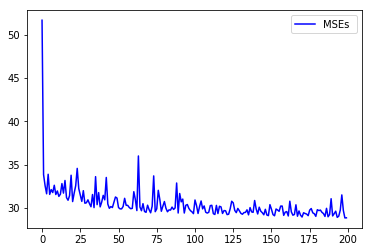

check point at 2019-04-26 19:24:46.267732
training : 新營
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 36s - loss: 0.0029 - val_loss: 0.0014
Epoch : 0, MSE : [52.179483553005156]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 9.5927e-04
Epoch : 1, MSE : [33.77886619176344]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 19s - loss: 0.0011 - val_loss: 9.3818e-04
Epoch : 2, MSE : [33.062627742796835]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 19s - loss: 0.0010 - val_loss: 8.8815e-04
Epoch : 3, MSE : [31.090286262690494]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 19s - loss: 9.6950e-04 - val_loss: 8.9010e-04
Epoch : 4, MSE : [31.157381388516885]
-------------------------------------------
Train on 22823 

 - 18s - loss: 8.8499e-04 - val_loss: 8.4760e-04
Epoch : 43, MSE : [29.643537557562418]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 18s - loss: 8.9154e-04 - val_loss: 8.5144e-04
Epoch : 44, MSE : [29.770743130722312]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 18s - loss: 8.9588e-04 - val_loss: 8.6603e-04
Epoch : 45, MSE : [30.266378423641292]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 18s - loss: 8.9488e-04 - val_loss: 8.6341e-04
Epoch : 46, MSE : [30.39484875162253]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.8731e-04 - val_loss: 8.5744e-04
Epoch : 47, MSE : [30.009493706434768]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 18s - loss: 8.9951e-04 - val_loss: 8.7462e-

 - 17s - loss: 8.7796e-04 - val_loss: 8.5467e-04
Epoch : 86, MSE : [30.054985949813034]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.7944e-04 - val_loss: 8.3366e-04
Epoch : 87, MSE : [29.1063632976305]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 16s - loss: 8.8265e-04 - val_loss: 8.2678e-04
Epoch : 88, MSE : [28.909753400411233]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.8395e-04 - val_loss: 8.5002e-04
Epoch : 89, MSE : [29.668340339242846]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.8915e-04 - val_loss: 8.2410e-04
Epoch : 90, MSE : [28.9707546724126]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.7079e-04 - val_loss: 8.3047e-04


 - 17s - loss: 8.5491e-04 - val_loss: 8.2467e-04
Epoch : 129, MSE : [29.120249558515372]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.5408e-04 - val_loss: 8.1243e-04
Epoch : 130, MSE : [28.303863523219615]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.6261e-04 - val_loss: 8.8507e-04
Epoch : 131, MSE : [30.900034354594144]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.5300e-04 - val_loss: 8.3792e-04
Epoch : 132, MSE : [29.23222242812106]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.4909e-04 - val_loss: 8.2622e-04
Epoch : 133, MSE : [28.806163745366753]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.6204e-04 - val_loss: 8.3

 - 17s - loss: 8.4683e-04 - val_loss: 8.0708e-04
Epoch : 172, MSE : [28.26409358078115]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.4232e-04 - val_loss: 8.2645e-04
Epoch : 173, MSE : [28.981524282734483]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.4445e-04 - val_loss: 8.1955e-04
Epoch : 174, MSE : [28.52913192209709]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.4081e-04 - val_loss: 8.3613e-04
Epoch : 175, MSE : [29.33307197202211]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.3686e-04 - val_loss: 8.2165e-04
Epoch : 176, MSE : [28.671896417540548]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 17s - loss: 8.3785e-04 - val_loss: 8.099

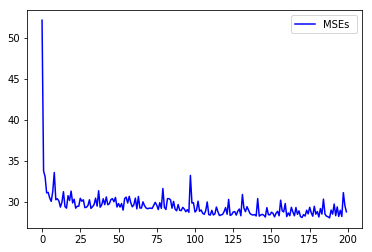

check point at 2019-04-26 20:33:04.331721
training : 朴子
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 36s - loss: 0.0025 - val_loss: 0.0014
Epoch : 0, MSE : [60.8812586157106]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 0.0013 - val_loss: 9.9634e-04
Epoch : 1, MSE : [45.02552209957376]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 0.0011 - val_loss: 9.3586e-04
Epoch : 2, MSE : [42.50241163487903]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.1311e-04
Epoch : 3, MSE : [42.00143245650662]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 17s - loss: 0.0010 - val_loss: 9.0859e-04
Epoch : 4, MSE : [41.91228904580412]
-------------------------------------------
Train on 22650 samples, 

 - 18s - loss: 9.1911e-04 - val_loss: 9.3516e-04
Epoch : 43, MSE : [39.563708710500755]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 9.2018e-04 - val_loss: 9.2337e-04
Epoch : 44, MSE : [38.83884925358043]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 9.2223e-04 - val_loss: 9.6019e-04
Epoch : 45, MSE : [40.553052669156045]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 9.2007e-04 - val_loss: 9.3373e-04
Epoch : 46, MSE : [39.36231171972047]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 9.2134e-04 - val_loss: 9.2902e-04
Epoch : 47, MSE : [39.09521687164748]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 9.1933e-04 - val_loss: 9.3286e-04

Epoch : 86, MSE : [37.22977249012753]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 17s - loss: 8.9264e-04 - val_loss: 8.4286e-04
Epoch : 87, MSE : [37.83182274015007]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.9539e-04 - val_loss: 8.4604e-04
Epoch : 88, MSE : [38.1992530472317]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.7709e-04 - val_loss: 8.6787e-04
Epoch : 89, MSE : [39.31326915232054]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 17s - loss: 8.8936e-04 - val_loss: 8.3421e-04
Epoch : 90, MSE : [37.74143559953867]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 17s - loss: 8.9649e-04 - val_loss: 8.3715e-04
Epoch : 91, MSE : [37.713943258606]
---------------

Epoch : 129, MSE : [37.906639637987645]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 17s - loss: 8.7864e-04 - val_loss: 8.2834e-04
Epoch : 130, MSE : [37.21825105542772]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 17s - loss: 8.6877e-04 - val_loss: 8.2684e-04
Epoch : 131, MSE : [37.19693122607498]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.7004e-04 - val_loss: 8.2376e-04
Epoch : 132, MSE : [37.02420739663547]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.7364e-04 - val_loss: 8.2530e-04
Epoch : 133, MSE : [37.18927517959136]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.6507e-04 - val_loss: 8.1975e-04
Epoch : 134, MSE : [36.86030285905908]
-----

Epoch : 172, MSE : [37.43444497883094]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.6536e-04 - val_loss: 8.1222e-04
Epoch : 173, MSE : [36.47524819601103]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.6649e-04 - val_loss: 8.1685e-04
Epoch : 174, MSE : [36.58617859842771]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.5290e-04 - val_loss: 8.1089e-04
Epoch : 175, MSE : [36.495131218867705]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.6266e-04 - val_loss: 8.1779e-04
Epoch : 176, MSE : [36.658296298656296]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 18s - loss: 8.6136e-04 - val_loss: 8.1638e-04
Epoch : 177, MSE : [36.72446695874124]
----

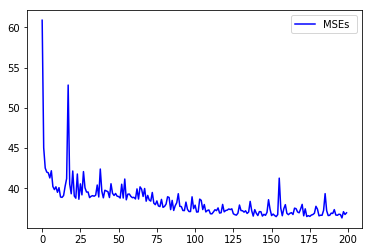

check point at 2019-04-26 21:43:03.149830
training : 麥寮
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 38s - loss: 0.0032 - val_loss: 0.0017
Epoch : 0, MSE : [51.88092930022219]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 20s - loss: 0.0014 - val_loss: 8.7746e-04
Epoch : 1, MSE : [28.0938790944098]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 0.0010 - val_loss: 8.3825e-04
Epoch : 2, MSE : [26.646872160338535]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 9.9796e-04 - val_loss: 9.0405e-04
Epoch : 3, MSE : [28.487456099962348]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 9.8606e-04 - val_loss: 8.2783e-04
Epoch : 4, MSE : [26.20839251404287]
-------------------------------------------
Train on 22285

 - 17s - loss: 8.7713e-04 - val_loss: 7.8034e-04
Epoch : 43, MSE : [25.08185415111021]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.7058e-04 - val_loss: 7.8413e-04
Epoch : 44, MSE : [25.151452445971593]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.6672e-04 - val_loss: 7.8158e-04
Epoch : 45, MSE : [24.976918880845368]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.6241e-04 - val_loss: 7.5879e-04
Epoch : 46, MSE : [24.25710815379091]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.7244e-04 - val_loss: 7.6363e-04
Epoch : 47, MSE : [24.299650858109235]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.6753e-04 - val_loss: 7.7963e-0

Epoch : 86, MSE : [23.601571533778714]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.0125e-04 - val_loss: 7.6666e-04
Epoch : 87, MSE : [23.682697944216354]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.2376e-04 - val_loss: 7.3945e-04
Epoch : 88, MSE : [22.795001983846337]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.1204e-04 - val_loss: 7.3924e-04
Epoch : 89, MSE : [22.794619066166803]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.2439e-04 - val_loss: 7.4686e-04
Epoch : 90, MSE : [23.038708997556746]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 8.0901e-04 - val_loss: 7.5413e-04
Epoch : 91, MSE : [23.177177162488487]
------

Epoch : 129, MSE : [22.311099105709413]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 16s - loss: 7.9883e-04 - val_loss: 7.2652e-04
Epoch : 130, MSE : [22.277384665797396]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 16s - loss: 8.0584e-04 - val_loss: 7.4075e-04
Epoch : 131, MSE : [22.748215345925168]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 16s - loss: 8.0721e-04 - val_loss: 7.3375e-04
Epoch : 132, MSE : [22.4179737177967]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 16s - loss: 7.9325e-04 - val_loss: 7.3783e-04
Epoch : 133, MSE : [22.550325563505613]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 16s - loss: 7.9807e-04 - val_loss: 7.3886e-04
Epoch : 134, MSE : [22.499887011911287]
--

Epoch : 172, MSE : [23.183999817013063]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 7.8504e-04 - val_loss: 8.2683e-04
Epoch : 173, MSE : [25.255812667707694]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 7.8524e-04 - val_loss: 7.4904e-04
Epoch : 174, MSE : [22.839034428287512]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 7.8719e-04 - val_loss: 7.3976e-04
Epoch : 175, MSE : [22.40727901224532]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 16s - loss: 7.9134e-04 - val_loss: 7.9743e-04
Epoch : 176, MSE : [24.122462000571826]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 17s - loss: 7.8918e-04 - val_loss: 7.3850e-04
Epoch : 177, MSE : [22.372178508104795]
-

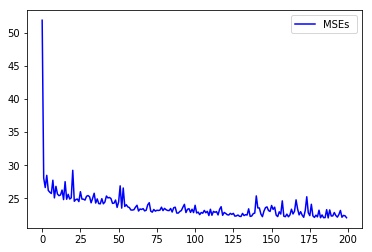

check point at 2019-04-26 22:48:57.557618
training : 仁武
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 36s - loss: 0.0048 - val_loss: 0.0023
Epoch : 0, MSE : [63.5940809448387]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0023 - val_loss: 0.0016
Epoch : 1, MSE : [44.735140675200796]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0019 - val_loss: 0.0016
Epoch : 2, MSE : [42.51525454606144]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0018 - val_loss: 0.0015
Epoch : 3, MSE : [40.45189338508107]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0018 - val_loss: 0.0015
Epoch : 4, MSE : [40.21265880612247]
-------------------------------------------
Train on 21844 samples, validate on 546

 - 16s - loss: 0.0016 - val_loss: 0.0015
Epoch : 45, MSE : [40.21948384336605]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 46, MSE : [38.43200487886711]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0015
Epoch : 47, MSE : [40.75239022095432]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 48, MSE : [38.24545921819554]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 49, MSE : [38.23882995795855]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 50, MSE : [38.2837407232152]
------------

 - 16s - loss: 0.0016 - val_loss: 0.0015
Epoch : 90, MSE : [39.70413167779074]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 91, MSE : [38.8614410104904]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 92, MSE : [37.90184195399273]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 93, MSE : [38.18540981586035]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 94, MSE : [38.273704367868554]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 95, MSE : [37.80133526791043]
-----------

 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 135, MSE : [37.296737512764956]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 136, MSE : [37.52374356552685]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 137, MSE : [37.63325139272288]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 138, MSE : [37.853625000058344]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 139, MSE : [37.75688260881156]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0014
Epoch : 140, MSE : [37.4122369657913]
----

 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 180, MSE : [37.349845340034506]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 181, MSE : [37.223764016035645]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 182, MSE : [37.9837978690243]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 183, MSE : [37.620132801311186]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 184, MSE : [38.66260739741206]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 16s - loss: 0.0015 - val_loss: 0.0014
Epoch : 185, MSE : [37.027712310884574]
--

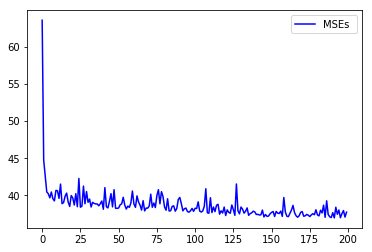

check point at 2019-04-26 23:51:54.584263
training : 前金
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 36s - loss: 0.0036 - val_loss: 0.0017
Epoch : 0, MSE : [67.17485419011697]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0016 - val_loss: 0.0011
Epoch : 1, MSE : [44.23191092136512]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0013 - val_loss: 0.0011
Epoch : 2, MSE : [42.68191385482662]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0013 - val_loss: 0.0010
Epoch : 3, MSE : [40.31402801321211]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0012 - val_loss: 0.0010
Epoch : 4, MSE : [41.17480671497568]
-------------------------------------------
Train on 20557 samples, validate on 514

 - 17s - loss: 0.0011 - val_loss: 9.6587e-04
Epoch : 44, MSE : [38.346509426813206]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.7225e-04
Epoch : 45, MSE : [38.30689186361906]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0011 - val_loss: 0.0010
Epoch : 46, MSE : [40.38235969194983]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0011 - val_loss: 9.6363e-04
Epoch : 47, MSE : [38.26639884176587]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.6101e-04
Epoch : 48, MSE : [38.13360852531136]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.6705e-04
Epoch : 49, MSE : [38.301607

Epoch : 88, MSE : [39.72478006899844]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.8026e-04
Epoch : 89, MSE : [38.214524035883066]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.6070e-04
Epoch : 90, MSE : [37.62756124872215]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0011 - val_loss: 9.5950e-04
Epoch : 91, MSE : [37.81669091227563]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.4504e-04
Epoch : 92, MSE : [37.245016378255535]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.7245e-04
Epoch : 93, MSE : [38.584005498612306]
-----------------------------

Epoch : 132, MSE : [37.46512845037287]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0010 - val_loss: 9.4280e-04
Epoch : 133, MSE : [37.026096277907406]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.4765e-04
Epoch : 134, MSE : [37.20457792681289]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0010 - val_loss: 9.4922e-04
Epoch : 135, MSE : [37.39329553505503]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0010 - val_loss: 9.5794e-04
Epoch : 136, MSE : [37.35312309221501]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0010 - val_loss: 9.5330e-04
Epoch : 137, MSE : [37.18583729689572]
-------------------------

Epoch : 176, MSE : [37.76455204028699]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0011 - val_loss: 9.4825e-04
Epoch : 177, MSE : [37.241161887077574]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.4962e-04
Epoch : 178, MSE : [36.91020615389161]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0011 - val_loss: 9.3464e-04
Epoch : 179, MSE : [36.721488058146825]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0011 - val_loss: 9.4552e-04
Epoch : 180, MSE : [37.16525689841661]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 16s - loss: 0.0010 - val_loss: 9.4749e-04
Epoch : 181, MSE : [36.80023490787034]
------------------------

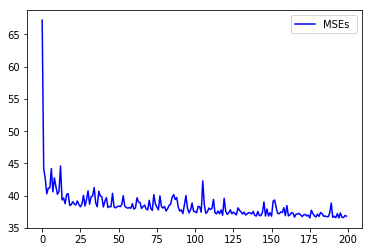

check point at 2019-04-27 00:56:38.217449
training : 前鎮
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 40s - loss: 0.0030 - val_loss: 0.0015
Epoch : 0, MSE : [61.37220928891099]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 22s - loss: 0.0015 - val_loss: 0.0012
Epoch : 1, MSE : [46.93796060994282]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0013 - val_loss: 0.0011
Epoch : 2, MSE : [44.30588006602143]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0010
Epoch : 3, MSE : [40.81161745908398]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0010
Epoch : 4, MSE : [40.99880095909292]
-------------------------------------------
Train on 21748 samples, validate on 543

 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 45, MSE : [39.927875994745044]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.9484e-04
Epoch : 46, MSE : [39.58389471598025]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.9461e-04
Epoch : 47, MSE : [39.52768352199905]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 48, MSE : [40.529356910423175]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.9049e-04
Epoch : 49, MSE : [39.31898659668161]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 50, MSE : [40.4500637993960

 - 17s - loss: 0.0011 - val_loss: 9.9122e-04
Epoch : 90, MSE : [39.4470327895161]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 91, MSE : [41.48865194652932]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.9683e-04
Epoch : 92, MSE : [39.464804397455346]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0011
Epoch : 93, MSE : [41.964159926685475]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.9742e-04
Epoch : 94, MSE : [39.58027313832511]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 95, MSE : [41.38590419807190

 - 17s - loss: 0.0011 - val_loss: 9.9270e-04
Epoch : 135, MSE : [39.446033435264155]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 136, MSE : [39.55226382867702]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 137, MSE : [39.85800506230521]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 0.0010
Epoch : 138, MSE : [39.6865886698642]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.8120e-04
Epoch : 139, MSE : [38.899736823450176]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.8981e-04
Epoch : 140, MSE : [39.24954896

 - 17s - loss: 0.0011 - val_loss: 9.8200e-04
Epoch : 179, MSE : [39.13965749990127]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.5751e-04
Epoch : 180, MSE : [38.12950576366514]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.6045e-04
Epoch : 181, MSE : [38.13787075173592]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.5953e-04
Epoch : 182, MSE : [38.241300499344376]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.6855e-04
Epoch : 183, MSE : [38.45024703937149]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 17s - loss: 0.0011 - val_loss: 9.6082e-04
Epoch : 184, MSE : 

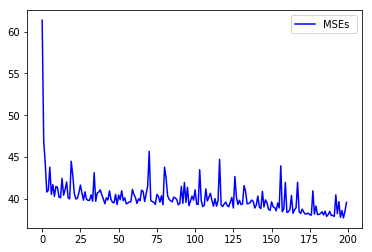

check point at 2019-04-27 02:04:13.084956
training : 大寮
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 36s - loss: 0.0048 - val_loss: 0.0027
Epoch : 0, MSE : [77.8684683647252]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0025 - val_loss: 0.0018
Epoch : 1, MSE : [52.34169691280272]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0021 - val_loss: 0.0017
Epoch : 2, MSE : [50.10817038900728]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0020 - val_loss: 0.0017
Epoch : 3, MSE : [50.74683528538692]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0020 - val_loss: 0.0017
Epoch : 4, MSE : [51.20760657912499]
-------------------------------------------
Train on 19194 samples, validate on 4799

 - 17s - loss: 0.0019 - val_loss: 0.0017
Epoch : 45, MSE : [49.928281013272084]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0019 - val_loss: 0.0017
Epoch : 46, MSE : [49.54037876121792]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0019 - val_loss: 0.0017
Epoch : 47, MSE : [49.52176573449294]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0019 - val_loss: 0.0017
Epoch : 48, MSE : [49.869940057720676]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0019 - val_loss: 0.0018
Epoch : 49, MSE : [52.20424738849506]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0019 - val_loss: 0.0017
Epoch : 50, MSE : [49.88422640740985]
---------

 - 16s - loss: 0.0018 - val_loss: 0.0016
Epoch : 90, MSE : [48.131879499403226]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0018 - val_loss: 0.0016
Epoch : 91, MSE : [47.792313315178454]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0018 - val_loss: 0.0017
Epoch : 92, MSE : [48.67220504929843]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0018 - val_loss: 0.0016
Epoch : 93, MSE : [47.734080921723546]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0018 - val_loss: 0.0017
Epoch : 94, MSE : [50.3557465332693]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0018 - val_loss: 0.0016
Epoch : 95, MSE : [49.15512022206328]
---------

 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 135, MSE : [47.158467787880674]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 136, MSE : [48.19524268691478]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 137, MSE : [46.500761099988544]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0018 - val_loss: 0.0016
Epoch : 138, MSE : [46.83474739707329]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 139, MSE : [46.446707825331984]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 18s - loss: 0.0017 - val_loss: 0.0016
Epoch : 140, MSE : [46.12188068328824]
--

 - 16s - loss: 0.0017 - val_loss: 0.0017
Epoch : 180, MSE : [48.23469486265827]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 181, MSE : [47.59319337339329]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 182, MSE : [46.401804702022915]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 183, MSE : [45.75126849296659]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0016
Epoch : 184, MSE : [45.95048653687423]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 16s - loss: 0.0017 - val_loss: 0.0016
Epoch : 185, MSE : [46.7848153801805]
-----

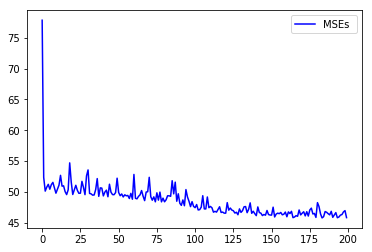

check point at 2019-04-27 03:09:03.360521
training : 小港
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 37s - loss: 0.0052 - val_loss: 0.0029
Epoch : 0, MSE : [86.90434190917072]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0026 - val_loss: 0.0019
Epoch : 1, MSE : [55.73457652077113]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0021 - val_loss: 0.0018
Epoch : 2, MSE : [52.913348088894836]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 16s - loss: 0.0020 - val_loss: 0.0018
Epoch : 3, MSE : [51.79566501767583]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0019 - val_loss: 0.0017
Epoch : 4, MSE : [50.55310253320988]
-------------------------------------------
Train on 18733 samples, validate on 46

 - 17s - loss: 0.0017 - val_loss: 0.0018
Epoch : 45, MSE : [51.70728312025485]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 46, MSE : [49.57404873273071]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 47, MSE : [48.76589892961995]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0018
Epoch : 48, MSE : [50.5548890523205]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0018
Epoch : 49, MSE : [51.68155941201878]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 50, MSE : [49.00435303050933]
------------

 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 90, MSE : [49.446023189934884]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 18s - loss: 0.0017 - val_loss: 0.0017
Epoch : 91, MSE : [48.416410365226405]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 92, MSE : [49.71746693493577]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 93, MSE : [49.42462277396531]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0018
Epoch : 94, MSE : [50.61248808496585]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 95, MSE : [48.732778046633335]
--------

 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 135, MSE : [47.94299736770686]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 18s - loss: 0.0017 - val_loss: 0.0017
Epoch : 136, MSE : [48.11685215681283]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 137, MSE : [47.70839358763484]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 18s - loss: 0.0016 - val_loss: 0.0017
Epoch : 138, MSE : [48.26198710994028]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 139, MSE : [48.92893944730842]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0017
Epoch : 140, MSE : [48.0784685314165]
------

 - 18s - loss: 0.0017 - val_loss: 0.0017
Epoch : 180, MSE : [47.65629960699153]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 18s - loss: 0.0016 - val_loss: 0.0017
Epoch : 181, MSE : [48.42163416260546]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0016 - val_loss: 0.0017
Epoch : 182, MSE : [47.80639015713488]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0016 - val_loss: 0.0017
Epoch : 183, MSE : [48.00484257084879]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 16s - loss: 0.0016 - val_loss: 0.0017
Epoch : 184, MSE : [48.094503429894225]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 17s - loss: 0.0017 - val_loss: 0.0016
Epoch : 185, MSE : [47.46278451993626]
----

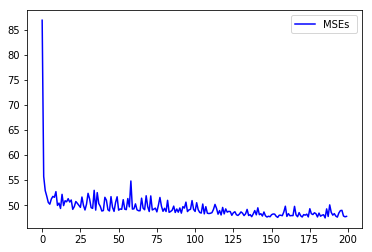

check point at 2019-04-27 04:15:54.564961
training : 屏東
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 38s - loss: 0.0040 - val_loss: 0.0020
Epoch : 0, MSE : [76.03907685026529]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 20s - loss: 0.0019 - val_loss: 0.0013
Epoch : 1, MSE : [47.43863251409776]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0015 - val_loss: 0.0013
Epoch : 2, MSE : [44.86867014207599]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0014 - val_loss: 0.0013
Epoch : 3, MSE : [43.637578818267976]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0013 - val_loss: 0.0013
Epoch : 4, MSE : [43.703365142240955]
-------------------------------------------
Train on 20231 samples, validate on 5

 - 16s - loss: 0.0012 - val_loss: 0.0012
Epoch : 45, MSE : [42.4925025980788]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 16s - loss: 0.0012 - val_loss: 0.0012
Epoch : 46, MSE : [42.65094713084625]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 16s - loss: 0.0012 - val_loss: 0.0012
Epoch : 47, MSE : [41.09413756262213]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 48, MSE : [41.808668260640054]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 49, MSE : [41.804191810128884]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 50, MSE : [41.08824898063701]
----------

 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 90, MSE : [40.81824302681508]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 91, MSE : [40.99694634453982]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 92, MSE : [41.782239633453266]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 93, MSE : [40.81636303278275]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 16s - loss: 0.0012 - val_loss: 0.0012
Epoch : 94, MSE : [41.57643841302314]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 16s - loss: 0.0012 - val_loss: 0.0012
Epoch : 95, MSE : [40.925692321917374]
---------

 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 135, MSE : [41.1075098132767]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 136, MSE : [41.47673217242669]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 137, MSE : [40.83032872538928]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 138, MSE : [40.9682411894658]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 139, MSE : [41.18561964885931]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0011
Epoch : 140, MSE : [40.49152451154844]
-------

 - 16s - loss: 0.0012 - val_loss: 0.0011
Epoch : 180, MSE : [40.38250078611841]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 181, MSE : [40.69814950211213]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 182, MSE : [41.926620851583856]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0012
Epoch : 183, MSE : [41.20941366182029]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 18s - loss: 0.0012 - val_loss: 0.0012
Epoch : 184, MSE : [41.52772522983125]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 17s - loss: 0.0012 - val_loss: 0.0011
Epoch : 185, MSE : [40.313345121171565]
---

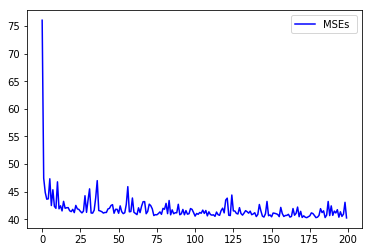

check point at 2019-04-27 05:22:09.701379
training : 左營
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 41s - loss: 0.0051 - val_loss: 0.0026
Epoch : 0, MSE : [74.130741412545]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 21s - loss: 0.0024 - val_loss: 0.0016
Epoch : 1, MSE : [46.33127403291174]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0019 - val_loss: 0.0015
Epoch : 2, MSE : [43.609784154198124]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0018 - val_loss: 0.0015
Epoch : 3, MSE : [43.51437598895539]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0017 - val_loss: 0.0014
Epoch : 4, MSE : [40.31836505555434]
-------------------------------------------
Train on 20922 samples, validate on 5231

 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 45, MSE : [38.321829003460415]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0013
Epoch : 46, MSE : [38.40133813105497]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 21s - loss: 0.0015 - val_loss: 0.0013
Epoch : 47, MSE : [38.211996734223845]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 48, MSE : [38.113500268051716]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0013
Epoch : 49, MSE : [38.29645565352522]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0013
Epoch : 50, MSE : [39.35502583802824]
--------

 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 90, MSE : [38.042873693502415]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0013
Epoch : 91, MSE : [37.56808856887592]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0013
Epoch : 92, MSE : [37.528392927342146]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 93, MSE : [38.2365268844948]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 94, MSE : [39.132857622908524]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 95, MSE : [39.44306695874208]
---------

 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 135, MSE : [37.4839486744072]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 136, MSE : [37.53758450802163]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0013
Epoch : 137, MSE : [37.14614557226479]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 138, MSE : [37.57702181945804]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0014 - val_loss: 0.0013
Epoch : 139, MSE : [37.64027271468391]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0013
Epoch : 140, MSE : [37.249220952938494]
-----

 - 19s - loss: 0.0014 - val_loss: 0.0013
Epoch : 180, MSE : [37.19716609072988]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0014 - val_loss: 0.0013
Epoch : 181, MSE : [37.97862436906598]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 20s - loss: 0.0014 - val_loss: 0.0013
Epoch : 182, MSE : [36.98534643360259]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0014 - val_loss: 0.0013
Epoch : 183, MSE : [36.929874202119045]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0014 - val_loss: 0.0013
Epoch : 184, MSE : [36.9751722578941]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 19s - loss: 0.0014 - val_loss: 0.0013
Epoch : 185, MSE : [36.97885771445341]
-----

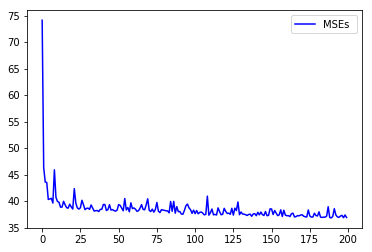

check point at 2019-04-27 06:38:16.567885
training : 復興
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 45s - loss: 0.0048 - val_loss: 0.0023
Epoch : 0, MSE : [58.832738039726806]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 22s - loss: 0.0020 - val_loss: 0.0011
Epoch : 1, MSE : [29.20768572037325]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0010
Epoch : 2, MSE : [28.24771044003342]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 20s - loss: 0.0014 - val_loss: 0.0011
Epoch : 3, MSE : [28.221790965828976]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0014 - val_loss: 0.0010
Epoch : 4, MSE : [27.381760746158598]
-------------------------------------------
Train on 22151 samples, validate on 

 - 19s - loss: 0.0012 - val_loss: 9.9051e-04
Epoch : 44, MSE : [26.30229633493841]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.4672e-04
Epoch : 45, MSE : [25.050500145840346]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.4547e-04
Epoch : 46, MSE : [24.998878347728137]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.9011e-04
Epoch : 47, MSE : [26.034060624552165]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.3398e-04
Epoch : 48, MSE : [24.727588986686982]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.4325e-04
Epoch : 49, MSE : [24

 - 19s - loss: 0.0012 - val_loss: 9.6359e-04
Epoch : 88, MSE : [24.956416076908244]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.5647e-04
Epoch : 89, MSE : [24.826717628169284]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.6148e-04
Epoch : 90, MSE : [24.87170253509402]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 20s - loss: 0.0012 - val_loss: 9.3779e-04
Epoch : 91, MSE : [24.397991202898744]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0011 - val_loss: 9.2677e-04
Epoch : 92, MSE : [24.050986879746986]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0012 - val_loss: 9.3102e-04
Epoch : 93, MSE : [24

 - 19s - loss: 0.0011 - val_loss: 9.3038e-04
Epoch : 132, MSE : [24.009077567448617]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0011 - val_loss: 9.6550e-04
Epoch : 133, MSE : [24.988661498650064]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0011 - val_loss: 9.6552e-04
Epoch : 134, MSE : [24.989651753539952]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0011 - val_loss: 9.2230e-04
Epoch : 135, MSE : [23.859183807374485]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0011 - val_loss: 0.0011
Epoch : 136, MSE : [27.899949032271408]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 19s - loss: 0.0011 - val_loss: 9.6482e-04
Epoch : 137, MSE : 

 - 20s - loss: 0.0011 - val_loss: 9.2348e-04
Epoch : 176, MSE : [23.721585096992634]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 20s - loss: 0.0011 - val_loss: 9.3021e-04
Epoch : 177, MSE : [24.025009115488796]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 20s - loss: 0.0011 - val_loss: 9.4516e-04
Epoch : 178, MSE : [24.339541152573982]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 20s - loss: 0.0011 - val_loss: 9.2578e-04
Epoch : 179, MSE : [23.72322218563137]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 20s - loss: 0.0011 - val_loss: 9.2269e-04
Epoch : 180, MSE : [23.805101067349195]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 20s - loss: 0.0011 - val_loss: 9.4826e-04
Epoch : 181, MSE

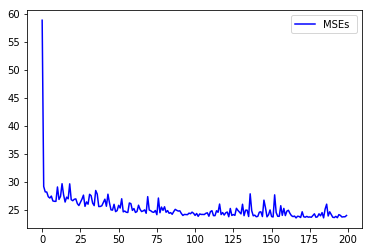

check point at 2019-04-27 07:55:13.630424
training : 恆春
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 42s - loss: 0.0024 - val_loss: 0.0017
Epoch : 0, MSE : [14.598911391465489]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0017 - val_loss: 0.0015
Epoch : 1, MSE : [12.767954097281063]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0016 - val_loss: 0.0015
Epoch : 2, MSE : [12.752229670137194]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0016 - val_loss: 0.0015
Epoch : 3, MSE : [13.019160081299201]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0016 - val_loss: 0.0015
Epoch : 4, MSE : [12.825135103497168]
-------------------------------------------
Train on 21172 samples, validate o

 - 19s - loss: 0.0015 - val_loss: 0.0015
Epoch : 45, MSE : [12.958533362543129]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0015
Epoch : 46, MSE : [12.662290641392419]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0014
Epoch : 47, MSE : [12.416211352064716]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0015
Epoch : 48, MSE : [13.102604048095934]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0015
Epoch : 49, MSE : [12.68562895284824]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 18s - loss: 0.0015 - val_loss: 0.0015
Epoch : 50, MSE : [13.000134133885519]
------

 - 19s - loss: 0.0015 - val_loss: 0.0014
Epoch : 90, MSE : [12.421964675768223]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0014
Epoch : 91, MSE : [12.463070656598264]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0014
Epoch : 92, MSE : [12.574390583921899]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0015
Epoch : 93, MSE : [13.154291911210555]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0015
Epoch : 94, MSE : [13.29008356742203]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 95, MSE : [12.51428506310346]
-------

 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 135, MSE : [12.615129007220652]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 136, MSE : [12.60940947767372]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0015
Epoch : 137, MSE : [12.750920560514757]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0014
Epoch : 138, MSE : [12.496899170289568]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0014
Epoch : 139, MSE : [12.438736780621161]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 140, MSE : [12.496828741456417]


 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 180, MSE : [12.37684736536313]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0015
Epoch : 181, MSE : [12.745431859348479]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 182, MSE : [12.527358200430337]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 183, MSE : [12.676429951239477]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0014
Epoch : 184, MSE : [12.492666661661469]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 19s - loss: 0.0015 - val_loss: 0.0014
Epoch : 185, MSE : [12.453623981151456]


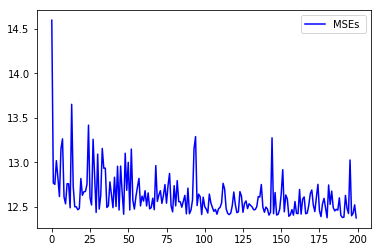

check point at 2019-04-27 09:10:41.263562
training : 林園
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 40s - loss: 0.0042 - val_loss: 0.0029
Epoch : 0, MSE : [116.93820115870908]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0027 - val_loss: 0.0023
Epoch : 1, MSE : [91.63750915595332]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0025 - val_loss: 0.0023
Epoch : 2, MSE : [92.16473246508494]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0025 - val_loss: 0.0023
Epoch : 3, MSE : [91.64702028891234]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0025 - val_loss: 0.0023
Epoch : 4, MSE : [91.66091870249879]
-------------------------------------------
Train on 19482 samples, validate on 48

 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 45, MSE : [93.56878873504255]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 46, MSE : [91.81310977388567]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 47, MSE : [90.97825336330561]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 48, MSE : [91.43472780487276]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0024
Epoch : 49, MSE : [95.33306330637352]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 50, MSE : [91.17232182542342]
-----------

Epoch : 90, MSE : [91.39370986002957]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 91, MSE : [90.29691357196873]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 92, MSE : [91.55308813430855]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 93, MSE : [90.48458475509977]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 94, MSE : [90.26537712668166]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 95, MSE : [90.0002164200011]
-------------------------------------------
Train on 

Epoch : 135, MSE : [90.98466676794003]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 136, MSE : [90.19044374202191]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 137, MSE : [92.3238427966754]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 138, MSE : [91.37779001310084]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0023 - val_loss: 0.0023
Epoch : 139, MSE : [90.04542422688768]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 140, MSE : [90.7169214448772]
-------------------------------------------
Trai

Epoch : 180, MSE : [90.12372000884912]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0023 - val_loss: 0.0023
Epoch : 181, MSE : [90.19494931358969]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0023 - val_loss: 0.0023
Epoch : 182, MSE : [90.2989968474561]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0023
Epoch : 183, MSE : [90.25933790373196]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0024 - val_loss: 0.0022
Epoch : 184, MSE : [89.49405771673744]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 19s - loss: 0.0023 - val_loss: 0.0022
Epoch : 185, MSE : [89.45712755495649]
-------------------------------------------
Tra

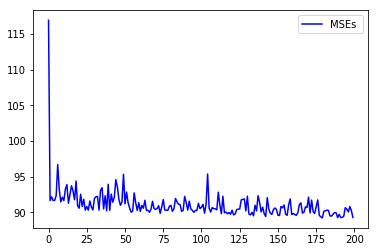

check point at 2019-04-27 10:25:34.904896
training : 楠梓
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 44s - loss: 0.0037 - val_loss: 0.0019
Epoch : 0, MSE : [58.82632324848387]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0018 - val_loss: 0.0013
Epoch : 1, MSE : [40.53432485170882]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0015 - val_loss: 0.0012
Epoch : 2, MSE : [38.781120586238664]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0014 - val_loss: 0.0012
Epoch : 3, MSE : [38.450414958913655]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0014 - val_loss: 0.0013
Epoch : 4, MSE : [39.96690342766551]
-------------------------------------------
Train on 22266 samples, validate on 5

 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 45, MSE : [36.63845657381422]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 46, MSE : [35.90009253215104]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 47, MSE : [36.09054028046884]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0011
Epoch : 48, MSE : [35.30769662728497]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 49, MSE : [36.20297746666602]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0013 - val_loss: 0.0012
Epoch : 50, MSE : [36.110671424190784]
----------

 - 20s - loss: 0.0012 - val_loss: 0.0011
Epoch : 90, MSE : [35.48584061335855]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0013 - val_loss: 0.0011
Epoch : 91, MSE : [35.36732155071314]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0013 - val_loss: 0.0012
Epoch : 92, MSE : [36.45347770258914]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0012 - val_loss: 0.0011
Epoch : 93, MSE : [35.36841310622057]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0012 - val_loss: 0.0011
Epoch : 94, MSE : [34.99948020485351]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0012 - val_loss: 0.0012
Epoch : 95, MSE : [36.20676298426978]
-----------

 - 21s - loss: 0.0012 - val_loss: 0.0011
Epoch : 135, MSE : [35.03946311033116]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0012 - val_loss: 0.0011
Epoch : 136, MSE : [34.62914535135743]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0012 - val_loss: 0.0011
Epoch : 137, MSE : [34.924312217109595]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0012 - val_loss: 0.0011
Epoch : 138, MSE : [35.30626690387819]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0012 - val_loss: 0.0012
Epoch : 139, MSE : [35.91034681454396]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0012 - val_loss: 0.0012
Epoch : 140, MSE : [35.705672758333186]
---

 - 20s - loss: 0.0012 - val_loss: 0.0011
Epoch : 180, MSE : [34.67738124727646]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0012 - val_loss: 0.0012
Epoch : 181, MSE : [36.29275413662358]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 20s - loss: 0.0012 - val_loss: 0.0012
Epoch : 182, MSE : [36.81465447501535]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0012 - val_loss: 0.0011
Epoch : 183, MSE : [34.286659712230154]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0012 - val_loss: 0.0012
Epoch : 184, MSE : [35.45970780629505]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 21s - loss: 0.0012 - val_loss: 0.0011
Epoch : 185, MSE : [34.44150223811398]
----

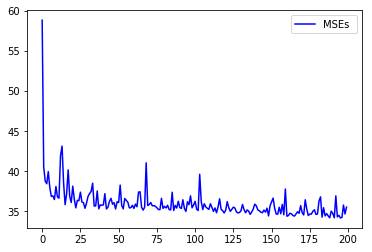

check point at 2019-04-27 11:46:11.726709
training : 橋頭
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 42s - loss: 0.0040 - val_loss: 0.0021
Epoch : 0, MSE : [52.81862857064506]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0019 - val_loss: 0.0014
Epoch : 1, MSE : [35.37745501294256]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0015 - val_loss: 0.0014
Epoch : 2, MSE : [34.42534494523939]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 23s - loss: 0.0015 - val_loss: 0.0013
Epoch : 3, MSE : [33.01860006039578]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0014 - val_loss: 0.0013
Epoch : 4, MSE : [32.75866850904188]
-------------------------------------------
Train on 21671 samples, validate on 541

 - 22s - loss: 0.0014 - val_loss: 0.0013
Epoch : 45, MSE : [32.03777369065872]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 46, MSE : [33.27296971491735]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0014 - val_loss: 0.0013
Epoch : 47, MSE : [31.981178751610408]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0014 - val_loss: 0.0013
Epoch : 48, MSE : [32.14419822760922]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0014
Epoch : 49, MSE : [35.36884059455102]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 50, MSE : [33.10577168735673]
----------

 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 90, MSE : [31.659044799361435]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 91, MSE : [31.97387732385704]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 92, MSE : [31.058035128827502]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 93, MSE : [31.05733727447343]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 94, MSE : [31.77033515205369]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 95, MSE : [31.543098622656906]
--------

 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 135, MSE : [30.772811974473996]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 136, MSE : [31.840111021058718]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 137, MSE : [30.82369734890652]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 138, MSE : [30.62574830193434]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 139, MSE : [30.506345847451236]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 140, MSE : [30.140880078438087]
-

 - 22s - loss: 0.0013 - val_loss: 0.0013
Epoch : 180, MSE : [30.243434154240916]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0012 - val_loss: 0.0013
Epoch : 181, MSE : [30.479853846553667]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 182, MSE : [30.3361364403959]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0012 - val_loss: 0.0012
Epoch : 183, MSE : [29.692147852419527]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0012 - val_loss: 0.0012
Epoch : 184, MSE : [29.78384459750518]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 22s - loss: 0.0012 - val_loss: 0.0012
Epoch : 185, MSE : [29.920775434724536]
--

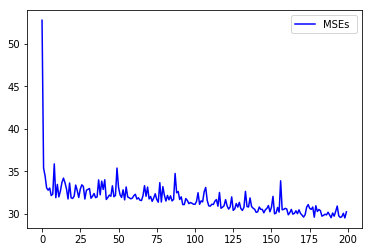

check point at 2019-04-27 13:12:22.379414
training : 潮州
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 44s - loss: 0.0037 - val_loss: 0.0019
Epoch : 0, MSE : [63.878407020576816]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 23s - loss: 0.0018 - val_loss: 0.0014
Epoch : 1, MSE : [46.46765097299416]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0016 - val_loss: 0.0013
Epoch : 2, MSE : [42.79883741758673]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0015 - val_loss: 0.0013
Epoch : 3, MSE : [42.26982850334638]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0014 - val_loss: 0.0013
Epoch : 4, MSE : [40.931995459062655]
-------------------------------------------
Train on 21498 samples, validate on 5

 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 45, MSE : [39.655575708813004]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 46, MSE : [39.120472090126505]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0015
Epoch : 47, MSE : [49.563329864020936]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 48, MSE : [40.048712537675335]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 49, MSE : [39.92709994275818]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 50, MSE : [39.34089889713516]
-------

 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 90, MSE : [39.111562712219886]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 91, MSE : [38.720757638953536]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 92, MSE : [38.88184643151504]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 93, MSE : [38.82657396401488]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 94, MSE : [38.69456457756767]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 95, MSE : [39.12343883377131]
---------

 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 135, MSE : [39.515738907885925]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 136, MSE : [38.97929293967323]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 137, MSE : [38.47507907498176]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 138, MSE : [38.4564981256501]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0013
Epoch : 139, MSE : [41.410927068599136]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 140, MSE : [38.589350743634036]
---

 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 180, MSE : [38.41594898888101]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 181, MSE : [38.63189569732666]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 182, MSE : [38.62481497029104]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 20s - loss: 0.0013 - val_loss: 0.0012
Epoch : 183, MSE : [39.08331544181321]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 184, MSE : [38.310872736327795]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 19s - loss: 0.0013 - val_loss: 0.0012
Epoch : 185, MSE : [39.13622632825081]
----

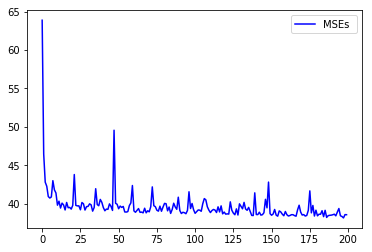

check point at 2019-04-27 14:29:00.509464
training : 美濃
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 46s - loss: 0.0034 - val_loss: 0.0020
Epoch : 0, MSE : [46.7695915752904]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0020 - val_loss: 0.0016
Epoch : 1, MSE : [37.07369181043135]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0018 - val_loss: 0.0015
Epoch : 2, MSE : [35.433709995442605]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0017 - val_loss: 0.0015
Epoch : 3, MSE : [35.250510843442235]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0017 - val_loss: 0.0015
Epoch : 4, MSE : [35.168656557717995]
-------------------------------------------
Train on 20442 samples, validate on 5

 - 22s - loss: 0.0016 - val_loss: 0.0016
Epoch : 45, MSE : [36.51093125059028]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 46, MSE : [35.53495449791623]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 47, MSE : [35.214655452529705]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0016
Epoch : 48, MSE : [37.045444092448335]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 49, MSE : [36.329318899890865]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 50, MSE : [35.2883127084483]
---------

 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 90, MSE : [34.98552211350757]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 91, MSE : [34.71200829831815]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 92, MSE : [34.83374810787395]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 93, MSE : [34.84563956796996]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 94, MSE : [34.805859873584]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 95, MSE : [34.85065603819809]
-------------

 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 135, MSE : [34.84651228201966]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 136, MSE : [35.31470100790293]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 137, MSE : [34.243980412658125]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 138, MSE : [34.578388075365886]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 139, MSE : [34.29730230396601]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 140, MSE : [35.09100463292889]
---

 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 180, MSE : [35.20007378540759]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 181, MSE : [34.71683980528124]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 182, MSE : [34.189493824555875]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 183, MSE : [34.55816645813455]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 184, MSE : [34.7650605923919]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 22s - loss: 0.0016 - val_loss: 0.0015
Epoch : 185, MSE : [35.264222722211045]
----

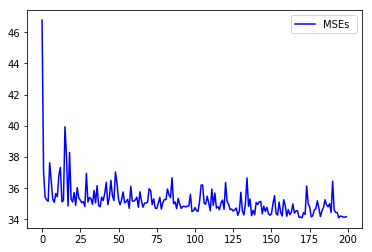

check point at 2019-04-27 15:54:36.476108
training : 鳳山
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 51s - loss: 0.0042 - val_loss: 0.0020
Epoch : 0, MSE : [49.27674048134189]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0019 - val_loss: 0.0014
Epoch : 1, MSE : [33.38489705554658]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 24s - loss: 0.0016 - val_loss: 0.0014
Epoch : 2, MSE : [33.40307823825005]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0015 - val_loss: 0.0013
Epoch : 3, MSE : [31.609483743176824]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0015 - val_loss: 0.0016
Epoch : 4, MSE : [40.64781159480199]
-------------------------------------------
Train on 22400 samples, validate on 56

 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 45, MSE : [30.025402903084387]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 46, MSE : [29.935996383621436]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 47, MSE : [30.26809805910927]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 48, MSE : [29.834688981372402]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 23s - loss: 0.0013 - val_loss: 0.0013
Epoch : 49, MSE : [32.47797161480201]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 23s - loss: 0.0013 - val_loss: 0.0013
Epoch : 50, MSE : [31.54444049388943]
--------

 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 90, MSE : [29.185651657269208]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 91, MSE : [29.656251792049282]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 92, MSE : [29.329825922041636]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 93, MSE : [29.466835872347826]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 94, MSE : [29.05097329805382]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 95, MSE : [30.11735207222593]
-------

 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 135, MSE : [29.248602443191853]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 136, MSE : [29.185347617464743]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 137, MSE : [29.223472456339103]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 138, MSE : [29.574010324298726]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 139, MSE : [29.705350689127876]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 24s - loss: 0.0013 - val_loss: 0.0012
Epoch : 140, MSE : [28.734053569691373]

 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 180, MSE : [28.884718592517885]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0012 - val_loss: 0.0012
Epoch : 181, MSE : [29.030649564618347]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 182, MSE : [29.525966823303182]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 183, MSE : [29.56169599397314]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 184, MSE : [28.849483552244696]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 22s - loss: 0.0013 - val_loss: 0.0012
Epoch : 185, MSE : [29.05121227190418]
-

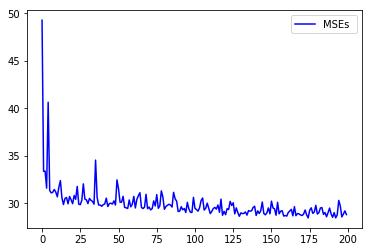

check point at 2019-04-27 17:22:19.374163


In [9]:
import datetime
db=MySQLdb.connect(host="localhost",user="root", passwd="swater0", db="airdb", charset="utf8")
cursor = db.cursor()


epochs = 200
windosSize = 7

stationList = getStationList(cursor)

col=1
for station in stationList:
    print("training : " +station)
    sc, X_train, y_train, X_test, y_test = fetchData(cursor,station,windosSize)
    regressor = buildModel()
    MSEs = train(regressor,sc,X_train, y_train, X_test, y_test,epochs)
    
    book = xlwt.Workbook(encoding="utf-8")
    sheet1 = book.add_sheet("Sheet1")
    writeExcelHead(sheet1,epochs,station)
    row = 1
    for mse in MSEs:
        sheet1.write(row,1,mse)
        row+=1
    book.save("excelFiles/LSTM/LSTMresult"+station+".xls")
        
    print('check point at ' + str(datetime.datetime.now()))

db.close()





In [25]:


book.save("Test1EXCCCC.xls")